In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.functions import green
from utils.loss_weight import update_lambda, loss_grad_norm
from utils.plot_func import plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.4]
k = 2 * np.pi * 20 / 1500 * 100
L_pml = 0.4
sigma = 3.5
strentch = 5

In [3]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [4]:
def get_dataset(Lx, Ly, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(200000, 1) - Lx, 2 * Ly * torch.rand(200000, 1) - Ly
    x, y = torch.linspace(-Lx, Lx, 500), torch.linspace(-Ly, Ly, 200)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x, y):
    import random as rd
    num = len(x)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id]

In [5]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    #dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    #sy = sigma0 * (dist_ver / L_pml) ** 2
    sy = torch.zeros_like(sx)
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()
    xy = torch.cat([x, y], dim=-1)

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = (1 / strentch ** 2) * pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res[:, 0] ** 2).mean(), (res[:, 1] ** 2).mean()

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L0 = Lx # - L_pml
    x, y = torch.linspace(-L0, L0, n_coll), torch.ones(n_coll)
    x, y = torch.cat([x, x], dim=-1), torch.cat([y, -y], dim=-1)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src, k, strentch=strentch)
    return (res ** 2).mean()

In [6]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
#import joblib
#state_dict = joblib.load('model_green.joblib')
#model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lamb = [1, 1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
n_lamb_update = 50

In [7]:
n_epochs = int(5e3)
learning_rate = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [8]:
model = model.to(device)

In [9]:
x0, y0 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y in data_iter(10000, x0, y0):
        optimizer.zero_grad()
        loss_pde1, loss_pde2 = loss_fn(model, x, y, k)
        loss_top = loss_bd(model, Lx, Ly, src)
        loss_lst = [loss_pde1, loss_pde2, loss_top]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde1 + lamb[1] * loss_pde2 + lamb[2] * loss_top
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde1: {loss_pde1.item()}, Loss_pde2: {loss_pde2.item()}')
    
    l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_25535/3952875006.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_25535/3952875006.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)
/tmp/ipykernel_25535/7130914.py:39:

Epoch 5, Loss: 1.353868007659912, Loss_pde1: 0.22592538595199585, Loss_pde2: 0.23808442056179047


  0%|          | 10/5000 [00:37<5:28:00,  3.94s/it]

Epoch 10, Loss: 1.113158106803894, Loss_pde1: 0.09639554470777512, Loss_pde2: 0.09586293250322342


  0%|          | 15/5000 [00:56<5:29:36,  3.97s/it]

Epoch 15, Loss: 1.0548378229141235, Loss_pde1: 0.07866226881742477, Loss_pde2: 0.06412569433450699


  0%|          | 20/5000 [01:15<5:30:32,  3.98s/it]

Epoch 20, Loss: 1.0213371515274048, Loss_pde1: 0.07884775102138519, Loss_pde2: 0.06152324005961418


  0%|          | 25/5000 [01:34<5:31:15,  4.00s/it]

Epoch 25, Loss: 1.0455538034439087, Loss_pde1: 0.09823328256607056, Loss_pde2: 0.07790507376194


  1%|          | 30/5000 [01:54<5:31:53,  4.01s/it]

Epoch 30, Loss: 1.0206642150878906, Loss_pde1: 0.15389616787433624, Loss_pde2: 0.1261523813009262


  1%|          | 35/5000 [02:13<5:32:13,  4.01s/it]

Epoch 35, Loss: 0.8694782257080078, Loss_pde1: 0.188790425658226, Loss_pde2: 0.1704142689704895


  1%|          | 40/5000 [02:32<5:32:25,  4.02s/it]

Epoch 40, Loss: 0.7237116098403931, Loss_pde1: 0.1763545125722885, Loss_pde2: 0.14345751702785492


  1%|          | 45/5000 [02:51<5:32:29,  4.03s/it]

Epoch 45, Loss: 0.6838847398757935, Loss_pde1: 0.1759403944015503, Loss_pde2: 0.14594966173171997


  1%|          | 50/5000 [03:11<5:34:51,  4.06s/it]

Epoch 50, Loss: 0.517887532711029, Loss_pde1: 0.14083141088485718, Loss_pde2: 0.11251669377088547


  1%|          | 55/5000 [03:31<5:42:49,  4.16s/it]

Epoch 55, Loss: 0.4891487956047058, Loss_pde1: 0.1348394751548767, Loss_pde2: 0.10388815402984619


  1%|          | 60/5000 [03:50<5:39:46,  4.13s/it]

Epoch 60, Loss: 0.3620721399784088, Loss_pde1: 0.10746535658836365, Loss_pde2: 0.07097803056240082


  1%|▏         | 65/5000 [04:10<5:39:25,  4.13s/it]

Epoch 65, Loss: 0.31043723225593567, Loss_pde1: 0.09275193512439728, Loss_pde2: 0.059436142444610596


  1%|▏         | 70/5000 [04:30<5:39:29,  4.13s/it]

Epoch 70, Loss: 0.2683332860469818, Loss_pde1: 0.07891949266195297, Loss_pde2: 0.051604002714157104


  2%|▏         | 75/5000 [04:50<5:39:10,  4.13s/it]

Epoch 75, Loss: 0.31708648800849915, Loss_pde1: 0.08442115038633347, Loss_pde2: 0.05585743114352226


  2%|▏         | 80/5000 [05:10<5:45:00,  4.21s/it]

Epoch 80, Loss: 0.23235149681568146, Loss_pde1: 0.07061764597892761, Loss_pde2: 0.039464715868234634


  2%|▏         | 85/5000 [05:30<5:47:39,  4.24s/it]

Epoch 85, Loss: 0.352091908454895, Loss_pde1: 0.09168273955583572, Loss_pde2: 0.060813646763563156


  2%|▏         | 90/5000 [05:51<5:49:01,  4.27s/it]

Epoch 90, Loss: 0.18864788115024567, Loss_pde1: 0.062380362302064896, Loss_pde2: 0.029714342206716537


  2%|▏         | 95/5000 [06:11<5:48:58,  4.27s/it]

Epoch 95, Loss: 0.18314708769321442, Loss_pde1: 0.05952226370573044, Loss_pde2: 0.027763765305280685


  2%|▏         | 100/5000 [06:32<5:54:02,  4.34s/it]

Epoch 100, Loss: 0.1792176365852356, Loss_pde1: 0.05679642781615257, Loss_pde2: 0.027863316237926483


  2%|▏         | 105/5000 [06:53<5:51:29,  4.31s/it]

Epoch 105, Loss: 0.14292173087596893, Loss_pde1: 0.04981795698404312, Loss_pde2: 0.021073797717690468


  2%|▏         | 110/5000 [07:14<5:58:20,  4.40s/it]

Epoch 110, Loss: 0.140384241938591, Loss_pde1: 0.04850691556930542, Loss_pde2: 0.02075253054499626


  2%|▏         | 115/5000 [07:35<6:06:12,  4.50s/it]

Epoch 115, Loss: 0.15741607546806335, Loss_pde1: 0.04768874868750572, Loss_pde2: 0.020930800586938858


  2%|▏         | 120/5000 [07:57<6:07:07,  4.51s/it]

Epoch 120, Loss: 0.12889130413532257, Loss_pde1: 0.04412758722901344, Loss_pde2: 0.01915276050567627


  2%|▎         | 125/5000 [08:19<6:05:03,  4.49s/it]

Epoch 125, Loss: 0.1304912269115448, Loss_pde1: 0.042421143501996994, Loss_pde2: 0.01922030560672283


  3%|▎         | 130/5000 [08:40<6:05:42,  4.51s/it]

Epoch 130, Loss: 0.12903784215450287, Loss_pde1: 0.03984023258090019, Loss_pde2: 0.019402241334319115


  3%|▎         | 135/5000 [09:02<6:05:45,  4.51s/it]

Epoch 135, Loss: 0.11425748467445374, Loss_pde1: 0.03886914625763893, Loss_pde2: 0.01657787524163723


  3%|▎         | 140/5000 [09:23<6:05:54,  4.52s/it]

Epoch 140, Loss: 0.12031331658363342, Loss_pde1: 0.04239967092871666, Loss_pde2: 0.015726417303085327


  3%|▎         | 145/5000 [09:45<6:04:19,  4.50s/it]

Epoch 145, Loss: 0.09963776916265488, Loss_pde1: 0.03565900772809982, Loss_pde2: 0.01289281900972128


  3%|▎         | 150/5000 [10:06<6:02:01,  4.48s/it]

Epoch 150, Loss: 0.09828095138072968, Loss_pde1: 0.03498882055282593, Loss_pde2: 0.01308242417871952


  3%|▎         | 155/5000 [10:27<5:59:39,  4.45s/it]

Epoch 155, Loss: 0.10430721193552017, Loss_pde1: 0.03314928710460663, Loss_pde2: 0.013307766057550907


  3%|▎         | 160/5000 [10:49<6:00:15,  4.47s/it]

Epoch 160, Loss: 0.09345285594463348, Loss_pde1: 0.03156134858727455, Loss_pde2: 0.012884101830422878


  3%|▎         | 165/5000 [11:11<6:05:47,  4.54s/it]

Epoch 165, Loss: 0.1016935482621193, Loss_pde1: 0.03390214964747429, Loss_pde2: 0.01386474072933197


  3%|▎         | 170/5000 [11:32<6:06:42,  4.56s/it]

Epoch 170, Loss: 0.09500912576913834, Loss_pde1: 0.031722716987133026, Loss_pde2: 0.01251611951738596


  4%|▎         | 175/5000 [11:54<6:06:20,  4.56s/it]

Epoch 175, Loss: 0.09617307782173157, Loss_pde1: 0.030401010066270828, Loss_pde2: 0.014407799579203129


  4%|▎         | 180/5000 [12:16<6:05:22,  4.55s/it]

Epoch 180, Loss: 0.10471077263355255, Loss_pde1: 0.0324239544570446, Loss_pde2: 0.015400762669742107


  4%|▎         | 185/5000 [12:38<6:05:30,  4.55s/it]

Epoch 185, Loss: 0.10296912491321564, Loss_pde1: 0.033714838325977325, Loss_pde2: 0.013252317905426025


  4%|▍         | 190/5000 [12:59<6:05:21,  4.56s/it]

Epoch 190, Loss: 0.09884950518608093, Loss_pde1: 0.031295888125896454, Loss_pde2: 0.01396037545055151


  4%|▍         | 195/5000 [13:21<6:05:03,  4.56s/it]

Epoch 195, Loss: 0.16667413711547852, Loss_pde1: 0.041441164910793304, Loss_pde2: 0.02328382432460785


  4%|▍         | 200/5000 [13:43<6:04:46,  4.56s/it]

Epoch 200, Loss: 0.1187494620680809, Loss_pde1: 0.035012342035770416, Loss_pde2: 0.015209420584142208


  4%|▍         | 205/5000 [14:05<6:04:11,  4.56s/it]

Epoch 205, Loss: 0.0936107486486435, Loss_pde1: 0.02924078330397606, Loss_pde2: 0.012846194207668304


  4%|▍         | 210/5000 [14:27<6:03:49,  4.56s/it]

Epoch 210, Loss: 0.08583354204893112, Loss_pde1: 0.026439839974045753, Loss_pde2: 0.012578262016177177


  4%|▍         | 215/5000 [14:48<6:03:37,  4.56s/it]

Epoch 215, Loss: 0.08280886709690094, Loss_pde1: 0.026196453720331192, Loss_pde2: 0.012104951776564121


  4%|▍         | 220/5000 [15:10<6:03:15,  4.56s/it]

Epoch 220, Loss: 0.07265879958868027, Loss_pde1: 0.023381706327199936, Loss_pde2: 0.011114331893622875


  4%|▍         | 225/5000 [15:32<6:02:45,  4.56s/it]

Epoch 225, Loss: 0.08886507898569107, Loss_pde1: 0.025716528296470642, Loss_pde2: 0.013584035448729992


  5%|▍         | 230/5000 [15:54<6:02:27,  4.56s/it]

Epoch 230, Loss: 0.08299868553876877, Loss_pde1: 0.025293471291661263, Loss_pde2: 0.012128747068345547


  5%|▍         | 235/5000 [16:15<5:59:34,  4.53s/it]

Epoch 235, Loss: 0.0779443085193634, Loss_pde1: 0.02346932701766491, Loss_pde2: 0.012443332932889462


  5%|▍         | 240/5000 [16:37<5:58:47,  4.52s/it]

Epoch 240, Loss: 0.11491302400827408, Loss_pde1: 0.0311668049544096, Loss_pde2: 0.019770547747612


  5%|▍         | 245/5000 [16:59<5:58:07,  4.52s/it]

Epoch 245, Loss: 0.06600470095872879, Loss_pde1: 0.020815616473555565, Loss_pde2: 0.010239469818770885


  5%|▌         | 250/5000 [17:20<5:56:16,  4.50s/it]

Epoch 250, Loss: 0.06866520643234253, Loss_pde1: 0.02150069735944271, Loss_pde2: 0.010408129543066025


  5%|▌         | 255/5000 [17:42<5:59:36,  4.55s/it]

Epoch 255, Loss: 0.09349537640810013, Loss_pde1: 0.025331124663352966, Loss_pde2: 0.017477963119745255


  5%|▌         | 260/5000 [18:04<5:59:59,  4.56s/it]

Epoch 260, Loss: 0.07131289690732956, Loss_pde1: 0.021513091400265694, Loss_pde2: 0.010729525238275528


  5%|▌         | 265/5000 [18:26<5:59:46,  4.56s/it]

Epoch 265, Loss: 0.0801568329334259, Loss_pde1: 0.024021968245506287, Loss_pde2: 0.013252533972263336


  5%|▌         | 270/5000 [18:47<5:59:25,  4.56s/it]

Epoch 270, Loss: 0.0835675597190857, Loss_pde1: 0.022760799154639244, Loss_pde2: 0.015775108709931374


  6%|▌         | 275/5000 [19:09<5:58:54,  4.56s/it]

Epoch 275, Loss: 0.06584253162145615, Loss_pde1: 0.01984328031539917, Loss_pde2: 0.010367711074650288


  6%|▌         | 280/5000 [19:31<5:56:33,  4.53s/it]

Epoch 280, Loss: 0.06455913186073303, Loss_pde1: 0.020075587555766106, Loss_pde2: 0.009844500571489334


  6%|▌         | 285/5000 [19:53<5:57:51,  4.55s/it]

Epoch 285, Loss: 0.07596735656261444, Loss_pde1: 0.020968081429600716, Loss_pde2: 0.012539783492684364


  6%|▌         | 290/5000 [20:14<5:57:44,  4.56s/it]

Epoch 290, Loss: 0.10502278804779053, Loss_pde1: 0.02628129906952381, Loss_pde2: 0.01855115219950676


  6%|▌         | 295/5000 [20:36<5:57:29,  4.56s/it]

Epoch 295, Loss: 0.07070296257734299, Loss_pde1: 0.02124222368001938, Loss_pde2: 0.010364147834479809


  6%|▌         | 300/5000 [20:58<5:57:28,  4.56s/it]

Epoch 300, Loss: 0.06498134881258011, Loss_pde1: 0.019236315041780472, Loss_pde2: 0.009756767190992832


  6%|▌         | 305/5000 [21:20<5:56:57,  4.56s/it]

Epoch 305, Loss: 0.0627845823764801, Loss_pde1: 0.017324062064290047, Loss_pde2: 0.01068826299160719


  6%|▌         | 310/5000 [21:42<5:56:45,  4.56s/it]

Epoch 310, Loss: 0.08311808854341507, Loss_pde1: 0.020188944414258003, Loss_pde2: 0.013767228461802006


  6%|▋         | 315/5000 [22:03<5:56:12,  4.56s/it]

Epoch 315, Loss: 0.1217341274023056, Loss_pde1: 0.025775615125894547, Loss_pde2: 0.022830413654446602


  6%|▋         | 320/5000 [22:25<5:55:42,  4.56s/it]

Epoch 320, Loss: 0.07870257645845413, Loss_pde1: 0.019330738112330437, Loss_pde2: 0.013313991948962212


  6%|▋         | 325/5000 [22:47<5:55:12,  4.56s/it]

Epoch 325, Loss: 0.07010887563228607, Loss_pde1: 0.019607683643698692, Loss_pde2: 0.011786813847720623


  7%|▋         | 330/5000 [23:09<5:54:51,  4.56s/it]

Epoch 330, Loss: 0.09668514877557755, Loss_pde1: 0.02463713102042675, Loss_pde2: 0.016939781606197357


  7%|▋         | 335/5000 [23:31<5:54:39,  4.56s/it]

Epoch 335, Loss: 0.0619431734085083, Loss_pde1: 0.01785198040306568, Loss_pde2: 0.00907847285270691


  7%|▋         | 340/5000 [23:53<5:54:34,  4.57s/it]

Epoch 340, Loss: 0.055320922285318375, Loss_pde1: 0.0160067081451416, Loss_pde2: 0.009213792160153389


  7%|▋         | 345/5000 [24:14<5:54:23,  4.57s/it]

Epoch 345, Loss: 0.12134425342082977, Loss_pde1: 0.026847906410694122, Loss_pde2: 0.022067876532673836


  7%|▋         | 350/5000 [24:36<5:53:30,  4.56s/it]

Epoch 350, Loss: 0.048293519765138626, Loss_pde1: 0.014280740171670914, Loss_pde2: 0.007680015172809362


  7%|▋         | 355/5000 [24:58<5:53:04,  4.56s/it]

Epoch 355, Loss: 0.097869873046875, Loss_pde1: 0.025076711550354958, Loss_pde2: 0.014582570642232895


  7%|▋         | 360/5000 [25:20<5:52:38,  4.56s/it]

Epoch 360, Loss: 0.16328135132789612, Loss_pde1: 0.03388229385018349, Loss_pde2: 0.02584824152290821


  7%|▋         | 365/5000 [25:42<5:52:18,  4.56s/it]

Epoch 365, Loss: 0.058839350938797, Loss_pde1: 0.015527147799730301, Loss_pde2: 0.00984550267457962


  7%|▋         | 370/5000 [26:03<5:51:54,  4.56s/it]

Epoch 370, Loss: 0.08197884261608124, Loss_pde1: 0.02244047448039055, Loss_pde2: 0.011375547386705875


  8%|▊         | 375/5000 [26:25<5:51:40,  4.56s/it]

Epoch 375, Loss: 0.054468296468257904, Loss_pde1: 0.015102480538189411, Loss_pde2: 0.00892143975943327


  8%|▊         | 380/5000 [26:47<5:51:01,  4.56s/it]

Epoch 380, Loss: 0.05844004452228546, Loss_pde1: 0.016289014369249344, Loss_pde2: 0.009594238363206387


  8%|▊         | 385/5000 [27:09<5:50:38,  4.56s/it]

Epoch 385, Loss: 0.046237923204898834, Loss_pde1: 0.013394503854215145, Loss_pde2: 0.007513766176998615


  8%|▊         | 390/5000 [27:31<5:50:29,  4.56s/it]

Epoch 390, Loss: 0.04195484146475792, Loss_pde1: 0.012518341653048992, Loss_pde2: 0.006672491319477558


  8%|▊         | 395/5000 [27:52<5:49:56,  4.56s/it]

Epoch 395, Loss: 0.044256310909986496, Loss_pde1: 0.013431468047201633, Loss_pde2: 0.006925039459019899


  8%|▊         | 400/5000 [28:14<5:49:25,  4.56s/it]

Epoch 400, Loss: 0.051046472042798996, Loss_pde1: 0.013778209686279297, Loss_pde2: 0.009189135394990444


  8%|▊         | 405/5000 [28:36<5:48:58,  4.56s/it]

Epoch 405, Loss: 0.03742854297161102, Loss_pde1: 0.01169536728411913, Loss_pde2: 0.006012513767927885


  8%|▊         | 410/5000 [28:58<5:48:49,  4.56s/it]

Epoch 410, Loss: 0.03798336163163185, Loss_pde1: 0.01176359411329031, Loss_pde2: 0.005951446481049061


  8%|▊         | 415/5000 [29:20<5:48:37,  4.56s/it]

Epoch 415, Loss: 0.03649767488241196, Loss_pde1: 0.011386380530893803, Loss_pde2: 0.005473725963383913


  8%|▊         | 420/5000 [29:41<5:48:09,  4.56s/it]

Epoch 420, Loss: 0.03619697690010071, Loss_pde1: 0.011133347637951374, Loss_pde2: 0.006034448742866516


  8%|▊         | 425/5000 [30:03<5:47:48,  4.56s/it]

Epoch 425, Loss: 0.040649741888046265, Loss_pde1: 0.011615835130214691, Loss_pde2: 0.007107287645339966


  9%|▊         | 430/5000 [30:25<5:47:20,  4.56s/it]

Epoch 430, Loss: 0.047672536224126816, Loss_pde1: 0.013385584577918053, Loss_pde2: 0.008018961176276207


  9%|▊         | 435/5000 [30:47<5:46:45,  4.56s/it]

Epoch 435, Loss: 0.03785097599029541, Loss_pde1: 0.011080360040068626, Loss_pde2: 0.0059817577712237835


  9%|▉         | 440/5000 [31:09<5:46:56,  4.57s/it]

Epoch 440, Loss: 0.0429263710975647, Loss_pde1: 0.011897686868906021, Loss_pde2: 0.006932929623872042


  9%|▉         | 445/5000 [31:31<5:46:50,  4.57s/it]

Epoch 445, Loss: 0.033255741000175476, Loss_pde1: 0.009983067400753498, Loss_pde2: 0.005605071783065796


  9%|▉         | 450/5000 [31:52<5:46:13,  4.57s/it]

Epoch 450, Loss: 0.041074879467487335, Loss_pde1: 0.011611845344305038, Loss_pde2: 0.007195255719125271


  9%|▉         | 455/5000 [32:14<5:46:36,  4.58s/it]

Epoch 455, Loss: 0.05261284112930298, Loss_pde1: 0.014554952271282673, Loss_pde2: 0.007902135141193867


  9%|▉         | 460/5000 [32:36<5:46:34,  4.58s/it]

Epoch 460, Loss: 0.03911704942584038, Loss_pde1: 0.010889604687690735, Loss_pde2: 0.006851714104413986


  9%|▉         | 465/5000 [32:58<5:44:52,  4.56s/it]

Epoch 465, Loss: 0.08196680247783661, Loss_pde1: 0.019684886559844017, Loss_pde2: 0.015474949032068253


  9%|▉         | 470/5000 [33:20<5:44:38,  4.56s/it]

Epoch 470, Loss: 0.03692599758505821, Loss_pde1: 0.010852211154997349, Loss_pde2: 0.005810674745589495


 10%|▉         | 475/5000 [33:42<5:44:18,  4.57s/it]

Epoch 475, Loss: 0.04665076360106468, Loss_pde1: 0.011758783832192421, Loss_pde2: 0.007676317356526852


 10%|▉         | 480/5000 [34:03<5:43:58,  4.57s/it]

Epoch 480, Loss: 0.03254087269306183, Loss_pde1: 0.009916314855217934, Loss_pde2: 0.0052338228560984135


 10%|▉         | 485/5000 [34:25<5:43:12,  4.56s/it]

Epoch 485, Loss: 0.034219179302453995, Loss_pde1: 0.009968550875782967, Loss_pde2: 0.005564576014876366


 10%|▉         | 490/5000 [34:47<5:42:54,  4.56s/it]

Epoch 490, Loss: 0.0325012132525444, Loss_pde1: 0.00954378955066204, Loss_pde2: 0.005431863479316235


 10%|▉         | 495/5000 [35:09<5:42:41,  4.56s/it]

Epoch 495, Loss: 0.02724309265613556, Loss_pde1: 0.008767586201429367, Loss_pde2: 0.00406425166875124


 10%|█         | 500/5000 [35:31<5:42:07,  4.56s/it]

Epoch 500, Loss: 0.03202984482049942, Loss_pde1: 0.00939945224672556, Loss_pde2: 0.005244062747806311


 10%|█         | 505/5000 [35:53<5:41:44,  4.56s/it]

Epoch 505, Loss: 0.03314909338951111, Loss_pde1: 0.009625337086617947, Loss_pde2: 0.005636267364025116


 10%|█         | 510/5000 [36:14<5:41:54,  4.57s/it]

Epoch 510, Loss: 0.0396355539560318, Loss_pde1: 0.011217275634407997, Loss_pde2: 0.006020595785230398


 10%|█         | 515/5000 [36:36<5:41:02,  4.56s/it]

Epoch 515, Loss: 0.03572576865553856, Loss_pde1: 0.009622870944440365, Loss_pde2: 0.006219917442649603


 10%|█         | 520/5000 [36:58<5:41:39,  4.58s/it]

Epoch 520, Loss: 0.03675464540719986, Loss_pde1: 0.009577956981956959, Loss_pde2: 0.006372271571308374


 10%|█         | 525/5000 [37:20<5:41:01,  4.57s/it]

Epoch 525, Loss: 0.04555349424481392, Loss_pde1: 0.011738275177776814, Loss_pde2: 0.006856823340058327


 11%|█         | 530/5000 [37:42<5:41:04,  4.58s/it]

Epoch 530, Loss: 0.03237566351890564, Loss_pde1: 0.009197073057293892, Loss_pde2: 0.005412392318248749


 11%|█         | 535/5000 [38:04<5:40:14,  4.57s/it]

Epoch 535, Loss: 0.03293296694755554, Loss_pde1: 0.009315092116594315, Loss_pde2: 0.00520519632846117


 11%|█         | 540/5000 [38:26<5:39:46,  4.57s/it]

Epoch 540, Loss: 0.0472872294485569, Loss_pde1: 0.012155882082879543, Loss_pde2: 0.00907500833272934


 11%|█         | 545/5000 [38:47<5:39:02,  4.57s/it]

Epoch 545, Loss: 0.03396201878786087, Loss_pde1: 0.009447618387639523, Loss_pde2: 0.005686611868441105


 11%|█         | 550/5000 [39:09<5:38:23,  4.56s/it]

Epoch 550, Loss: 0.020407745614647865, Loss_pde1: 0.006376857403665781, Loss_pde2: 0.003220548154786229


 11%|█         | 555/5000 [39:31<5:38:02,  4.56s/it]

Epoch 555, Loss: 0.02070271596312523, Loss_pde1: 0.0064148008823394775, Loss_pde2: 0.003416005987673998


 11%|█         | 560/5000 [39:53<5:37:36,  4.56s/it]

Epoch 560, Loss: 0.06394107639789581, Loss_pde1: 0.013994664885103703, Loss_pde2: 0.008556662127375603


 11%|█▏        | 565/5000 [40:15<5:37:00,  4.56s/it]

Epoch 565, Loss: 0.06477466970682144, Loss_pde1: 0.01426274236291647, Loss_pde2: 0.008863124065101147


 11%|█▏        | 570/5000 [40:36<5:36:45,  4.56s/it]

Epoch 570, Loss: 0.023321006447076797, Loss_pde1: 0.006721474230289459, Loss_pde2: 0.0037201223894953728


 12%|█▏        | 575/5000 [40:58<5:36:23,  4.56s/it]

Epoch 575, Loss: 0.043577440083026886, Loss_pde1: 0.01111394539475441, Loss_pde2: 0.00737059535458684


 12%|█▏        | 580/5000 [41:20<5:36:14,  4.56s/it]

Epoch 580, Loss: 0.07515011727809906, Loss_pde1: 0.012628691270947456, Loss_pde2: 0.013625707477331161


 12%|█▏        | 585/5000 [41:42<5:35:32,  4.56s/it]

Epoch 585, Loss: 0.024693209677934647, Loss_pde1: 0.006763400975614786, Loss_pde2: 0.0037622591480612755


 12%|█▏        | 590/5000 [42:04<5:35:18,  4.56s/it]

Epoch 590, Loss: 0.022333461791276932, Loss_pde1: 0.00655097933486104, Loss_pde2: 0.0035961249377578497


 12%|█▏        | 595/5000 [42:25<5:34:47,  4.56s/it]

Epoch 595, Loss: 0.01934812031686306, Loss_pde1: 0.006022795103490353, Loss_pde2: 0.0027870722115039825


 12%|█▏        | 600/5000 [42:47<5:34:37,  4.56s/it]

Epoch 600, Loss: 0.01842004805803299, Loss_pde1: 0.005377167370170355, Loss_pde2: 0.0029787784442305565


 12%|█▏        | 605/5000 [43:09<5:33:59,  4.56s/it]

Epoch 605, Loss: 0.02258809097111225, Loss_pde1: 0.006351478863507509, Loss_pde2: 0.0034610964357852936


 12%|█▏        | 610/5000 [43:31<5:33:30,  4.56s/it]

Epoch 610, Loss: 0.03754419460892677, Loss_pde1: 0.009339743293821812, Loss_pde2: 0.005810379516333342


 12%|█▏        | 615/5000 [43:53<5:33:07,  4.56s/it]

Epoch 615, Loss: 0.022177718579769135, Loss_pde1: 0.006053476594388485, Loss_pde2: 0.0036060260608792305


 12%|█▏        | 620/5000 [44:14<5:32:43,  4.56s/it]

Epoch 620, Loss: 0.05134551227092743, Loss_pde1: 0.012412344105541706, Loss_pde2: 0.009557634592056274


 12%|█▎        | 625/5000 [44:36<5:32:30,  4.56s/it]

Epoch 625, Loss: 0.017560450360178947, Loss_pde1: 0.005104652140289545, Loss_pde2: 0.002618388971313834


 13%|█▎        | 630/5000 [44:58<5:32:00,  4.56s/it]

Epoch 630, Loss: 0.07775194197893143, Loss_pde1: 0.016852010041475296, Loss_pde2: 0.011549338698387146


 13%|█▎        | 635/5000 [45:20<5:31:43,  4.56s/it]

Epoch 635, Loss: 0.02852344885468483, Loss_pde1: 0.006920594722032547, Loss_pde2: 0.0047439769841730595


 13%|█▎        | 640/5000 [45:42<5:31:33,  4.56s/it]

Epoch 640, Loss: 0.01787479594349861, Loss_pde1: 0.0053889015689492226, Loss_pde2: 0.002627516398206353


 13%|█▎        | 645/5000 [46:04<5:30:58,  4.56s/it]

Epoch 645, Loss: 0.01978868991136551, Loss_pde1: 0.005668820347636938, Loss_pde2: 0.0031311004422605038


 13%|█▎        | 650/5000 [46:25<5:30:24,  4.56s/it]

Epoch 650, Loss: 0.02392551489174366, Loss_pde1: 0.006438329815864563, Loss_pde2: 0.0036010711919516325


 13%|█▎        | 655/5000 [46:47<5:30:08,  4.56s/it]

Epoch 655, Loss: 0.03327534720301628, Loss_pde1: 0.008007989265024662, Loss_pde2: 0.005754287354648113


 13%|█▎        | 660/5000 [47:09<5:29:44,  4.56s/it]

Epoch 660, Loss: 0.022365478798747063, Loss_pde1: 0.005613415502011776, Loss_pde2: 0.003723793663084507


 13%|█▎        | 665/5000 [47:31<5:29:18,  4.56s/it]

Epoch 665, Loss: 0.039744485169649124, Loss_pde1: 0.00901674386113882, Loss_pde2: 0.006353589240461588


 13%|█▎        | 670/5000 [47:52<5:28:59,  4.56s/it]

Epoch 670, Loss: 0.013829105533659458, Loss_pde1: 0.003971214406192303, Loss_pde2: 0.0021172575652599335


 14%|█▎        | 675/5000 [48:14<5:28:39,  4.56s/it]

Epoch 675, Loss: 0.018017319962382317, Loss_pde1: 0.004572956822812557, Loss_pde2: 0.0029282569885253906


 14%|█▎        | 680/5000 [48:36<5:28:23,  4.56s/it]

Epoch 680, Loss: 0.036040954291820526, Loss_pde1: 0.007491635624319315, Loss_pde2: 0.005580457393079996


 14%|█▎        | 685/5000 [48:58<5:27:51,  4.56s/it]

Epoch 685, Loss: 0.02875974215567112, Loss_pde1: 0.0055731190368533134, Loss_pde2: 0.005272240843623877


 14%|█▍        | 690/5000 [49:20<5:27:39,  4.56s/it]

Epoch 690, Loss: 0.02423735335469246, Loss_pde1: 0.005490866955369711, Loss_pde2: 0.004179947078227997


 14%|█▍        | 695/5000 [49:41<5:27:05,  4.56s/it]

Epoch 695, Loss: 0.01760920137166977, Loss_pde1: 0.004685691092163324, Loss_pde2: 0.002551186364144087


 14%|█▍        | 700/5000 [50:03<5:26:46,  4.56s/it]

Epoch 700, Loss: 0.017643552273511887, Loss_pde1: 0.004375632386654615, Loss_pde2: 0.0029747639782726765


 14%|█▍        | 705/5000 [50:25<5:26:18,  4.56s/it]

Epoch 705, Loss: 0.020530128851532936, Loss_pde1: 0.005013943184167147, Loss_pde2: 0.0036565077025443316


 14%|█▍        | 710/5000 [50:47<5:26:03,  4.56s/it]

Epoch 710, Loss: 0.016425063833594322, Loss_pde1: 0.004312881268560886, Loss_pde2: 0.0027199455071240664


 14%|█▍        | 715/5000 [51:09<5:25:50,  4.56s/it]

Epoch 715, Loss: 0.015307756140828133, Loss_pde1: 0.004134145099669695, Loss_pde2: 0.00252018915489316


 14%|█▍        | 720/5000 [51:30<5:25:29,  4.56s/it]

Epoch 720, Loss: 0.01631072349846363, Loss_pde1: 0.004466657992452383, Loss_pde2: 0.002672168891876936


 14%|█▍        | 725/5000 [51:52<5:24:59,  4.56s/it]

Epoch 725, Loss: 0.021786490455269814, Loss_pde1: 0.004996114876121283, Loss_pde2: 0.003773143282160163


 15%|█▍        | 730/5000 [52:14<5:25:25,  4.57s/it]

Epoch 730, Loss: 0.0318569615483284, Loss_pde1: 0.007318191230297089, Loss_pde2: 0.005154242739081383


 15%|█▍        | 735/5000 [52:36<5:25:17,  4.58s/it]

Epoch 735, Loss: 0.0524769090116024, Loss_pde1: 0.010021835565567017, Loss_pde2: 0.009022172540426254


 15%|█▍        | 740/5000 [52:58<5:24:16,  4.57s/it]

Epoch 740, Loss: 0.0162883959710598, Loss_pde1: 0.004119035322219133, Loss_pde2: 0.0028047014493495226


 15%|█▍        | 745/5000 [53:20<5:24:20,  4.57s/it]

Epoch 745, Loss: 0.012116754427552223, Loss_pde1: 0.003534143092110753, Loss_pde2: 0.0019081039354205132


 15%|█▌        | 750/5000 [53:42<5:24:25,  4.58s/it]

Epoch 750, Loss: 0.01820315793156624, Loss_pde1: 0.0050110286101698875, Loss_pde2: 0.0026397104375064373


 15%|█▌        | 755/5000 [54:04<5:23:26,  4.57s/it]

Epoch 755, Loss: 0.015304140746593475, Loss_pde1: 0.004029594361782074, Loss_pde2: 0.002672060625627637


 15%|█▌        | 760/5000 [54:25<5:22:58,  4.57s/it]

Epoch 760, Loss: 0.017064984887838364, Loss_pde1: 0.004498638678342104, Loss_pde2: 0.0024943435564637184


 15%|█▌        | 765/5000 [54:47<5:22:29,  4.57s/it]

Epoch 765, Loss: 0.0235647764056921, Loss_pde1: 0.006272507831454277, Loss_pde2: 0.003792212111875415


 15%|█▌        | 770/5000 [55:09<5:22:15,  4.57s/it]

Epoch 770, Loss: 0.012667935341596603, Loss_pde1: 0.0032566331792622805, Loss_pde2: 0.0019815657287836075


 16%|█▌        | 775/5000 [55:31<5:21:58,  4.57s/it]

Epoch 775, Loss: 0.02277165837585926, Loss_pde1: 0.005676792003214359, Loss_pde2: 0.0037049148231744766


 16%|█▌        | 780/5000 [55:53<5:21:07,  4.57s/it]

Epoch 780, Loss: 0.013127526268362999, Loss_pde1: 0.003593524917960167, Loss_pde2: 0.001978277461603284


 16%|█▌        | 785/5000 [56:15<5:21:00,  4.57s/it]

Epoch 785, Loss: 0.01369415782392025, Loss_pde1: 0.003400566754862666, Loss_pde2: 0.002033413853496313


 16%|█▌        | 790/5000 [56:37<5:20:34,  4.57s/it]

Epoch 790, Loss: 0.015519587323069572, Loss_pde1: 0.004007231909781694, Loss_pde2: 0.0023565497249364853


 16%|█▌        | 795/5000 [56:58<5:20:03,  4.57s/it]

Epoch 795, Loss: 0.020185742527246475, Loss_pde1: 0.005200098268687725, Loss_pde2: 0.0026206548791378736


 16%|█▌        | 800/5000 [57:20<5:19:45,  4.57s/it]

Epoch 800, Loss: 0.016884751617908478, Loss_pde1: 0.004254490602761507, Loss_pde2: 0.002716702176257968


 16%|█▌        | 805/5000 [57:42<5:19:13,  4.57s/it]

Epoch 805, Loss: 0.0137825021520257, Loss_pde1: 0.0035542380064725876, Loss_pde2: 0.0023231913801282644


 16%|█▌        | 810/5000 [58:04<5:18:50,  4.57s/it]

Epoch 810, Loss: 0.02107897400856018, Loss_pde1: 0.00425825035199523, Loss_pde2: 0.003763705026358366


 16%|█▋        | 815/5000 [58:26<5:18:25,  4.57s/it]

Epoch 815, Loss: 0.01983928680419922, Loss_pde1: 0.004871218930929899, Loss_pde2: 0.0029274646658450365


 16%|█▋        | 820/5000 [58:48<5:18:10,  4.57s/it]

Epoch 820, Loss: 0.03232390806078911, Loss_pde1: 0.007620724383741617, Loss_pde2: 0.005420634523034096


 16%|█▋        | 825/5000 [59:09<5:17:46,  4.57s/it]

Epoch 825, Loss: 0.036010678857564926, Loss_pde1: 0.008212875574827194, Loss_pde2: 0.006150911562144756


 17%|█▋        | 830/5000 [59:31<5:17:33,  4.57s/it]

Epoch 830, Loss: 0.00846974179148674, Loss_pde1: 0.0025334851816296577, Loss_pde2: 0.0011528541799634695


 17%|█▋        | 835/5000 [59:53<5:17:02,  4.57s/it]

Epoch 835, Loss: 0.010894455015659332, Loss_pde1: 0.0026632000226527452, Loss_pde2: 0.00180839654058218


 17%|█▋        | 840/5000 [1:00:15<5:16:44,  4.57s/it]

Epoch 840, Loss: 0.007665312848985195, Loss_pde1: 0.002307477407157421, Loss_pde2: 0.0010574512416496873


 17%|█▋        | 845/5000 [1:00:37<5:16:31,  4.57s/it]

Epoch 845, Loss: 0.01806175336241722, Loss_pde1: 0.004289939068257809, Loss_pde2: 0.0032353964634239674


 17%|█▋        | 850/5000 [1:00:59<5:16:17,  4.57s/it]

Epoch 850, Loss: 0.009850949048995972, Loss_pde1: 0.0028317542746663094, Loss_pde2: 0.0015105979982763529


 17%|█▋        | 855/5000 [1:01:20<5:15:31,  4.57s/it]

Epoch 855, Loss: 0.021202851086854935, Loss_pde1: 0.00514572486281395, Loss_pde2: 0.0032075950875878334


 17%|█▋        | 860/5000 [1:01:42<5:15:16,  4.57s/it]

Epoch 860, Loss: 0.03111732006072998, Loss_pde1: 0.006923121400177479, Loss_pde2: 0.006202831864356995


 17%|█▋        | 865/5000 [1:02:04<5:14:53,  4.57s/it]

Epoch 865, Loss: 0.010788515210151672, Loss_pde1: 0.003117498243227601, Loss_pde2: 0.0014311902923509479


 17%|█▋        | 870/5000 [1:02:26<5:15:44,  4.59s/it]

Epoch 870, Loss: 0.0262400284409523, Loss_pde1: 0.006419000681489706, Loss_pde2: 0.0035216521937400103


 18%|█▊        | 875/5000 [1:02:48<5:14:12,  4.57s/it]

Epoch 875, Loss: 0.011272478848695755, Loss_pde1: 0.0030774849001318216, Loss_pde2: 0.001584900775924325


 18%|█▊        | 880/5000 [1:03:10<5:13:41,  4.57s/it]

Epoch 880, Loss: 0.032043371349573135, Loss_pde1: 0.007548236753791571, Loss_pde2: 0.0055322651751339436


 18%|█▊        | 885/5000 [1:03:32<5:13:17,  4.57s/it]

Epoch 885, Loss: 0.006945664994418621, Loss_pde1: 0.002198604866862297, Loss_pde2: 0.0009690670995041728


 18%|█▊        | 890/5000 [1:03:54<5:12:54,  4.57s/it]

Epoch 890, Loss: 0.015378258191049099, Loss_pde1: 0.0036820913664996624, Loss_pde2: 0.0022869263775646687


 18%|█▊        | 895/5000 [1:04:15<5:12:28,  4.57s/it]

Epoch 895, Loss: 0.008804064244031906, Loss_pde1: 0.002330642892047763, Loss_pde2: 0.0013983426615595818


 18%|█▊        | 900/5000 [1:04:37<5:12:14,  4.57s/it]

Epoch 900, Loss: 0.03222348913550377, Loss_pde1: 0.007999070920050144, Loss_pde2: 0.005467393435537815


 18%|█▊        | 905/5000 [1:04:59<5:11:48,  4.57s/it]

Epoch 905, Loss: 0.009452598169445992, Loss_pde1: 0.0024965377524495125, Loss_pde2: 0.0012918523279950023


 18%|█▊        | 910/5000 [1:05:21<5:11:42,  4.57s/it]

Epoch 910, Loss: 0.019244635477662086, Loss_pde1: 0.0047297109849750996, Loss_pde2: 0.0023618601262569427


 18%|█▊        | 915/5000 [1:05:43<5:11:20,  4.57s/it]

Epoch 915, Loss: 0.016449011862277985, Loss_pde1: 0.0032447618432343006, Loss_pde2: 0.002333906712010503


 18%|█▊        | 920/5000 [1:06:05<5:10:41,  4.57s/it]

Epoch 920, Loss: 0.04415828734636307, Loss_pde1: 0.008735944516956806, Loss_pde2: 0.007049741223454475


 18%|█▊        | 925/5000 [1:06:27<5:10:20,  4.57s/it]

Epoch 925, Loss: 0.006589436903595924, Loss_pde1: 0.0019613937474787235, Loss_pde2: 0.0009223209344781935


 19%|█▊        | 930/5000 [1:06:48<5:10:01,  4.57s/it]

Epoch 930, Loss: 0.006226388271898031, Loss_pde1: 0.001814348390325904, Loss_pde2: 0.0009371171472594142


 19%|█▊        | 935/5000 [1:07:10<5:09:40,  4.57s/it]

Epoch 935, Loss: 0.008034911938011646, Loss_pde1: 0.0022528818808496, Loss_pde2: 0.001237692660652101


 19%|█▉        | 940/5000 [1:07:32<5:09:11,  4.57s/it]

Epoch 940, Loss: 0.009125199168920517, Loss_pde1: 0.0024716269690543413, Loss_pde2: 0.0013265449088066816


 19%|█▉        | 945/5000 [1:07:54<5:09:02,  4.57s/it]

Epoch 945, Loss: 0.016146115958690643, Loss_pde1: 0.002740156836807728, Loss_pde2: 0.0033140170853585005


 19%|█▉        | 950/5000 [1:08:16<5:08:33,  4.57s/it]

Epoch 950, Loss: 0.015336863696575165, Loss_pde1: 0.005007072351872921, Loss_pde2: 0.0015546117210760713


 19%|█▉        | 955/5000 [1:08:39<5:16:41,  4.70s/it]

Epoch 955, Loss: 0.008649365045130253, Loss_pde1: 0.0027859732508659363, Loss_pde2: 0.0009101917967200279


 19%|█▉        | 960/5000 [1:09:01<5:09:57,  4.60s/it]

Epoch 960, Loss: 0.008949518203735352, Loss_pde1: 0.0027056680992245674, Loss_pde2: 0.001108098542317748


 19%|█▉        | 965/5000 [1:09:22<5:07:33,  4.57s/it]

Epoch 965, Loss: 0.006311857141554356, Loss_pde1: 0.001956811174750328, Loss_pde2: 0.0008436180069111288


 19%|█▉        | 970/5000 [1:09:44<5:06:57,  4.57s/it]

Epoch 970, Loss: 0.006498030386865139, Loss_pde1: 0.0019566642586141825, Loss_pde2: 0.0009096002322621644


 20%|█▉        | 975/5000 [1:10:06<5:06:31,  4.57s/it]

Epoch 975, Loss: 0.006330506876111031, Loss_pde1: 0.0018287486163899302, Loss_pde2: 0.0009596358868293464


 20%|█▉        | 980/5000 [1:10:28<5:06:04,  4.57s/it]

Epoch 980, Loss: 0.008758927695453167, Loss_pde1: 0.002444982761517167, Loss_pde2: 0.001238503959029913


 20%|█▉        | 985/5000 [1:10:50<5:05:38,  4.57s/it]

Epoch 985, Loss: 0.005196162033826113, Loss_pde1: 0.0015333759365603328, Loss_pde2: 0.0007557215867564082


 20%|█▉        | 990/5000 [1:11:12<5:05:28,  4.57s/it]

Epoch 990, Loss: 0.0058441683650016785, Loss_pde1: 0.0016426864312961698, Loss_pde2: 0.0008442784892395139


 20%|█▉        | 995/5000 [1:11:33<5:04:53,  4.57s/it]

Epoch 995, Loss: 0.009786959737539291, Loss_pde1: 0.002312679309397936, Loss_pde2: 0.0012705930275842547


 20%|██        | 1000/5000 [1:11:55<5:04:39,  4.57s/it]

Epoch 1000, Loss: 0.007923640310764313, Loss_pde1: 0.0019298873376101255, Loss_pde2: 0.0012944835470989347


 20%|██        | 1005/5000 [1:12:17<5:04:17,  4.57s/it]

Epoch 1005, Loss: 0.0037324961740523577, Loss_pde1: 0.00124263612087816, Loss_pde2: 0.0004640397964976728


 20%|██        | 1010/5000 [1:12:39<5:03:57,  4.57s/it]

Epoch 1010, Loss: 0.003321374300867319, Loss_pde1: 0.0011212312383577228, Loss_pde2: 0.0004264949238859117


 20%|██        | 1015/5000 [1:13:01<5:03:51,  4.58s/it]

Epoch 1015, Loss: 0.003215744160115719, Loss_pde1: 0.001063965610228479, Loss_pde2: 0.00044483240344561636


 20%|██        | 1020/5000 [1:13:23<5:03:11,  4.57s/it]

Epoch 1020, Loss: 0.0031848778016865253, Loss_pde1: 0.001065672840923071, Loss_pde2: 0.00044682080624625087


 20%|██        | 1025/5000 [1:13:45<5:02:43,  4.57s/it]

Epoch 1025, Loss: 0.003223716514185071, Loss_pde1: 0.0010187654988840222, Loss_pde2: 0.0004575882921926677


 21%|██        | 1030/5000 [1:14:06<5:02:11,  4.57s/it]

Epoch 1030, Loss: 0.003716703038662672, Loss_pde1: 0.0011199982836842537, Loss_pde2: 0.000558705534785986


 21%|██        | 1035/5000 [1:14:28<5:01:43,  4.57s/it]

Epoch 1035, Loss: 0.0036328164860606194, Loss_pde1: 0.0010132770985364914, Loss_pde2: 0.0005867750733159482


 21%|██        | 1040/5000 [1:14:50<5:01:34,  4.57s/it]

Epoch 1040, Loss: 0.0033548639621585608, Loss_pde1: 0.001002320321276784, Loss_pde2: 0.0005088195903226733


 21%|██        | 1045/5000 [1:15:12<5:01:31,  4.57s/it]

Epoch 1045, Loss: 0.004988922271877527, Loss_pde1: 0.0013313593808561563, Loss_pde2: 0.0007552159368060529


 21%|██        | 1050/5000 [1:15:34<5:01:19,  4.58s/it]

Epoch 1050, Loss: 0.004288885742425919, Loss_pde1: 0.0012299010995775461, Loss_pde2: 0.0006831942009739578


 21%|██        | 1055/5000 [1:15:56<5:00:36,  4.57s/it]

Epoch 1055, Loss: 0.004210702609270811, Loss_pde1: 0.0010546291014179587, Loss_pde2: 0.0006956261931918561


 21%|██        | 1060/5000 [1:16:18<5:00:02,  4.57s/it]

Epoch 1060, Loss: 0.006350201554596424, Loss_pde1: 0.0012934441911056638, Loss_pde2: 0.0012165091466158628


 21%|██▏       | 1065/5000 [1:16:40<4:59:35,  4.57s/it]

Epoch 1065, Loss: 0.004008344374597073, Loss_pde1: 0.0009587021777406335, Loss_pde2: 0.0006811680505052209


 21%|██▏       | 1070/5000 [1:17:01<4:59:13,  4.57s/it]

Epoch 1070, Loss: 0.004994513001292944, Loss_pde1: 0.0011817641789093614, Loss_pde2: 0.0007334674592129886


 22%|██▏       | 1075/5000 [1:17:23<4:58:45,  4.57s/it]

Epoch 1075, Loss: 0.006332444958388805, Loss_pde1: 0.0014544578734785318, Loss_pde2: 0.0011050361208617687


 22%|██▏       | 1080/5000 [1:17:45<4:58:29,  4.57s/it]

Epoch 1080, Loss: 0.0038761955220252275, Loss_pde1: 0.00094030168838799, Loss_pde2: 0.0005843393155373633


 22%|██▏       | 1085/5000 [1:18:07<4:58:01,  4.57s/it]

Epoch 1085, Loss: 0.0027539946604520082, Loss_pde1: 0.0007767830975353718, Loss_pde2: 0.0004346908535808325


 22%|██▏       | 1090/5000 [1:18:29<4:57:40,  4.57s/it]

Epoch 1090, Loss: 0.004459939431399107, Loss_pde1: 0.0011943829013034701, Loss_pde2: 0.0006881693843752146


 22%|██▏       | 1095/5000 [1:18:51<4:57:23,  4.57s/it]

Epoch 1095, Loss: 0.004745318088680506, Loss_pde1: 0.0011355781462043524, Loss_pde2: 0.0006926545174792409


 22%|██▏       | 1100/5000 [1:19:13<4:57:03,  4.57s/it]

Epoch 1100, Loss: 0.002734614070504904, Loss_pde1: 0.0007421539048664272, Loss_pde2: 0.00044789884123019874


 22%|██▏       | 1105/5000 [1:19:34<4:56:42,  4.57s/it]

Epoch 1105, Loss: 0.002554388716816902, Loss_pde1: 0.0006917290738783777, Loss_pde2: 0.00043740891851484776


 22%|██▏       | 1110/5000 [1:19:56<4:56:08,  4.57s/it]

Epoch 1110, Loss: 0.004401724319905043, Loss_pde1: 0.0010769700165838003, Loss_pde2: 0.0007419528556056321


 22%|██▏       | 1115/5000 [1:20:18<4:55:50,  4.57s/it]

Epoch 1115, Loss: 0.003882150398567319, Loss_pde1: 0.0010111925657838583, Loss_pde2: 0.0005878988304175436


 22%|██▏       | 1120/5000 [1:20:40<4:55:26,  4.57s/it]

Epoch 1120, Loss: 0.0045528230257332325, Loss_pde1: 0.0009672908345237374, Loss_pde2: 0.0008424571715295315


 22%|██▎       | 1125/5000 [1:21:02<4:55:00,  4.57s/it]

Epoch 1125, Loss: 0.0028052523266524076, Loss_pde1: 0.0007068673730827868, Loss_pde2: 0.0004936428158544004


 23%|██▎       | 1130/5000 [1:21:24<4:54:39,  4.57s/it]

Epoch 1130, Loss: 0.0033897189423441887, Loss_pde1: 0.0008452777401544154, Loss_pde2: 0.0005819580983370543


 23%|██▎       | 1135/5000 [1:21:45<4:54:10,  4.57s/it]

Epoch 1135, Loss: 0.0042922962456941605, Loss_pde1: 0.0009933958062902093, Loss_pde2: 0.0007555829943157732


 23%|██▎       | 1140/5000 [1:22:07<4:53:36,  4.56s/it]

Epoch 1140, Loss: 0.0033709057606756687, Loss_pde1: 0.0008331706048920751, Loss_pde2: 0.00055098527809605


 23%|██▎       | 1145/5000 [1:22:29<4:53:09,  4.56s/it]

Epoch 1145, Loss: 0.002633193973451853, Loss_pde1: 0.0006462681340053678, Loss_pde2: 0.00045939316623844206


 23%|██▎       | 1150/5000 [1:22:51<4:52:42,  4.56s/it]

Epoch 1150, Loss: 0.004933399148285389, Loss_pde1: 0.001168943359516561, Loss_pde2: 0.0008775850292295218


 23%|██▎       | 1155/5000 [1:23:13<4:52:15,  4.56s/it]

Epoch 1155, Loss: 0.005334876943379641, Loss_pde1: 0.0011611494701355696, Loss_pde2: 0.0010007712990045547


 23%|██▎       | 1160/5000 [1:23:35<4:51:55,  4.56s/it]

Epoch 1160, Loss: 0.0026150885969400406, Loss_pde1: 0.0006328372983261943, Loss_pde2: 0.00036533232196234167


 23%|██▎       | 1165/5000 [1:23:56<4:51:40,  4.56s/it]

Epoch 1165, Loss: 0.0023545336443930864, Loss_pde1: 0.0006202918593771756, Loss_pde2: 0.00039510693750344217


 23%|██▎       | 1170/5000 [1:24:18<4:51:13,  4.56s/it]

Epoch 1170, Loss: 0.0032168710604310036, Loss_pde1: 0.000738627917598933, Loss_pde2: 0.0005126785254105926


 24%|██▎       | 1175/5000 [1:24:40<4:51:00,  4.56s/it]

Epoch 1175, Loss: 0.00418397830799222, Loss_pde1: 0.0009111263207159936, Loss_pde2: 0.0007639736868441105


 24%|██▎       | 1180/5000 [1:25:02<4:50:27,  4.56s/it]

Epoch 1180, Loss: 0.0020497438963502645, Loss_pde1: 0.00048216150025837123, Loss_pde2: 0.0003427064511924982


 24%|██▎       | 1185/5000 [1:25:24<4:50:07,  4.56s/it]

Epoch 1185, Loss: 0.003924344666302204, Loss_pde1: 0.0008596960688009858, Loss_pde2: 0.0006095257122069597


 24%|██▍       | 1190/5000 [1:25:45<4:49:40,  4.56s/it]

Epoch 1190, Loss: 0.00800303928554058, Loss_pde1: 0.0015818426618352532, Loss_pde2: 0.0013085477985441685


 24%|██▍       | 1195/5000 [1:26:07<4:49:14,  4.56s/it]

Epoch 1195, Loss: 0.004510382190346718, Loss_pde1: 0.0008726182859390974, Loss_pde2: 0.0008506164303980768


 24%|██▍       | 1200/5000 [1:26:29<4:49:03,  4.56s/it]

Epoch 1200, Loss: 0.003471533302217722, Loss_pde1: 0.0007921791984699667, Loss_pde2: 0.00047694845125079155


 24%|██▍       | 1205/5000 [1:26:51<4:48:28,  4.56s/it]

Epoch 1205, Loss: 0.009786512702703476, Loss_pde1: 0.0021659687627106905, Loss_pde2: 0.0018461067229509354


 24%|██▍       | 1210/5000 [1:27:13<4:48:06,  4.56s/it]

Epoch 1210, Loss: 0.0013117401394993067, Loss_pde1: 0.0003761222760658711, Loss_pde2: 0.00020133423095103353


 24%|██▍       | 1215/5000 [1:27:35<4:47:41,  4.56s/it]

Epoch 1215, Loss: 0.0017103771679103374, Loss_pde1: 0.0004327035858295858, Loss_pde2: 0.00029304673080332577


 24%|██▍       | 1220/5000 [1:27:56<4:47:19,  4.56s/it]

Epoch 1220, Loss: 0.0018053017556667328, Loss_pde1: 0.00045024079736322165, Loss_pde2: 0.00030363400583155453


 24%|██▍       | 1225/5000 [1:28:18<4:47:05,  4.56s/it]

Epoch 1225, Loss: 0.003918563947081566, Loss_pde1: 0.0007710512727499008, Loss_pde2: 0.0007468663970939815


 25%|██▍       | 1230/5000 [1:28:40<4:46:37,  4.56s/it]

Epoch 1230, Loss: 0.0022010602988302708, Loss_pde1: 0.000551696284674108, Loss_pde2: 0.00038481963565573096


 25%|██▍       | 1235/5000 [1:29:02<4:46:09,  4.56s/it]

Epoch 1235, Loss: 0.011619871482253075, Loss_pde1: 0.0016573411412537098, Loss_pde2: 0.002137604868039489


 25%|██▍       | 1240/5000 [1:29:24<4:45:48,  4.56s/it]

Epoch 1240, Loss: 0.0021104137413203716, Loss_pde1: 0.0004975370247848332, Loss_pde2: 0.00033576320856809616


 25%|██▍       | 1245/5000 [1:29:45<4:45:27,  4.56s/it]

Epoch 1245, Loss: 0.00377185782417655, Loss_pde1: 0.000872920558322221, Loss_pde2: 0.0005901393014937639


 25%|██▌       | 1250/5000 [1:30:07<4:45:01,  4.56s/it]

Epoch 1250, Loss: 0.0054333992302417755, Loss_pde1: 0.0013480328489094973, Loss_pde2: 0.0007315306575037539


 25%|██▌       | 1255/5000 [1:30:29<4:44:38,  4.56s/it]

Epoch 1255, Loss: 0.0018786569125950336, Loss_pde1: 0.0004528301942627877, Loss_pde2: 0.00032193484366871417


 25%|██▌       | 1260/5000 [1:30:51<4:44:17,  4.56s/it]

Epoch 1260, Loss: 0.002106074243783951, Loss_pde1: 0.0004130637098569423, Loss_pde2: 0.0003962826158385724


 25%|██▌       | 1265/5000 [1:31:13<4:43:54,  4.56s/it]

Epoch 1265, Loss: 0.002371798036620021, Loss_pde1: 0.0005159043939784169, Loss_pde2: 0.00036237723543308675


 25%|██▌       | 1270/5000 [1:31:34<4:43:46,  4.56s/it]

Epoch 1270, Loss: 0.0017589280614629388, Loss_pde1: 0.00040323150460608304, Loss_pde2: 0.00029576526139862835


 26%|██▌       | 1275/5000 [1:31:56<4:43:05,  4.56s/it]

Epoch 1275, Loss: 0.0100301718339324, Loss_pde1: 0.002247201045975089, Loss_pde2: 0.0016206332948058844


 26%|██▌       | 1280/5000 [1:32:18<4:42:45,  4.56s/it]

Epoch 1280, Loss: 0.0012701863888651133, Loss_pde1: 0.00034535786835476756, Loss_pde2: 0.00020198681158944964


 26%|██▌       | 1285/5000 [1:32:40<4:42:24,  4.56s/it]

Epoch 1285, Loss: 0.004594337195158005, Loss_pde1: 0.0008010026649571955, Loss_pde2: 0.0008579131099395454


 26%|██▌       | 1290/5000 [1:33:02<4:42:00,  4.56s/it]

Epoch 1290, Loss: 0.0016942496877163649, Loss_pde1: 0.00032677786657586694, Loss_pde2: 0.0003154557489324361


 26%|██▌       | 1295/5000 [1:33:23<4:41:41,  4.56s/it]

Epoch 1295, Loss: 0.002188784768804908, Loss_pde1: 0.000540387409273535, Loss_pde2: 0.00033242753124795854


 26%|██▌       | 1300/5000 [1:33:45<4:41:16,  4.56s/it]

Epoch 1300, Loss: 0.0016059776535257697, Loss_pde1: 0.0003552688576746732, Loss_pde2: 0.0002513735380489379


 26%|██▌       | 1305/5000 [1:34:07<4:40:56,  4.56s/it]

Epoch 1305, Loss: 0.0017157829133793712, Loss_pde1: 0.00037451324169524014, Loss_pde2: 0.00034660534583963454


 26%|██▌       | 1310/5000 [1:34:29<4:40:26,  4.56s/it]

Epoch 1310, Loss: 0.0031832719687372446, Loss_pde1: 0.0006073343683965504, Loss_pde2: 0.0005319522460922599


 26%|██▋       | 1315/5000 [1:34:51<4:40:07,  4.56s/it]

Epoch 1315, Loss: 0.00379684055224061, Loss_pde1: 0.0005906586302444339, Loss_pde2: 0.0007545201224274933


 26%|██▋       | 1320/5000 [1:35:13<4:39:47,  4.56s/it]

Epoch 1320, Loss: 0.002200789749622345, Loss_pde1: 0.0005341828800737858, Loss_pde2: 0.00037757548852823675


 26%|██▋       | 1325/5000 [1:35:34<4:39:16,  4.56s/it]

Epoch 1325, Loss: 0.002463056705892086, Loss_pde1: 0.0005458097439259291, Loss_pde2: 0.00040074766729958355


 27%|██▋       | 1330/5000 [1:35:56<4:39:00,  4.56s/it]

Epoch 1330, Loss: 0.0018104880582541227, Loss_pde1: 0.000381937570637092, Loss_pde2: 0.0002974672242999077


 27%|██▋       | 1335/5000 [1:36:18<4:38:29,  4.56s/it]

Epoch 1335, Loss: 0.002883689012378454, Loss_pde1: 0.0006586892413906753, Loss_pde2: 0.00047526234993711114


 27%|██▋       | 1340/5000 [1:36:40<4:38:07,  4.56s/it]

Epoch 1340, Loss: 0.0019220981048420072, Loss_pde1: 0.000417781004216522, Loss_pde2: 0.00036713521694764495


 27%|██▋       | 1345/5000 [1:37:02<4:37:55,  4.56s/it]

Epoch 1345, Loss: 0.008732968010008335, Loss_pde1: 0.0016423743218183517, Loss_pde2: 0.001694520004093647


 27%|██▋       | 1350/5000 [1:37:23<4:37:32,  4.56s/it]

Epoch 1350, Loss: 0.0013967260019853711, Loss_pde1: 0.0002912128111347556, Loss_pde2: 0.0002050956682069227


 27%|██▋       | 1355/5000 [1:37:45<4:37:15,  4.56s/it]

Epoch 1355, Loss: 0.0009490270749665797, Loss_pde1: 0.00023276462161447853, Loss_pde2: 0.00017143235891126096


 27%|██▋       | 1360/5000 [1:38:07<4:36:43,  4.56s/it]

Epoch 1360, Loss: 0.0011990395141765475, Loss_pde1: 0.0003057710127905011, Loss_pde2: 0.00021834124345332384


 27%|██▋       | 1365/5000 [1:38:29<4:36:16,  4.56s/it]

Epoch 1365, Loss: 0.0007494509336538613, Loss_pde1: 0.00019680052355397493, Loss_pde2: 0.00012436925317160785


 27%|██▋       | 1370/5000 [1:38:51<4:35:47,  4.56s/it]

Epoch 1370, Loss: 0.002938895020633936, Loss_pde1: 0.0005912288906984031, Loss_pde2: 0.0005289351101964712


 28%|██▊       | 1375/5000 [1:39:12<4:35:30,  4.56s/it]

Epoch 1375, Loss: 0.0023120734840631485, Loss_pde1: 0.0005560146528296173, Loss_pde2: 0.0003599138290155679


 28%|██▊       | 1380/5000 [1:39:34<4:35:10,  4.56s/it]

Epoch 1380, Loss: 0.003202560357749462, Loss_pde1: 0.0006527744117192924, Loss_pde2: 0.0006299549131654203


 28%|██▊       | 1385/5000 [1:39:56<4:34:46,  4.56s/it]

Epoch 1385, Loss: 0.0011979013215750456, Loss_pde1: 0.0002855277562048286, Loss_pde2: 0.00023426789266522974


 28%|██▊       | 1390/5000 [1:40:18<4:34:24,  4.56s/it]

Epoch 1390, Loss: 0.0008800795767456293, Loss_pde1: 0.00022505709785036743, Loss_pde2: 0.00016064087685663253


 28%|██▊       | 1395/5000 [1:40:40<4:34:01,  4.56s/it]

Epoch 1395, Loss: 0.004087516106665134, Loss_pde1: 0.0008190399967133999, Loss_pde2: 0.0007601019460707903


 28%|██▊       | 1400/5000 [1:41:01<4:33:40,  4.56s/it]

Epoch 1400, Loss: 0.0007291632355190814, Loss_pde1: 0.00019418270676396787, Loss_pde2: 0.00012689460709225386


 28%|██▊       | 1405/5000 [1:41:23<4:33:12,  4.56s/it]

Epoch 1405, Loss: 0.0012886673212051392, Loss_pde1: 0.0002982825390063226, Loss_pde2: 0.00024420898989774287


 28%|██▊       | 1410/5000 [1:41:45<4:32:48,  4.56s/it]

Epoch 1410, Loss: 0.003710700199007988, Loss_pde1: 0.0008388746064156294, Loss_pde2: 0.0007360739400610328


 28%|██▊       | 1415/5000 [1:42:07<4:32:30,  4.56s/it]

Epoch 1415, Loss: 0.0032323277555406094, Loss_pde1: 0.0005912327906116843, Loss_pde2: 0.0005848584696650505


 28%|██▊       | 1420/5000 [1:42:29<4:32:13,  4.56s/it]

Epoch 1420, Loss: 0.012071936391294003, Loss_pde1: 0.0020542610436677933, Loss_pde2: 0.0025288606993854046


 28%|██▊       | 1425/5000 [1:42:50<4:31:47,  4.56s/it]

Epoch 1425, Loss: 0.0009224278037436306, Loss_pde1: 0.00023200575378723443, Loss_pde2: 0.00015068975335452706


 29%|██▊       | 1430/5000 [1:43:12<4:31:19,  4.56s/it]

Epoch 1430, Loss: 0.0011142655275762081, Loss_pde1: 0.00025362917222082615, Loss_pde2: 0.00016862885968293995


 29%|██▊       | 1435/5000 [1:43:34<4:31:01,  4.56s/it]

Epoch 1435, Loss: 0.0019519556080922484, Loss_pde1: 0.0004052718577440828, Loss_pde2: 0.0003433166421018541


 29%|██▉       | 1440/5000 [1:43:56<4:30:34,  4.56s/it]

Epoch 1440, Loss: 0.002175253117457032, Loss_pde1: 0.0004043108783662319, Loss_pde2: 0.00039719315827824175


 29%|██▉       | 1445/5000 [1:44:18<4:30:09,  4.56s/it]

Epoch 1445, Loss: 0.00711765605956316, Loss_pde1: 0.0013293386436998844, Loss_pde2: 0.0013820118037983775


 29%|██▉       | 1450/5000 [1:44:40<4:29:53,  4.56s/it]

Epoch 1450, Loss: 0.0010514877503737807, Loss_pde1: 0.00024396039952989668, Loss_pde2: 0.00018980767345055938


 29%|██▉       | 1455/5000 [1:45:01<4:29:42,  4.56s/it]

Epoch 1455, Loss: 0.0036774054169654846, Loss_pde1: 0.0005263671628199518, Loss_pde2: 0.000801407964900136


 29%|██▉       | 1460/5000 [1:45:23<4:29:37,  4.57s/it]

Epoch 1460, Loss: 0.002712516812607646, Loss_pde1: 0.0005745518137700856, Loss_pde2: 0.0004703738959506154


 29%|██▉       | 1465/5000 [1:45:45<4:28:53,  4.56s/it]

Epoch 1465, Loss: 0.003243899904191494, Loss_pde1: 0.0005860576638951898, Loss_pde2: 0.0005718251341022551


 29%|██▉       | 1470/5000 [1:46:07<4:28:27,  4.56s/it]

Epoch 1470, Loss: 0.001787058194167912, Loss_pde1: 0.000345490756444633, Loss_pde2: 0.000315258075715974


 30%|██▉       | 1475/5000 [1:46:29<4:28:01,  4.56s/it]

Epoch 1475, Loss: 0.005715616978704929, Loss_pde1: 0.0010874642757698894, Loss_pde2: 0.0010729427449405193


 30%|██▉       | 1480/5000 [1:46:50<4:27:40,  4.56s/it]

Epoch 1480, Loss: 0.000917446450330317, Loss_pde1: 0.00022984623501542956, Loss_pde2: 0.00014952188939787447


 30%|██▉       | 1485/5000 [1:47:12<4:27:13,  4.56s/it]

Epoch 1485, Loss: 0.002992997644469142, Loss_pde1: 0.0006094001582823694, Loss_pde2: 0.0004427889653015882


 30%|██▉       | 1490/5000 [1:47:34<4:26:45,  4.56s/it]

Epoch 1490, Loss: 0.007602935656905174, Loss_pde1: 0.0014923656126484275, Loss_pde2: 0.0013698342954739928


 30%|██▉       | 1495/5000 [1:47:56<4:26:22,  4.56s/it]

Epoch 1495, Loss: 0.0014417271595448256, Loss_pde1: 0.0003261539968661964, Loss_pde2: 0.0002560069551691413


 30%|███       | 1500/5000 [1:48:18<4:25:55,  4.56s/it]

Epoch 1500, Loss: 0.0032205069437623024, Loss_pde1: 0.000619013502728194, Loss_pde2: 0.0006156404269859195


 30%|███       | 1505/5000 [1:48:40<4:25:36,  4.56s/it]

Epoch 1505, Loss: 0.002508131554350257, Loss_pde1: 0.0005447928560897708, Loss_pde2: 0.00047323794569820166


 30%|███       | 1510/5000 [1:49:01<4:25:12,  4.56s/it]

Epoch 1510, Loss: 0.0018418915569782257, Loss_pde1: 0.00041165389120578766, Loss_pde2: 0.00032756762811914086


 30%|███       | 1515/5000 [1:49:23<4:24:46,  4.56s/it]

Epoch 1515, Loss: 0.001384860253892839, Loss_pde1: 0.0003136915329378098, Loss_pde2: 0.00026976101798936725


 30%|███       | 1520/5000 [1:49:45<4:24:23,  4.56s/it]

Epoch 1520, Loss: 0.0019402275793254375, Loss_pde1: 0.00042342342203482985, Loss_pde2: 0.0002930888149421662


 30%|███       | 1525/5000 [1:50:07<4:24:08,  4.56s/it]

Epoch 1525, Loss: 0.0015583664644509554, Loss_pde1: 0.0003493103722576052, Loss_pde2: 0.0002916334196925163


 31%|███       | 1530/5000 [1:50:29<4:23:40,  4.56s/it]

Epoch 1530, Loss: 0.0019729002378880978, Loss_pde1: 0.0003544396022334695, Loss_pde2: 0.0003452248056419194


 31%|███       | 1535/5000 [1:50:50<4:23:14,  4.56s/it]

Epoch 1535, Loss: 0.0026074284687638283, Loss_pde1: 0.0005714790313504636, Loss_pde2: 0.0004933805321343243


 31%|███       | 1540/5000 [1:51:12<4:22:56,  4.56s/it]

Epoch 1540, Loss: 0.001423653680831194, Loss_pde1: 0.0003087847726419568, Loss_pde2: 0.0002562947920523584


 31%|███       | 1545/5000 [1:51:34<4:22:41,  4.56s/it]

Epoch 1545, Loss: 0.005505379755049944, Loss_pde1: 0.0011230444069951773, Loss_pde2: 0.0010297694243490696


 31%|███       | 1550/5000 [1:51:56<4:22:12,  4.56s/it]

Epoch 1550, Loss: 0.004486819263547659, Loss_pde1: 0.0008835537009872496, Loss_pde2: 0.0008393212337978184


 31%|███       | 1555/5000 [1:52:18<4:21:51,  4.56s/it]

Epoch 1555, Loss: 0.0017708300147205591, Loss_pde1: 0.0003423868620302528, Loss_pde2: 0.00022346210607793182


 31%|███       | 1560/5000 [1:52:39<4:21:20,  4.56s/it]

Epoch 1560, Loss: 0.001958484062924981, Loss_pde1: 0.0004277688858564943, Loss_pde2: 0.0003373940126039088


 31%|███▏      | 1565/5000 [1:53:01<4:20:59,  4.56s/it]

Epoch 1565, Loss: 0.008188275620341301, Loss_pde1: 0.0014784528175368905, Loss_pde2: 0.0017190063372254372


 31%|███▏      | 1570/5000 [1:53:23<4:20:42,  4.56s/it]

Epoch 1570, Loss: 0.0010557211935520172, Loss_pde1: 0.00023449824948329479, Loss_pde2: 0.0001975807681446895


 32%|███▏      | 1575/5000 [1:53:45<4:20:16,  4.56s/it]

Epoch 1575, Loss: 0.0016368633368983865, Loss_pde1: 0.00037274861824698746, Loss_pde2: 0.0002769606653600931


 32%|███▏      | 1580/5000 [1:54:07<4:19:51,  4.56s/it]

Epoch 1580, Loss: 0.0017151389038190246, Loss_pde1: 0.0003299765521660447, Loss_pde2: 0.0003320010146126151


 32%|███▏      | 1585/5000 [1:54:28<4:19:32,  4.56s/it]

Epoch 1585, Loss: 0.002339369850233197, Loss_pde1: 0.0005059592076577246, Loss_pde2: 0.00041459634667262435


 32%|███▏      | 1590/5000 [1:54:50<4:19:05,  4.56s/it]

Epoch 1590, Loss: 0.0034741417039185762, Loss_pde1: 0.0006050941301509738, Loss_pde2: 0.0006510671810247004


 32%|███▏      | 1595/5000 [1:55:12<4:18:41,  4.56s/it]

Epoch 1595, Loss: 0.002519819652661681, Loss_pde1: 0.00048203003825619817, Loss_pde2: 0.0004965561674907804


 32%|███▏      | 1600/5000 [1:55:34<4:18:29,  4.56s/it]

Epoch 1600, Loss: 0.009875962510704994, Loss_pde1: 0.001887296442873776, Loss_pde2: 0.0020088721066713333


 32%|███▏      | 1605/5000 [1:55:56<4:17:59,  4.56s/it]

Epoch 1605, Loss: 0.0007487122202292085, Loss_pde1: 0.00020489458984229714, Loss_pde2: 0.00012618348409887403


 32%|███▏      | 1610/5000 [1:56:17<4:17:34,  4.56s/it]

Epoch 1610, Loss: 0.0007956280605867505, Loss_pde1: 0.0001819658646127209, Loss_pde2: 0.0001367171062156558


 32%|███▏      | 1615/5000 [1:56:39<4:16:59,  4.56s/it]

Epoch 1615, Loss: 0.001268724910914898, Loss_pde1: 0.0002648702939040959, Loss_pde2: 0.00026411566068418324


 32%|███▏      | 1620/5000 [1:57:01<4:16:47,  4.56s/it]

Epoch 1620, Loss: 0.0037133831065148115, Loss_pde1: 0.000778694695327431, Loss_pde2: 0.0006106686196289957


 32%|███▎      | 1625/5000 [1:57:23<4:16:25,  4.56s/it]

Epoch 1625, Loss: 0.006457411218434572, Loss_pde1: 0.0011238667648285627, Loss_pde2: 0.0013444466749206185


 33%|███▎      | 1630/5000 [1:57:44<4:15:54,  4.56s/it]

Epoch 1630, Loss: 0.007255206815898418, Loss_pde1: 0.0015120521420612931, Loss_pde2: 0.0014852212043479085


 33%|███▎      | 1635/5000 [1:58:06<4:15:39,  4.56s/it]

Epoch 1635, Loss: 0.0006449766224250197, Loss_pde1: 0.00016566674457862973, Loss_pde2: 0.00010463879152666777


 33%|███▎      | 1640/5000 [1:58:28<4:15:16,  4.56s/it]

Epoch 1640, Loss: 0.000776183616835624, Loss_pde1: 0.00018617200839798898, Loss_pde2: 0.00012355612125247717


 33%|███▎      | 1645/5000 [1:58:50<4:14:54,  4.56s/it]

Epoch 1645, Loss: 0.0009331537294201553, Loss_pde1: 0.00020881151431240141, Loss_pde2: 0.00015671555593144149


 33%|███▎      | 1650/5000 [1:59:12<4:14:34,  4.56s/it]

Epoch 1650, Loss: 0.0010998210636898875, Loss_pde1: 0.00023881177185103297, Loss_pde2: 0.00018957785505335778


 33%|███▎      | 1655/5000 [1:59:33<4:14:08,  4.56s/it]

Epoch 1655, Loss: 0.00519833667203784, Loss_pde1: 0.0011781499488279223, Loss_pde2: 0.000913057301659137


 33%|███▎      | 1660/5000 [1:59:55<4:13:43,  4.56s/it]

Epoch 1660, Loss: 0.0032253898680210114, Loss_pde1: 0.0006266353884711862, Loss_pde2: 0.0006267053540796041


 33%|███▎      | 1665/5000 [2:00:17<4:13:20,  4.56s/it]

Epoch 1665, Loss: 0.0029316500294953585, Loss_pde1: 0.0005742434877902269, Loss_pde2: 0.00037682888796553016


 33%|███▎      | 1670/5000 [2:00:39<4:12:58,  4.56s/it]

Epoch 1670, Loss: 0.008123405277729034, Loss_pde1: 0.001385811367072165, Loss_pde2: 0.0012111964169889688


 34%|███▎      | 1675/5000 [2:01:01<4:12:38,  4.56s/it]

Epoch 1675, Loss: 0.0018825187580659986, Loss_pde1: 0.0004035626770928502, Loss_pde2: 0.0003083365154452622


 34%|███▎      | 1680/5000 [2:01:22<4:12:14,  4.56s/it]

Epoch 1680, Loss: 0.002163813915103674, Loss_pde1: 0.0004334286495577544, Loss_pde2: 0.00042051629861816764


 34%|███▎      | 1685/5000 [2:01:44<4:11:53,  4.56s/it]

Epoch 1685, Loss: 0.0036006285808980465, Loss_pde1: 0.0006666089757345617, Loss_pde2: 0.0007294228416867554


 34%|███▍      | 1690/5000 [2:02:06<4:11:30,  4.56s/it]

Epoch 1690, Loss: 0.002574897138401866, Loss_pde1: 0.0005050249747000635, Loss_pde2: 0.00043569516856223345


 34%|███▍      | 1695/5000 [2:02:28<4:11:03,  4.56s/it]

Epoch 1695, Loss: 0.00090343679767102, Loss_pde1: 0.0001805361534934491, Loss_pde2: 0.000178914749994874


 34%|███▍      | 1700/5000 [2:02:50<4:10:43,  4.56s/it]

Epoch 1700, Loss: 0.0024399510584771633, Loss_pde1: 0.00044857425382360816, Loss_pde2: 0.0004884996451437473


 34%|███▍      | 1705/5000 [2:03:11<4:10:18,  4.56s/it]

Epoch 1705, Loss: 0.0076431818306446075, Loss_pde1: 0.0015860864659771323, Loss_pde2: 0.001464109169319272


 34%|███▍      | 1710/5000 [2:03:33<4:09:57,  4.56s/it]

Epoch 1710, Loss: 0.0009969428647309542, Loss_pde1: 0.000221782160224393, Loss_pde2: 0.00018656320753507316


 34%|███▍      | 1715/5000 [2:03:55<4:09:32,  4.56s/it]

Epoch 1715, Loss: 0.003354341723024845, Loss_pde1: 0.0006934131379239261, Loss_pde2: 0.0005858271615579724


 34%|███▍      | 1720/5000 [2:04:17<4:09:16,  4.56s/it]

Epoch 1720, Loss: 0.0034855720587074757, Loss_pde1: 0.0007106749108061194, Loss_pde2: 0.0006429991335608065


 34%|███▍      | 1725/5000 [2:04:39<4:08:49,  4.56s/it]

Epoch 1725, Loss: 0.0025651557371020317, Loss_pde1: 0.0005463563720695674, Loss_pde2: 0.0004500950744841248


 35%|███▍      | 1730/5000 [2:05:00<4:08:26,  4.56s/it]

Epoch 1730, Loss: 0.0024651300627738237, Loss_pde1: 0.0004660505219362676, Loss_pde2: 0.00043767146416939795


 35%|███▍      | 1735/5000 [2:05:22<4:08:04,  4.56s/it]

Epoch 1735, Loss: 0.0030210535041987896, Loss_pde1: 0.0007078067865222692, Loss_pde2: 0.00042177209979854524


 35%|███▍      | 1740/5000 [2:05:44<4:07:39,  4.56s/it]

Epoch 1740, Loss: 0.0017315235454589128, Loss_pde1: 0.0003843333397526294, Loss_pde2: 0.0002967213513329625


 35%|███▍      | 1745/5000 [2:06:06<4:07:16,  4.56s/it]

Epoch 1745, Loss: 0.0018119430169463158, Loss_pde1: 0.0004039536870550364, Loss_pde2: 0.00034803885500878096


 35%|███▌      | 1750/5000 [2:06:28<4:06:54,  4.56s/it]

Epoch 1750, Loss: 0.004567588213831186, Loss_pde1: 0.0008293372229672968, Loss_pde2: 0.0008742543868720531


 35%|███▌      | 1755/5000 [2:06:49<4:06:39,  4.56s/it]

Epoch 1755, Loss: 0.0007690866477787495, Loss_pde1: 0.00018336651555728167, Loss_pde2: 0.00014432788884732872


 35%|███▌      | 1760/5000 [2:07:11<4:06:22,  4.56s/it]

Epoch 1760, Loss: 0.006368198897689581, Loss_pde1: 0.000975110859144479, Loss_pde2: 0.0014275178546085954


 35%|███▌      | 1765/5000 [2:07:33<4:05:48,  4.56s/it]

Epoch 1765, Loss: 0.0033767770510166883, Loss_pde1: 0.0007449810509569943, Loss_pde2: 0.00039250022382475436


 35%|███▌      | 1770/5000 [2:07:55<4:05:28,  4.56s/it]

Epoch 1770, Loss: 0.0017650106456130743, Loss_pde1: 0.00038024652167223394, Loss_pde2: 0.0003308336599729955


 36%|███▌      | 1775/5000 [2:08:17<4:05:01,  4.56s/it]

Epoch 1775, Loss: 0.0007957840571179986, Loss_pde1: 0.000163549673743546, Loss_pde2: 0.0001562457182444632


 36%|███▌      | 1780/5000 [2:08:38<4:04:44,  4.56s/it]

Epoch 1780, Loss: 0.00197408813983202, Loss_pde1: 0.0004111827292945236, Loss_pde2: 0.00024882148136384785


 36%|███▌      | 1785/5000 [2:09:00<4:04:19,  4.56s/it]

Epoch 1785, Loss: 0.0030819671228528023, Loss_pde1: 0.0005875119823031127, Loss_pde2: 0.0005961754359304905


 36%|███▌      | 1790/5000 [2:09:22<4:03:53,  4.56s/it]

Epoch 1790, Loss: 0.004557467997074127, Loss_pde1: 0.00090071524027735, Loss_pde2: 0.0008682196494191885


 36%|███▌      | 1795/5000 [2:09:44<4:03:36,  4.56s/it]

Epoch 1795, Loss: 0.001944212126545608, Loss_pde1: 0.00035549348103813827, Loss_pde2: 0.00035990163451060653


 36%|███▌      | 1800/5000 [2:10:06<4:03:08,  4.56s/it]

Epoch 1800, Loss: 0.002283982466906309, Loss_pde1: 0.00044479331700131297, Loss_pde2: 0.00044071473530493677


 36%|███▌      | 1805/5000 [2:10:27<4:02:43,  4.56s/it]

Epoch 1805, Loss: 0.0036634947173297405, Loss_pde1: 0.0008068174356594682, Loss_pde2: 0.0005947483005002141


 36%|███▌      | 1810/5000 [2:10:49<4:02:21,  4.56s/it]

Epoch 1810, Loss: 0.004090422764420509, Loss_pde1: 0.0007503932574763894, Loss_pde2: 0.0007783169858157635


 36%|███▋      | 1815/5000 [2:11:11<4:01:59,  4.56s/it]

Epoch 1815, Loss: 0.0031489620450884104, Loss_pde1: 0.000648534158244729, Loss_pde2: 0.0005550328060053289


 36%|███▋      | 1820/5000 [2:11:33<4:01:41,  4.56s/it]

Epoch 1820, Loss: 0.0026091004256159067, Loss_pde1: 0.0005169660435058177, Loss_pde2: 0.00037687987787649035


 36%|███▋      | 1825/5000 [2:11:55<4:01:16,  4.56s/it]

Epoch 1825, Loss: 0.004560503177344799, Loss_pde1: 0.0010610903846099973, Loss_pde2: 0.0006568255485035479


 37%|███▋      | 1830/5000 [2:12:16<4:00:58,  4.56s/it]

Epoch 1830, Loss: 0.0023844472598284483, Loss_pde1: 0.0006168735562823713, Loss_pde2: 0.00033154935226775706


 37%|███▋      | 1835/5000 [2:12:38<4:00:41,  4.56s/it]

Epoch 1835, Loss: 0.0032225679606199265, Loss_pde1: 0.0006583809736184776, Loss_pde2: 0.0005614164401777089


 37%|███▋      | 1840/5000 [2:13:00<4:00:15,  4.56s/it]

Epoch 1840, Loss: 0.0037078228779137135, Loss_pde1: 0.0006225327379070222, Loss_pde2: 0.0006137138116173446


 37%|███▋      | 1845/5000 [2:13:22<4:00:00,  4.56s/it]

Epoch 1845, Loss: 0.0021562555339187384, Loss_pde1: 0.00044481013901531696, Loss_pde2: 0.0003908638027496636


 37%|███▋      | 1850/5000 [2:13:44<3:59:28,  4.56s/it]

Epoch 1850, Loss: 0.002004708396270871, Loss_pde1: 0.00038357224548235536, Loss_pde2: 0.0003660581132862717


 37%|███▋      | 1855/5000 [2:14:05<3:59:04,  4.56s/it]

Epoch 1855, Loss: 0.0017459007212892175, Loss_pde1: 0.0003943592309951782, Loss_pde2: 0.00030452903592959046


 37%|███▋      | 1860/5000 [2:14:27<3:58:48,  4.56s/it]

Epoch 1860, Loss: 0.005948013160377741, Loss_pde1: 0.0013410048559308052, Loss_pde2: 0.0011207835050299764


 37%|███▋      | 1865/5000 [2:14:49<3:58:17,  4.56s/it]

Epoch 1865, Loss: 0.0009488477953709662, Loss_pde1: 0.0002198619768023491, Loss_pde2: 0.00014863682736176997


 37%|███▋      | 1870/5000 [2:15:11<3:57:52,  4.56s/it]

Epoch 1870, Loss: 0.0015662058722227812, Loss_pde1: 0.00032401547650806606, Loss_pde2: 0.0002899545361287892


 38%|███▊      | 1875/5000 [2:15:33<3:57:32,  4.56s/it]

Epoch 1875, Loss: 0.0030671479180455208, Loss_pde1: 0.0007166612194851041, Loss_pde2: 0.00039632184780202806


 38%|███▊      | 1880/5000 [2:15:54<3:57:08,  4.56s/it]

Epoch 1880, Loss: 0.0012643730733543634, Loss_pde1: 0.00026899081422016025, Loss_pde2: 0.00023863176465965807


 38%|███▊      | 1885/5000 [2:16:16<3:56:42,  4.56s/it]

Epoch 1885, Loss: 0.004155002534389496, Loss_pde1: 0.000853134726639837, Loss_pde2: 0.0008354384917765856


 38%|███▊      | 1890/5000 [2:16:38<3:56:26,  4.56s/it]

Epoch 1890, Loss: 0.0007126857526600361, Loss_pde1: 0.00017099747492466122, Loss_pde2: 0.0001272196095669642


 38%|███▊      | 1895/5000 [2:17:00<3:56:06,  4.56s/it]

Epoch 1895, Loss: 0.00371239660307765, Loss_pde1: 0.0007556464988738298, Loss_pde2: 0.000750285224057734


 38%|███▊      | 1900/5000 [2:17:22<3:55:39,  4.56s/it]

Epoch 1900, Loss: 0.0035928115248680115, Loss_pde1: 0.0006088378722779453, Loss_pde2: 0.0005950061022303998


 38%|███▊      | 1905/5000 [2:17:44<3:55:18,  4.56s/it]

Epoch 1905, Loss: 0.0010530006838962436, Loss_pde1: 0.0002198576694354415, Loss_pde2: 0.00018873166118282825


 38%|███▊      | 1910/5000 [2:18:05<3:54:56,  4.56s/it]

Epoch 1910, Loss: 0.0031150777358561754, Loss_pde1: 0.0006815488450229168, Loss_pde2: 0.0005741444183513522


 38%|███▊      | 1915/5000 [2:18:27<3:54:41,  4.56s/it]

Epoch 1915, Loss: 0.001407728297635913, Loss_pde1: 0.00030721406801603734, Loss_pde2: 0.0002562612353358418


 38%|███▊      | 1920/5000 [2:18:49<3:54:07,  4.56s/it]

Epoch 1920, Loss: 0.003765141125768423, Loss_pde1: 0.0007046509999781847, Loss_pde2: 0.000640588637907058


 38%|███▊      | 1925/5000 [2:19:11<3:53:42,  4.56s/it]

Epoch 1925, Loss: 0.0014236369170248508, Loss_pde1: 0.0003005252219736576, Loss_pde2: 0.0002567805349826813


 39%|███▊      | 1930/5000 [2:19:33<3:53:20,  4.56s/it]

Epoch 1930, Loss: 0.0021478969138115644, Loss_pde1: 0.0004397394950501621, Loss_pde2: 0.00040673287003301084


 39%|███▊      | 1935/5000 [2:19:54<3:52:53,  4.56s/it]

Epoch 1935, Loss: 0.0025875908322632313, Loss_pde1: 0.0006600181222893298, Loss_pde2: 0.00037429429357871413


 39%|███▉      | 1940/5000 [2:20:16<3:52:32,  4.56s/it]

Epoch 1940, Loss: 0.0012202889192849398, Loss_pde1: 0.0002890959440264851, Loss_pde2: 0.00023010467702988535


 39%|███▉      | 1945/5000 [2:20:38<3:52:17,  4.56s/it]

Epoch 1945, Loss: 0.0004845000512432307, Loss_pde1: 0.00013374420814216137, Loss_pde2: 7.61426636017859e-05


 39%|███▉      | 1950/5000 [2:21:00<3:51:49,  4.56s/it]

Epoch 1950, Loss: 0.0009693838655948639, Loss_pde1: 0.000227127515245229, Loss_pde2: 0.00017591347568668425


 39%|███▉      | 1955/5000 [2:21:22<3:51:31,  4.56s/it]

Epoch 1955, Loss: 0.001103054964914918, Loss_pde1: 0.00026143391733057797, Loss_pde2: 0.00018497252312954515


 39%|███▉      | 1960/5000 [2:21:43<3:51:10,  4.56s/it]

Epoch 1960, Loss: 0.0016649793833494186, Loss_pde1: 0.00038266839692369103, Loss_pde2: 0.0002583015011623502


 39%|███▉      | 1965/5000 [2:22:05<3:50:44,  4.56s/it]

Epoch 1965, Loss: 0.004290277138352394, Loss_pde1: 0.0008583276649005711, Loss_pde2: 0.0007575139752589166


 39%|███▉      | 1970/5000 [2:22:27<3:50:24,  4.56s/it]

Epoch 1970, Loss: 0.002320174127817154, Loss_pde1: 0.0003164235386066139, Loss_pde2: 0.00028742654831148684


 40%|███▉      | 1975/5000 [2:22:49<3:49:57,  4.56s/it]

Epoch 1975, Loss: 0.0013349647633731365, Loss_pde1: 0.0002974953968077898, Loss_pde2: 0.00018501408339943737


 40%|███▉      | 1980/5000 [2:23:11<3:49:37,  4.56s/it]

Epoch 1980, Loss: 0.001184710767120123, Loss_pde1: 0.00023015079204924405, Loss_pde2: 0.00023418135242536664


 40%|███▉      | 1985/5000 [2:23:33<3:49:15,  4.56s/it]

Epoch 1985, Loss: 0.0015788471791893244, Loss_pde1: 0.00030767908901907504, Loss_pde2: 0.0003189584822393954


 40%|███▉      | 1990/5000 [2:23:54<3:48:50,  4.56s/it]

Epoch 1990, Loss: 0.009014297276735306, Loss_pde1: 0.0016296014655381441, Loss_pde2: 0.0018380653345957398


 40%|███▉      | 1995/5000 [2:24:16<3:48:28,  4.56s/it]

Epoch 1995, Loss: 0.0013728641206398606, Loss_pde1: 0.00032727656071074307, Loss_pde2: 0.00023985032748896629


 40%|████      | 2000/5000 [2:24:38<3:48:08,  4.56s/it]

Epoch 2000, Loss: 0.00490837637335062, Loss_pde1: 0.0009020789875648916, Loss_pde2: 0.001018012873828411


 40%|████      | 2005/5000 [2:25:00<3:47:37,  4.56s/it]

Epoch 2005, Loss: 0.0026611527428030968, Loss_pde1: 0.0005310259875841439, Loss_pde2: 0.000430284533649683


 40%|████      | 2010/5000 [2:25:22<3:47:23,  4.56s/it]

Epoch 2010, Loss: 0.0005349174025468528, Loss_pde1: 0.00013215909712016582, Loss_pde2: 8.439418161287904e-05


 40%|████      | 2015/5000 [2:25:43<3:46:53,  4.56s/it]

Epoch 2015, Loss: 0.0020106318406760693, Loss_pde1: 0.0004667345783673227, Loss_pde2: 0.000289499934297055


 40%|████      | 2020/5000 [2:26:05<3:46:39,  4.56s/it]

Epoch 2020, Loss: 0.0012337834341451526, Loss_pde1: 0.00028110973653383553, Loss_pde2: 0.00020355991728138179


 40%|████      | 2025/5000 [2:26:27<3:46:06,  4.56s/it]

Epoch 2025, Loss: 0.0009066374623216689, Loss_pde1: 0.00018175925652030855, Loss_pde2: 0.00015300991071853787


 41%|████      | 2030/5000 [2:26:49<3:46:11,  4.57s/it]

Epoch 2030, Loss: 0.0019109384156763554, Loss_pde1: 0.00036252138670533895, Loss_pde2: 0.0003518091980367899


 41%|████      | 2035/5000 [2:27:11<3:45:27,  4.56s/it]

Epoch 2035, Loss: 0.002773143583908677, Loss_pde1: 0.0004973659524694085, Loss_pde2: 0.0004886537208221853


 41%|████      | 2040/5000 [2:27:32<3:45:04,  4.56s/it]

Epoch 2040, Loss: 0.003265105653554201, Loss_pde1: 0.0006415891693904996, Loss_pde2: 0.0005639203009195626


 41%|████      | 2045/5000 [2:27:54<3:44:39,  4.56s/it]

Epoch 2045, Loss: 0.0012279918882995844, Loss_pde1: 0.00025611722958274186, Loss_pde2: 0.00020473680342547596


 41%|████      | 2050/5000 [2:28:16<3:44:24,  4.56s/it]

Epoch 2050, Loss: 0.0014672874240204692, Loss_pde1: 0.00030574988340958953, Loss_pde2: 0.0002977839903905988


 41%|████      | 2055/5000 [2:28:38<3:43:54,  4.56s/it]

Epoch 2055, Loss: 0.0008386201225221157, Loss_pde1: 0.00021435321832541376, Loss_pde2: 0.00014646102499682456


 41%|████      | 2060/5000 [2:29:00<3:43:32,  4.56s/it]

Epoch 2060, Loss: 0.000604435452260077, Loss_pde1: 0.0001425877126166597, Loss_pde2: 9.325511928182095e-05


 41%|████▏     | 2065/5000 [2:29:22<3:43:10,  4.56s/it]

Epoch 2065, Loss: 0.0008209419902414083, Loss_pde1: 0.00017336747259832919, Loss_pde2: 0.00015126692596822977


 41%|████▏     | 2070/5000 [2:29:43<3:43:02,  4.57s/it]

Epoch 2070, Loss: 0.0006485573831014335, Loss_pde1: 0.0001503103121649474, Loss_pde2: 0.00011303734208922833


 42%|████▏     | 2075/5000 [2:30:05<3:42:52,  4.57s/it]

Epoch 2075, Loss: 0.0027139601297676563, Loss_pde1: 0.0005521045532077551, Loss_pde2: 0.0005246663931757212


 42%|████▏     | 2080/5000 [2:30:27<3:42:11,  4.57s/it]

Epoch 2080, Loss: 0.002521711401641369, Loss_pde1: 0.0005093712243251503, Loss_pde2: 0.0004891748540103436


 42%|████▏     | 2085/5000 [2:30:49<3:41:50,  4.57s/it]

Epoch 2085, Loss: 0.0037412652745842934, Loss_pde1: 0.000609062088187784, Loss_pde2: 0.0005587822524830699


 42%|████▏     | 2090/5000 [2:31:11<3:41:23,  4.56s/it]

Epoch 2090, Loss: 0.0021859565749764442, Loss_pde1: 0.00047007377725094557, Loss_pde2: 0.0003748950839508325


 42%|████▏     | 2095/5000 [2:31:33<3:40:52,  4.56s/it]

Epoch 2095, Loss: 0.005533098243176937, Loss_pde1: 0.0011240593157708645, Loss_pde2: 0.0010948424460366368


 42%|████▏     | 2100/5000 [2:31:54<3:40:31,  4.56s/it]

Epoch 2100, Loss: 0.0011410578154027462, Loss_pde1: 0.00022834629635326564, Loss_pde2: 0.00020618517010007054


 42%|████▏     | 2105/5000 [2:32:16<3:40:07,  4.56s/it]

Epoch 2105, Loss: 0.001941762981005013, Loss_pde1: 0.00044066461850889027, Loss_pde2: 0.00021954855765216053


 42%|████▏     | 2110/5000 [2:32:38<3:39:48,  4.56s/it]

Epoch 2110, Loss: 0.0014073103666305542, Loss_pde1: 0.000300994812278077, Loss_pde2: 0.00024054273671936244


 42%|████▏     | 2115/5000 [2:33:00<3:39:29,  4.56s/it]

Epoch 2115, Loss: 0.000549220247194171, Loss_pde1: 0.0001332243118667975, Loss_pde2: 9.121918265009299e-05


 42%|████▏     | 2120/5000 [2:33:22<3:38:54,  4.56s/it]

Epoch 2120, Loss: 0.0007348902290686965, Loss_pde1: 0.00017445330740883946, Loss_pde2: 0.00012799831165466458


 42%|████▎     | 2125/5000 [2:33:43<3:38:27,  4.56s/it]

Epoch 2125, Loss: 0.004214356187731028, Loss_pde1: 0.0008682567276991904, Loss_pde2: 0.0006770443287678063


 43%|████▎     | 2130/5000 [2:34:05<3:38:11,  4.56s/it]

Epoch 2130, Loss: 0.0058625019155442715, Loss_pde1: 0.001108858035877347, Loss_pde2: 0.0010928013361990452


 43%|████▎     | 2135/5000 [2:34:27<3:37:54,  4.56s/it]

Epoch 2135, Loss: 0.0008860982488840818, Loss_pde1: 0.00020469904120545834, Loss_pde2: 0.00015158405585680157


 43%|████▎     | 2140/5000 [2:34:49<3:37:57,  4.57s/it]

Epoch 2140, Loss: 0.002494470914825797, Loss_pde1: 0.0005181973101571202, Loss_pde2: 0.0004413583083078265


 43%|████▎     | 2145/5000 [2:35:11<3:37:05,  4.56s/it]

Epoch 2145, Loss: 0.006479158066213131, Loss_pde1: 0.0011926003498956561, Loss_pde2: 0.001223500818014145


 43%|████▎     | 2150/5000 [2:35:33<3:36:42,  4.56s/it]

Epoch 2150, Loss: 0.0007951350416988134, Loss_pde1: 0.00017266036593355238, Loss_pde2: 0.00013785452756565064


 43%|████▎     | 2155/5000 [2:35:54<3:36:12,  4.56s/it]

Epoch 2155, Loss: 0.0018325680866837502, Loss_pde1: 0.00037735275691375136, Loss_pde2: 0.0002609514631330967


 43%|████▎     | 2160/5000 [2:36:16<3:35:47,  4.56s/it]

Epoch 2160, Loss: 0.002089387271553278, Loss_pde1: 0.0003890213556587696, Loss_pde2: 0.00041643274016678333


 43%|████▎     | 2165/5000 [2:36:38<3:35:23,  4.56s/it]

Epoch 2165, Loss: 0.002306121401488781, Loss_pde1: 0.0003903215692844242, Loss_pde2: 0.00043617229675874114


 43%|████▎     | 2170/5000 [2:37:00<3:35:01,  4.56s/it]

Epoch 2170, Loss: 0.001818076940253377, Loss_pde1: 0.00038639819831587374, Loss_pde2: 0.0002874423807952553


 44%|████▎     | 2175/5000 [2:37:22<3:34:34,  4.56s/it]

Epoch 2175, Loss: 0.003561695571988821, Loss_pde1: 0.0007176327635534108, Loss_pde2: 0.0005906979204155505


 44%|████▎     | 2180/5000 [2:37:43<3:34:16,  4.56s/it]

Epoch 2180, Loss: 0.006860057357698679, Loss_pde1: 0.0011689516250044107, Loss_pde2: 0.0013136690249666572


 44%|████▎     | 2185/5000 [2:38:05<3:33:58,  4.56s/it]

Epoch 2185, Loss: 0.0005797714693471789, Loss_pde1: 0.0001429692783858627, Loss_pde2: 0.00010254148946842179


 44%|████▍     | 2190/5000 [2:38:27<3:33:29,  4.56s/it]

Epoch 2190, Loss: 0.0038917791098356247, Loss_pde1: 0.0007581462850794196, Loss_pde2: 0.000716430542524904


 44%|████▍     | 2195/5000 [2:38:49<3:33:12,  4.56s/it]

Epoch 2195, Loss: 0.0012277642963454127, Loss_pde1: 0.00023002337547950447, Loss_pde2: 0.00022668905148748308


 44%|████▍     | 2200/5000 [2:39:11<3:32:43,  4.56s/it]

Epoch 2200, Loss: 0.001495947246439755, Loss_pde1: 0.00031373786623589694, Loss_pde2: 0.0002697517047636211


 44%|████▍     | 2205/5000 [2:39:32<3:32:20,  4.56s/it]

Epoch 2205, Loss: 0.0021013354416936636, Loss_pde1: 0.0003902970638591796, Loss_pde2: 0.00042116845725104213


 44%|████▍     | 2210/5000 [2:39:54<3:31:57,  4.56s/it]

Epoch 2210, Loss: 0.002179571660235524, Loss_pde1: 0.00043006689520552754, Loss_pde2: 0.0003867458726745099


 44%|████▍     | 2215/5000 [2:40:16<3:31:33,  4.56s/it]

Epoch 2215, Loss: 0.00309619028121233, Loss_pde1: 0.0007375204004347324, Loss_pde2: 0.00048364949179813266


 44%|████▍     | 2220/5000 [2:40:38<3:31:11,  4.56s/it]

Epoch 2220, Loss: 0.0017651317175477743, Loss_pde1: 0.000353184062987566, Loss_pde2: 0.0003061559982597828


 44%|████▍     | 2225/5000 [2:40:59<3:30:54,  4.56s/it]

Epoch 2225, Loss: 0.0039613740518689156, Loss_pde1: 0.0008551173959858716, Loss_pde2: 0.000640470942016691


 45%|████▍     | 2230/5000 [2:41:21<3:30:26,  4.56s/it]

Epoch 2230, Loss: 0.004353438038378954, Loss_pde1: 0.0008650350500829518, Loss_pde2: 0.0008306633681058884


 45%|████▍     | 2235/5000 [2:41:43<3:30:03,  4.56s/it]

Epoch 2235, Loss: 0.0007806994253769517, Loss_pde1: 0.00017801143985707313, Loss_pde2: 0.0001258085685549304


 45%|████▍     | 2240/5000 [2:42:05<3:29:40,  4.56s/it]

Epoch 2240, Loss: 0.0015093947295099497, Loss_pde1: 0.00034147995756939054, Loss_pde2: 0.0002677472948562354


 45%|████▍     | 2245/5000 [2:42:27<3:29:16,  4.56s/it]

Epoch 2245, Loss: 0.00369870662689209, Loss_pde1: 0.0009913388639688492, Loss_pde2: 0.00046384360757656395


 45%|████▌     | 2250/5000 [2:42:48<3:26:35,  4.51s/it]

Epoch 2250, Loss: 0.0026488113217055798, Loss_pde1: 0.000590300711337477, Loss_pde2: 0.0004931336152367294


 45%|████▌     | 2255/5000 [2:43:10<3:28:07,  4.55s/it]

Epoch 2255, Loss: 0.0057079684920609, Loss_pde1: 0.0012273601023480296, Loss_pde2: 0.0007416365551762283


 45%|████▌     | 2260/5000 [2:43:32<3:28:06,  4.56s/it]

Epoch 2260, Loss: 0.005757919047027826, Loss_pde1: 0.0011082349810749292, Loss_pde2: 0.001068103825673461


 45%|████▌     | 2265/5000 [2:43:53<3:26:51,  4.54s/it]

Epoch 2265, Loss: 0.0005337545881047845, Loss_pde1: 0.0001297721901210025, Loss_pde2: 9.705287084216252e-05


 45%|████▌     | 2270/5000 [2:44:15<3:27:14,  4.55s/it]

Epoch 2270, Loss: 0.0038280414883047342, Loss_pde1: 0.0008360313368029892, Loss_pde2: 0.0007113179308362305


 46%|████▌     | 2275/5000 [2:44:37<3:26:52,  4.56s/it]

Epoch 2275, Loss: 0.000939230783842504, Loss_pde1: 0.00020860812219325453, Loss_pde2: 0.0001664785813773051


 46%|████▌     | 2280/5000 [2:44:59<3:26:31,  4.56s/it]

Epoch 2280, Loss: 0.0009843928273767233, Loss_pde1: 0.00017705149366520345, Loss_pde2: 0.0001521147059975192


 46%|████▌     | 2285/5000 [2:45:20<3:25:19,  4.54s/it]

Epoch 2285, Loss: 0.004705265164375305, Loss_pde1: 0.0009638046030886471, Loss_pde2: 0.0008718053577467799


 46%|████▌     | 2290/5000 [2:45:42<3:24:38,  4.53s/it]

Epoch 2290, Loss: 0.0006801856216043234, Loss_pde1: 0.0001665859599597752, Loss_pde2: 0.00011849695147247985


 46%|████▌     | 2295/5000 [2:46:04<3:24:10,  4.53s/it]

Epoch 2295, Loss: 0.0018831131746992469, Loss_pde1: 0.0003814234514720738, Loss_pde2: 0.0003043074975721538


 46%|████▌     | 2300/5000 [2:46:25<3:23:47,  4.53s/it]

Epoch 2300, Loss: 0.0012293136678636074, Loss_pde1: 0.0002295231824973598, Loss_pde2: 0.00021034711971879005


 46%|████▌     | 2305/5000 [2:46:47<3:21:42,  4.49s/it]

Epoch 2305, Loss: 0.005235255695879459, Loss_pde1: 0.001061155111528933, Loss_pde2: 0.0008642022730782628


 46%|████▌     | 2310/5000 [2:47:09<3:23:45,  4.54s/it]

Epoch 2310, Loss: 0.0034897541627287865, Loss_pde1: 0.0006149327382445335, Loss_pde2: 0.000725778634659946


 46%|████▋     | 2315/5000 [2:47:31<3:23:52,  4.56s/it]

Epoch 2315, Loss: 0.0016014596913009882, Loss_pde1: 0.0003023681347258389, Loss_pde2: 0.0002873720077332109


 46%|████▋     | 2320/5000 [2:47:52<3:23:40,  4.56s/it]

Epoch 2320, Loss: 0.002235538326203823, Loss_pde1: 0.00047149648889899254, Loss_pde2: 0.0003392871585674584


 46%|████▋     | 2325/5000 [2:48:14<3:21:08,  4.51s/it]

Epoch 2325, Loss: 0.0027204034850001335, Loss_pde1: 0.0005288305692374706, Loss_pde2: 0.00047534197801724076


 47%|████▋     | 2330/5000 [2:48:35<3:21:47,  4.53s/it]

Epoch 2330, Loss: 0.0011325110681355, Loss_pde1: 0.00024027358449529856, Loss_pde2: 0.00020959862740710378


 47%|████▋     | 2335/5000 [2:48:57<3:21:38,  4.54s/it]

Epoch 2335, Loss: 0.005383634939789772, Loss_pde1: 0.0011077115777879953, Loss_pde2: 0.001119209686294198


 47%|████▋     | 2340/5000 [2:49:19<3:21:21,  4.54s/it]

Epoch 2340, Loss: 0.002142450073733926, Loss_pde1: 0.0003233298775739968, Loss_pde2: 0.00044611634803004563


 47%|████▋     | 2345/5000 [2:49:41<3:21:24,  4.55s/it]

Epoch 2345, Loss: 0.006799890659749508, Loss_pde1: 0.0012269775616005063, Loss_pde2: 0.0013895690208300948


 47%|████▋     | 2350/5000 [2:50:02<3:21:04,  4.55s/it]

Epoch 2350, Loss: 0.006597016006708145, Loss_pde1: 0.0009190826094709337, Loss_pde2: 0.0009839881677180529


 47%|████▋     | 2355/5000 [2:50:24<3:20:56,  4.56s/it]

Epoch 2355, Loss: 0.0027182672638446093, Loss_pde1: 0.0005094600492157042, Loss_pde2: 0.0005026537110097706


 47%|████▋     | 2360/5000 [2:50:46<3:20:33,  4.56s/it]

Epoch 2360, Loss: 0.007620708551257849, Loss_pde1: 0.0015684545505791903, Loss_pde2: 0.0014649421209469438


 47%|████▋     | 2365/5000 [2:51:07<3:14:56,  4.44s/it]

Epoch 2365, Loss: 0.0005747935501858592, Loss_pde1: 0.00013572658644989133, Loss_pde2: 9.496624988969415e-05


 47%|████▋     | 2370/5000 [2:51:29<3:18:55,  4.54s/it]

Epoch 2370, Loss: 0.0005529400077648461, Loss_pde1: 0.00013247691094875336, Loss_pde2: 9.546009096084163e-05


 48%|████▊     | 2375/5000 [2:51:51<3:18:57,  4.55s/it]

Epoch 2375, Loss: 0.0016341032460331917, Loss_pde1: 0.00023691645765211433, Loss_pde2: 0.00027877636603079736


 48%|████▊     | 2380/5000 [2:52:12<3:18:52,  4.55s/it]

Epoch 2380, Loss: 0.0016541446093469858, Loss_pde1: 0.0003313533670734614, Loss_pde2: 0.0002580260334070772


 48%|████▊     | 2385/5000 [2:52:34<3:18:38,  4.56s/it]

Epoch 2385, Loss: 0.0012454533716663718, Loss_pde1: 0.0002661737089511007, Loss_pde2: 0.00025334671954624355


 48%|████▊     | 2390/5000 [2:52:56<3:18:17,  4.56s/it]

Epoch 2390, Loss: 0.0019825815688818693, Loss_pde1: 0.00035714672412723303, Loss_pde2: 0.0003574583097361028


 48%|████▊     | 2395/5000 [2:53:18<3:16:57,  4.54s/it]

Epoch 2395, Loss: 0.006835390813648701, Loss_pde1: 0.00123446190264076, Loss_pde2: 0.0013564317487180233


 48%|████▊     | 2400/5000 [2:53:39<3:17:00,  4.55s/it]

Epoch 2400, Loss: 0.0004321875749155879, Loss_pde1: 0.00011365336831659079, Loss_pde2: 7.374921551672742e-05


 48%|████▊     | 2405/5000 [2:54:01<3:16:46,  4.55s/it]

Epoch 2405, Loss: 0.0006093104602769017, Loss_pde1: 0.00014495600771624595, Loss_pde2: 0.00011673331027850509


 48%|████▊     | 2410/5000 [2:54:23<3:16:17,  4.55s/it]

Epoch 2410, Loss: 0.00675536785274744, Loss_pde1: 0.0011815627804026008, Loss_pde2: 0.0014354534214362502


 48%|████▊     | 2415/5000 [2:54:45<3:16:18,  4.56s/it]

Epoch 2415, Loss: 0.0017624393803998828, Loss_pde1: 0.0002904341963585466, Loss_pde2: 0.00024968580692075193


 48%|████▊     | 2420/5000 [2:55:06<3:15:58,  4.56s/it]

Epoch 2420, Loss: 0.0017997956601902843, Loss_pde1: 0.00026988808531314135, Loss_pde2: 0.00019831903045997024


 48%|████▊     | 2425/5000 [2:55:28<3:15:38,  4.56s/it]

Epoch 2425, Loss: 0.005497160367667675, Loss_pde1: 0.0007998272776603699, Loss_pde2: 0.0007349117659032345


 49%|████▊     | 2430/5000 [2:55:50<3:15:14,  4.56s/it]

Epoch 2430, Loss: 0.0009951475076377392, Loss_pde1: 0.0002280035987496376, Loss_pde2: 0.00018423239816911519


 49%|████▊     | 2435/5000 [2:56:12<3:14:52,  4.56s/it]

Epoch 2435, Loss: 0.0016840051393955946, Loss_pde1: 0.00033775475458242, Loss_pde2: 0.0002867052098736167


 49%|████▉     | 2440/5000 [2:56:34<3:14:40,  4.56s/it]

Epoch 2440, Loss: 0.0017015982884913683, Loss_pde1: 0.00035272687091492116, Loss_pde2: 0.00030773167964071035


 49%|████▉     | 2445/5000 [2:56:55<3:14:11,  4.56s/it]

Epoch 2445, Loss: 0.001572142355144024, Loss_pde1: 0.0003068421210628003, Loss_pde2: 0.0002749625127762556


 49%|████▉     | 2450/5000 [2:57:17<3:13:50,  4.56s/it]

Epoch 2450, Loss: 0.001692560501396656, Loss_pde1: 0.0002979893470183015, Loss_pde2: 0.00032563836430199444


 49%|████▉     | 2455/5000 [2:57:39<3:13:23,  4.56s/it]

Epoch 2455, Loss: 0.012587808072566986, Loss_pde1: 0.0024711876176297665, Loss_pde2: 0.00236835447140038


 49%|████▉     | 2460/5000 [2:58:01<3:12:57,  4.56s/it]

Epoch 2460, Loss: 0.0005415431223809719, Loss_pde1: 0.00013591851165983826, Loss_pde2: 8.976295794127509e-05


 49%|████▉     | 2465/5000 [2:58:22<3:11:05,  4.52s/it]

Epoch 2465, Loss: 0.00047662018914707005, Loss_pde1: 0.00012341671390458941, Loss_pde2: 7.540346996393055e-05


 49%|████▉     | 2470/5000 [2:58:44<3:12:01,  4.55s/it]

Epoch 2470, Loss: 0.0012320915702730417, Loss_pde1: 0.00026668267673812807, Loss_pde2: 0.00019822342437691987


 50%|████▉     | 2475/5000 [2:59:06<3:11:47,  4.56s/it]

Epoch 2475, Loss: 0.0030957520939409733, Loss_pde1: 0.000622386287432164, Loss_pde2: 0.0005489315954037011


 50%|████▉     | 2480/5000 [2:59:27<3:07:53,  4.47s/it]

Epoch 2480, Loss: 0.006076394580304623, Loss_pde1: 0.0010438731405884027, Loss_pde2: 0.0010669797193259


 50%|████▉     | 2485/5000 [2:59:49<3:07:27,  4.47s/it]

Epoch 2485, Loss: 0.0010705107124522328, Loss_pde1: 0.0002090585621772334, Loss_pde2: 0.00016917138418648392


 50%|████▉     | 2490/5000 [3:00:10<3:10:00,  4.54s/it]

Epoch 2490, Loss: 0.001255856710486114, Loss_pde1: 0.00023023452376946807, Loss_pde2: 0.00024234523880295455


 50%|████▉     | 2495/5000 [3:00:32<3:08:18,  4.51s/it]

Epoch 2495, Loss: 0.001058331341482699, Loss_pde1: 0.00023639497521799058, Loss_pde2: 0.0001895226741908118


 50%|█████     | 2500/5000 [3:00:54<3:07:45,  4.51s/it]

Epoch 2500, Loss: 0.002105492167174816, Loss_pde1: 0.0004111563612241298, Loss_pde2: 0.0003743188572116196


 50%|█████     | 2505/5000 [3:01:15<3:06:38,  4.49s/it]

Epoch 2505, Loss: 0.005752058234065771, Loss_pde1: 0.0012317653745412827, Loss_pde2: 0.0008704879437573254


 50%|█████     | 2510/5000 [3:01:37<3:06:06,  4.48s/it]

Epoch 2510, Loss: 0.0012097940780222416, Loss_pde1: 0.0002376463817199692, Loss_pde2: 0.00019037134188693017


 50%|█████     | 2515/5000 [3:01:58<3:07:21,  4.52s/it]

Epoch 2515, Loss: 0.002608584240078926, Loss_pde1: 0.00047634419752284884, Loss_pde2: 0.0004836774605792016


 50%|█████     | 2520/5000 [3:02:20<3:07:24,  4.53s/it]

Epoch 2520, Loss: 0.0012123716296628118, Loss_pde1: 0.00023993932700250298, Loss_pde2: 0.0002278600150020793


 50%|█████     | 2525/5000 [3:02:42<3:07:04,  4.53s/it]

Epoch 2525, Loss: 0.003281734185293317, Loss_pde1: 0.0007212270284071565, Loss_pde2: 0.0006234435131773353


 51%|█████     | 2530/5000 [3:03:03<3:06:55,  4.54s/it]

Epoch 2530, Loss: 0.0007490274147130549, Loss_pde1: 0.00018850291962735355, Loss_pde2: 0.00013040956400800496


 51%|█████     | 2535/5000 [3:03:25<3:06:05,  4.53s/it]

Epoch 2535, Loss: 0.0005273377173580229, Loss_pde1: 0.00012451739166863263, Loss_pde2: 9.53655326156877e-05


 51%|█████     | 2540/5000 [3:03:47<3:05:39,  4.53s/it]

Epoch 2540, Loss: 0.001485325745306909, Loss_pde1: 0.00036603768239729106, Loss_pde2: 0.000176864123204723


 51%|█████     | 2545/5000 [3:04:08<3:05:45,  4.54s/it]

Epoch 2545, Loss: 0.0014802603982388973, Loss_pde1: 0.0002981612051371485, Loss_pde2: 0.00029839423950761557


 51%|█████     | 2550/5000 [3:04:30<3:03:48,  4.50s/it]

Epoch 2550, Loss: 0.0010313778184354305, Loss_pde1: 0.00022133471793495119, Loss_pde2: 0.00019445478392299265


 51%|█████     | 2555/5000 [3:04:52<3:05:16,  4.55s/it]

Epoch 2555, Loss: 0.0023121298290789127, Loss_pde1: 0.0005284809740260243, Loss_pde2: 0.00033627994707785547


 51%|█████     | 2560/5000 [3:05:13<3:01:58,  4.47s/it]

Epoch 2560, Loss: 0.0034391663502901793, Loss_pde1: 0.0006778042879886925, Loss_pde2: 0.0006728742155246437


 51%|█████▏    | 2565/5000 [3:05:35<3:04:24,  4.54s/it]

Epoch 2565, Loss: 0.004257892724126577, Loss_pde1: 0.0008950788178481162, Loss_pde2: 0.0007054972229525447


 51%|█████▏    | 2570/5000 [3:05:56<3:02:56,  4.52s/it]

Epoch 2570, Loss: 0.0010317846899852157, Loss_pde1: 0.00022646397701464593, Loss_pde2: 0.0002049272006843239


 52%|█████▏    | 2575/5000 [3:06:18<3:02:31,  4.52s/it]

Epoch 2575, Loss: 0.0008538442198187113, Loss_pde1: 0.00018687170813791454, Loss_pde2: 0.00013549963477998972


 52%|█████▏    | 2580/5000 [3:06:40<3:01:40,  4.50s/it]

Epoch 2580, Loss: 0.003771302057430148, Loss_pde1: 0.0006813975051045418, Loss_pde2: 0.0006915177800692618


 52%|█████▏    | 2585/5000 [3:07:01<3:01:47,  4.52s/it]

Epoch 2585, Loss: 0.002520450856536627, Loss_pde1: 0.0004522539966274053, Loss_pde2: 0.00047246148460544646


 52%|█████▏    | 2590/5000 [3:07:23<2:59:53,  4.48s/it]

Epoch 2590, Loss: 0.007209548726677895, Loss_pde1: 0.0012958563165739179, Loss_pde2: 0.0012161685153841972


 52%|█████▏    | 2595/5000 [3:07:44<3:02:09,  4.54s/it]

Epoch 2595, Loss: 0.0014926844742149115, Loss_pde1: 0.00032305021886713803, Loss_pde2: 0.00027798055089078844


 52%|█████▏    | 2600/5000 [3:08:06<3:02:16,  4.56s/it]

Epoch 2600, Loss: 0.006468289531767368, Loss_pde1: 0.0012429372873157263, Loss_pde2: 0.0013227992458269


 52%|█████▏    | 2605/5000 [3:08:28<3:01:54,  4.56s/it]

Epoch 2605, Loss: 0.0005705415969714522, Loss_pde1: 0.00013315753312781453, Loss_pde2: 9.809757466427982e-05


 52%|█████▏    | 2610/5000 [3:08:50<3:01:34,  4.56s/it]

Epoch 2610, Loss: 0.0031191494781523943, Loss_pde1: 0.0006367375026457012, Loss_pde2: 0.00043089722748845816


 52%|█████▏    | 2615/5000 [3:09:12<3:01:00,  4.55s/it]

Epoch 2615, Loss: 0.002254829742014408, Loss_pde1: 0.0004328373761381954, Loss_pde2: 0.00047601404367014766


 52%|█████▏    | 2620/5000 [3:09:33<3:00:45,  4.56s/it]

Epoch 2620, Loss: 0.006235640496015549, Loss_pde1: 0.0011756985913962126, Loss_pde2: 0.0011675148271024227


 52%|█████▎    | 2625/5000 [3:09:55<3:00:24,  4.56s/it]

Epoch 2625, Loss: 0.0006062911706976593, Loss_pde1: 0.00013392716937232763, Loss_pde2: 0.00011056679068133235


 53%|█████▎    | 2630/5000 [3:10:17<2:59:40,  4.55s/it]

Epoch 2630, Loss: 0.0051275393925607204, Loss_pde1: 0.0009677037014625967, Loss_pde2: 0.0010105726541951299


 53%|█████▎    | 2635/5000 [3:10:39<2:59:44,  4.56s/it]

Epoch 2635, Loss: 0.002088280161842704, Loss_pde1: 0.0005127085605636239, Loss_pde2: 0.0002723398501984775


 53%|█████▎    | 2640/5000 [3:11:00<2:59:19,  4.56s/it]

Epoch 2640, Loss: 0.004853991325944662, Loss_pde1: 0.0009325569844804704, Loss_pde2: 0.0009035024559125304


 53%|█████▎    | 2645/5000 [3:11:22<2:58:55,  4.56s/it]

Epoch 2645, Loss: 0.0008633494726382196, Loss_pde1: 0.00017791763821151108, Loss_pde2: 0.00014388223644346


 53%|█████▎    | 2650/5000 [3:11:44<2:57:57,  4.54s/it]

Epoch 2650, Loss: 0.006741495802998543, Loss_pde1: 0.0013565067201852798, Loss_pde2: 0.0012562627671286464


 53%|█████▎    | 2655/5000 [3:12:06<2:58:01,  4.55s/it]

Epoch 2655, Loss: 0.0015341483522206545, Loss_pde1: 0.00031659562955610454, Loss_pde2: 0.0002811831363942474


 53%|█████▎    | 2660/5000 [3:12:27<2:57:30,  4.55s/it]

Epoch 2660, Loss: 0.0017218445427715778, Loss_pde1: 0.000354033283656463, Loss_pde2: 0.00034429310471750796


 53%|█████▎    | 2665/5000 [3:12:49<2:56:58,  4.55s/it]

Epoch 2665, Loss: 0.0028011519461870193, Loss_pde1: 0.0004463729273993522, Loss_pde2: 0.0003937076835427433


 53%|█████▎    | 2670/5000 [3:13:11<2:56:34,  4.55s/it]

Epoch 2670, Loss: 0.0016361320158466697, Loss_pde1: 0.00034302633139304817, Loss_pde2: 0.00022660940885543823


 54%|█████▎    | 2675/5000 [3:13:32<2:54:48,  4.51s/it]

Epoch 2675, Loss: 0.0024535232223570347, Loss_pde1: 0.00048034562496468425, Loss_pde2: 0.0004905341775156558


 54%|█████▎    | 2680/5000 [3:13:54<2:55:47,  4.55s/it]

Epoch 2680, Loss: 0.004037613049149513, Loss_pde1: 0.0008666341309435666, Loss_pde2: 0.0007586585124954581


 54%|█████▎    | 2685/5000 [3:14:16<2:55:49,  4.56s/it]

Epoch 2685, Loss: 0.0007119856891222298, Loss_pde1: 0.0001581721444381401, Loss_pde2: 0.00013620655226986855


 54%|█████▍    | 2690/5000 [3:14:38<2:55:28,  4.56s/it]

Epoch 2690, Loss: 0.0011682488257065415, Loss_pde1: 0.00025296141393482685, Loss_pde2: 0.00019580988737288862


 54%|█████▍    | 2695/5000 [3:14:59<2:55:07,  4.56s/it]

Epoch 2695, Loss: 0.0006407819455489516, Loss_pde1: 0.00015569751849398017, Loss_pde2: 9.244680404663086e-05


 54%|█████▍    | 2700/5000 [3:15:21<2:49:29,  4.42s/it]

Epoch 2700, Loss: 0.0013962140073999763, Loss_pde1: 0.0003094417625106871, Loss_pde2: 0.00027685106033459306


 54%|█████▍    | 2705/5000 [3:15:42<2:53:27,  4.53s/it]

Epoch 2705, Loss: 0.003198492806404829, Loss_pde1: 0.0005737459869123995, Loss_pde2: 0.0005454107886180282


 54%|█████▍    | 2710/5000 [3:16:04<2:53:48,  4.55s/it]

Epoch 2710, Loss: 0.0011059083044528961, Loss_pde1: 0.0002593369863461703, Loss_pde2: 0.0001797768782125786


 54%|█████▍    | 2715/5000 [3:16:26<2:51:03,  4.49s/it]

Epoch 2715, Loss: 0.0035706101916730404, Loss_pde1: 0.0006302350084297359, Loss_pde2: 0.0007001345511525869


 54%|█████▍    | 2720/5000 [3:16:47<2:50:25,  4.48s/it]

Epoch 2720, Loss: 0.001819648896344006, Loss_pde1: 0.0003982371126767248, Loss_pde2: 0.0003120129113085568


 55%|█████▍    | 2725/5000 [3:17:09<2:50:11,  4.49s/it]

Epoch 2725, Loss: 0.0029632658697664738, Loss_pde1: 0.0006150083499960601, Loss_pde2: 0.000588742143008858


 55%|█████▍    | 2730/5000 [3:17:30<2:50:00,  4.49s/it]

Epoch 2730, Loss: 0.004039551597088575, Loss_pde1: 0.0008686532964929938, Loss_pde2: 0.0007563101244159043


 55%|█████▍    | 2735/5000 [3:17:52<2:51:34,  4.55s/it]

Epoch 2735, Loss: 0.0007571009919047356, Loss_pde1: 0.00018935174739453942, Loss_pde2: 0.0001327729842159897


 55%|█████▍    | 2740/5000 [3:18:14<2:50:27,  4.53s/it]

Epoch 2740, Loss: 0.0004089099238626659, Loss_pde1: 0.0001053570958902128, Loss_pde2: 6.171551649458706e-05


 55%|█████▍    | 2745/5000 [3:18:35<2:49:30,  4.51s/it]

Epoch 2745, Loss: 0.00741137471050024, Loss_pde1: 0.0008974750526249409, Loss_pde2: 0.0010372604010626674


 55%|█████▌    | 2750/5000 [3:18:57<2:49:03,  4.51s/it]

Epoch 2750, Loss: 0.00045434143976308405, Loss_pde1: 0.00011014182382496074, Loss_pde2: 8.116655226331204e-05


 55%|█████▌    | 2755/5000 [3:19:18<2:48:44,  4.51s/it]

Epoch 2755, Loss: 0.0023670620284974575, Loss_pde1: 0.0005606046179309487, Loss_pde2: 0.00036527556949295104


 55%|█████▌    | 2760/5000 [3:19:40<2:48:21,  4.51s/it]

Epoch 2760, Loss: 0.0014572137733921409, Loss_pde1: 0.00026316838921047747, Loss_pde2: 0.0002871431643143296


 55%|█████▌    | 2765/5000 [3:20:02<2:48:02,  4.51s/it]

Epoch 2765, Loss: 0.0079873688519001, Loss_pde1: 0.0016115237958729267, Loss_pde2: 0.0015260925283655524


 55%|█████▌    | 2770/5000 [3:20:23<2:47:52,  4.52s/it]

Epoch 2770, Loss: 0.00035546525032259524, Loss_pde1: 0.00010396556899650022, Loss_pde2: 5.591921217273921e-05


 56%|█████▌    | 2775/5000 [3:20:45<2:47:30,  4.52s/it]

Epoch 2775, Loss: 0.0003020992735400796, Loss_pde1: 8.415729826083407e-05, Loss_pde2: 4.918651393381879e-05


 56%|█████▌    | 2780/5000 [3:21:06<2:44:53,  4.46s/it]

Epoch 2780, Loss: 0.00041965919081121683, Loss_pde1: 0.00010244936856906861, Loss_pde2: 7.18014343874529e-05


 56%|█████▌    | 2785/5000 [3:21:27<2:43:13,  4.42s/it]

Epoch 2785, Loss: 0.0033095222897827625, Loss_pde1: 0.0006202576332725585, Loss_pde2: 0.00047560452367179096


 56%|█████▌    | 2790/5000 [3:21:49<2:47:01,  4.53s/it]

Epoch 2790, Loss: 0.002531731268391013, Loss_pde1: 0.000520291505381465, Loss_pde2: 0.00046795737580396235


 56%|█████▌    | 2795/5000 [3:22:11<2:47:21,  4.55s/it]

Epoch 2795, Loss: 0.0017229763325303793, Loss_pde1: 0.00031860588933341205, Loss_pde2: 0.0003045008925255388


 56%|█████▌    | 2800/5000 [3:22:33<2:47:04,  4.56s/it]

Epoch 2800, Loss: 0.0022057213354855776, Loss_pde1: 0.0004305295296944678, Loss_pde2: 0.0004222799325361848


 56%|█████▌    | 2805/5000 [3:22:54<2:42:47,  4.45s/it]

Epoch 2805, Loss: 0.003918475471436977, Loss_pde1: 0.0008081838604994118, Loss_pde2: 0.0007971630548126996


 56%|█████▌    | 2810/5000 [3:23:15<2:44:26,  4.51s/it]

Epoch 2810, Loss: 0.0005669445963576436, Loss_pde1: 0.00013871359988115728, Loss_pde2: 8.357562910532579e-05


 56%|█████▋    | 2815/5000 [3:23:37<2:45:40,  4.55s/it]

Epoch 2815, Loss: 0.0029754196293652058, Loss_pde1: 0.0006362673011608422, Loss_pde2: 0.0005085596349090338


 56%|█████▋    | 2820/5000 [3:23:59<2:43:23,  4.50s/it]

Epoch 2820, Loss: 0.00047855745651759207, Loss_pde1: 0.00010982007370330393, Loss_pde2: 8.57841587276198e-05


 56%|█████▋    | 2825/5000 [3:24:20<2:43:51,  4.52s/it]

Epoch 2825, Loss: 0.0018201927887275815, Loss_pde1: 0.0004475210444070399, Loss_pde2: 0.00022158169304020703


 57%|█████▋    | 2830/5000 [3:24:42<2:43:40,  4.53s/it]

Epoch 2830, Loss: 0.001631402876228094, Loss_pde1: 0.00032937698415480554, Loss_pde2: 0.00030427236924879253


 57%|█████▋    | 2835/5000 [3:25:04<2:43:16,  4.52s/it]

Epoch 2835, Loss: 0.0025125518441200256, Loss_pde1: 0.0005337001057341695, Loss_pde2: 0.0003817262768279761


 57%|█████▋    | 2840/5000 [3:25:25<2:42:44,  4.52s/it]

Epoch 2840, Loss: 0.0016987047856673598, Loss_pde1: 0.000348021014360711, Loss_pde2: 0.00028969344566576183


 57%|█████▋    | 2845/5000 [3:25:47<2:43:14,  4.54s/it]

Epoch 2845, Loss: 0.0011103959986940026, Loss_pde1: 0.0002330831775907427, Loss_pde2: 0.00020497929654084146


 57%|█████▋    | 2850/5000 [3:26:09<2:42:53,  4.55s/it]

Epoch 2850, Loss: 0.0023400033824145794, Loss_pde1: 0.0005108870100229979, Loss_pde2: 0.00039292662404477596


 57%|█████▋    | 2855/5000 [3:26:30<2:41:20,  4.51s/it]

Epoch 2855, Loss: 0.0006830566562712193, Loss_pde1: 0.00015938984870444983, Loss_pde2: 0.00012058806169079617


 57%|█████▋    | 2860/5000 [3:26:52<2:40:42,  4.51s/it]

Epoch 2860, Loss: 0.0003207483678124845, Loss_pde1: 8.853904728312045e-05, Loss_pde2: 4.906417598249391e-05


 57%|█████▋    | 2865/5000 [3:27:13<2:40:05,  4.50s/it]

Epoch 2865, Loss: 0.0005341518553905189, Loss_pde1: 0.00012425018940120935, Loss_pde2: 7.972030289238319e-05


 57%|█████▋    | 2870/5000 [3:27:35<2:39:54,  4.50s/it]

Epoch 2870, Loss: 0.0029567889869213104, Loss_pde1: 0.0006361310370266438, Loss_pde2: 0.0005505316075868905


 57%|█████▊    | 2875/5000 [3:27:56<2:40:00,  4.52s/it]

Epoch 2875, Loss: 0.0004708412161562592, Loss_pde1: 0.00011920270480914041, Loss_pde2: 7.841995829949155e-05


 58%|█████▊    | 2880/5000 [3:28:18<2:39:31,  4.51s/it]

Epoch 2880, Loss: 0.0015608563553541899, Loss_pde1: 0.0003374134248588234, Loss_pde2: 0.00023316997976507992


 58%|█████▊    | 2885/5000 [3:28:40<2:39:27,  4.52s/it]

Epoch 2885, Loss: 0.0013847013469785452, Loss_pde1: 0.0002914137439802289, Loss_pde2: 0.0002136528491973877


 58%|█████▊    | 2890/5000 [3:29:01<2:38:45,  4.51s/it]

Epoch 2890, Loss: 0.0019922531209886074, Loss_pde1: 0.00040799417183734477, Loss_pde2: 0.00032896007178351283


 58%|█████▊    | 2895/5000 [3:29:23<2:38:38,  4.52s/it]

Epoch 2895, Loss: 0.0017755191074684262, Loss_pde1: 0.000329505157424137, Loss_pde2: 0.0003011904773302376


 58%|█████▊    | 2900/5000 [3:29:44<2:37:29,  4.50s/it]

Epoch 2900, Loss: 0.002155882539227605, Loss_pde1: 0.0004136987554375082, Loss_pde2: 0.0003687992284540087


 58%|█████▊    | 2905/5000 [3:30:05<2:33:51,  4.41s/it]

Epoch 2905, Loss: 0.00951572135090828, Loss_pde1: 0.001168800750747323, Loss_pde2: 0.0019505213713273406


 58%|█████▊    | 2910/5000 [3:30:27<2:34:44,  4.44s/it]

Epoch 2910, Loss: 0.001745114685036242, Loss_pde1: 0.000333749339915812, Loss_pde2: 0.000335135031491518


 58%|█████▊    | 2915/5000 [3:30:48<2:35:15,  4.47s/it]

Epoch 2915, Loss: 0.0013259424595162272, Loss_pde1: 0.0002979453420266509, Loss_pde2: 0.0002516480744816363


 58%|█████▊    | 2920/5000 [3:31:10<2:37:28,  4.54s/it]

Epoch 2920, Loss: 0.0017618949059396982, Loss_pde1: 0.00034105530357919633, Loss_pde2: 0.0003692253085318953


 58%|█████▊    | 2925/5000 [3:31:32<2:37:28,  4.55s/it]

Epoch 2925, Loss: 0.0036428587045520544, Loss_pde1: 0.0006462426390498877, Loss_pde2: 0.0006948873633518815


 59%|█████▊    | 2930/5000 [3:31:53<2:37:02,  4.55s/it]

Epoch 2930, Loss: 0.0022507079411298037, Loss_pde1: 0.00044507349957711995, Loss_pde2: 0.00039820800884626806


 59%|█████▊    | 2935/5000 [3:32:15<2:36:40,  4.55s/it]

Epoch 2935, Loss: 0.005603488069027662, Loss_pde1: 0.0010253466898575425, Loss_pde2: 0.0008294210419990122


 59%|█████▉    | 2940/5000 [3:32:37<2:36:23,  4.55s/it]

Epoch 2940, Loss: 0.0017118784599006176, Loss_pde1: 0.00035192197537980974, Loss_pde2: 0.00027319425134919584


 59%|█████▉    | 2945/5000 [3:32:59<2:35:41,  4.55s/it]

Epoch 2945, Loss: 0.0030135558918118477, Loss_pde1: 0.000604976259637624, Loss_pde2: 0.0005052848136983812


 59%|█████▉    | 2950/5000 [3:33:20<2:35:41,  4.56s/it]

Epoch 2950, Loss: 0.0020489366725087166, Loss_pde1: 0.00038327937363646924, Loss_pde2: 0.000411049259128049


 59%|█████▉    | 2955/5000 [3:33:42<2:34:15,  4.53s/it]

Epoch 2955, Loss: 0.009567176923155785, Loss_pde1: 0.0018460239516571164, Loss_pde2: 0.002018621889874339


 59%|█████▉    | 2960/5000 [3:34:04<2:34:44,  4.55s/it]

Epoch 2960, Loss: 0.0004796887224074453, Loss_pde1: 0.00012836314272135496, Loss_pde2: 8.429504669038579e-05


 59%|█████▉    | 2965/5000 [3:34:25<2:32:18,  4.49s/it]

Epoch 2965, Loss: 0.002679586410522461, Loss_pde1: 0.0006847765762358904, Loss_pde2: 0.00030320792575366795


 59%|█████▉    | 2970/5000 [3:34:47<2:33:47,  4.55s/it]

Epoch 2970, Loss: 0.0006134670693427324, Loss_pde1: 0.00015454654931090772, Loss_pde2: 8.151267684297636e-05


 60%|█████▉    | 2975/5000 [3:35:08<2:28:05,  4.39s/it]

Epoch 2975, Loss: 0.0008555056410841644, Loss_pde1: 0.00018327622092328966, Loss_pde2: 0.00016243039863184094


 60%|█████▉    | 2980/5000 [3:35:29<2:32:19,  4.52s/it]

Epoch 2980, Loss: 0.0014083883725106716, Loss_pde1: 0.0002785927790682763, Loss_pde2: 0.00022072963474784046


 60%|█████▉    | 2985/5000 [3:35:51<2:32:25,  4.54s/it]

Epoch 2985, Loss: 0.0039870222099125385, Loss_pde1: 0.0007659796392545104, Loss_pde2: 0.0007721058209426701


 60%|█████▉    | 2990/5000 [3:36:12<2:30:11,  4.48s/it]

Epoch 2990, Loss: 0.0008744626538828015, Loss_pde1: 0.0001998047810047865, Loss_pde2: 0.0001573461340740323


 60%|█████▉    | 2995/5000 [3:36:34<2:29:31,  4.47s/it]

Epoch 2995, Loss: 0.004663622006773949, Loss_pde1: 0.0009509219671599567, Loss_pde2: 0.0008965270826593041


 60%|██████    | 3000/5000 [3:36:55<2:28:41,  4.46s/it]

Epoch 3000, Loss: 0.0014202168677002192, Loss_pde1: 0.0003137834428343922, Loss_pde2: 0.00025271004415117204


 60%|██████    | 3005/5000 [3:37:16<2:27:35,  4.44s/it]

Epoch 3005, Loss: 0.00017746686353348196, Loss_pde1: 5.919856994296424e-05, Loss_pde2: 2.448194209137e-05


 60%|██████    | 3010/5000 [3:37:38<2:30:22,  4.53s/it]

Epoch 3010, Loss: 0.00015046073531266302, Loss_pde1: 5.15725405421108e-05, Loss_pde2: 2.029606002906803e-05


 60%|██████    | 3015/5000 [3:38:00<2:30:32,  4.55s/it]

Epoch 3015, Loss: 0.00014528118481393903, Loss_pde1: 4.917075784760527e-05, Loss_pde2: 2.062467683572322e-05


 60%|██████    | 3020/5000 [3:38:21<2:26:36,  4.44s/it]

Epoch 3020, Loss: 0.00014906389696989208, Loss_pde1: 4.8942867579171434e-05, Loss_pde2: 2.22516137000639e-05


 60%|██████    | 3025/5000 [3:38:43<2:28:47,  4.52s/it]

Epoch 3025, Loss: 0.0001586143480380997, Loss_pde1: 4.702704609371722e-05, Loss_pde2: 2.5481664124527015e-05


 61%|██████    | 3030/5000 [3:39:05<2:28:43,  4.53s/it]

Epoch 3030, Loss: 0.00019844794587697834, Loss_pde1: 5.0903490773634985e-05, Loss_pde2: 3.241650847485289e-05


 61%|██████    | 3035/5000 [3:39:26<2:28:45,  4.54s/it]

Epoch 3035, Loss: 0.0001968743308680132, Loss_pde1: 5.024350684834644e-05, Loss_pde2: 3.410264616832137e-05


 61%|██████    | 3040/5000 [3:39:48<2:28:25,  4.54s/it]

Epoch 3040, Loss: 0.00030158093431964517, Loss_pde1: 6.698461947962642e-05, Loss_pde2: 5.502339990925975e-05


 61%|██████    | 3045/5000 [3:40:10<2:27:49,  4.54s/it]

Epoch 3045, Loss: 0.0002765028038993478, Loss_pde1: 6.66206979076378e-05, Loss_pde2: 5.160898945177905e-05


 61%|██████    | 3050/5000 [3:40:31<2:27:22,  4.53s/it]

Epoch 3050, Loss: 0.0009893531678244472, Loss_pde1: 0.0002895683574024588, Loss_pde2: 0.00011154983803862706


 61%|██████    | 3055/5000 [3:40:53<2:26:56,  4.53s/it]

Epoch 3055, Loss: 0.0008376656332984567, Loss_pde1: 0.00016285915626212955, Loss_pde2: 0.0001694667007541284


 61%|██████    | 3060/5000 [3:41:15<2:26:48,  4.54s/it]

Epoch 3060, Loss: 0.0004553286707960069, Loss_pde1: 0.00010922867659246549, Loss_pde2: 6.157724419608712e-05


 61%|██████▏   | 3065/5000 [3:41:37<2:26:15,  4.54s/it]

Epoch 3065, Loss: 0.0014960675034672022, Loss_pde1: 0.00033999138395302, Loss_pde2: 0.00026429002173244953


 61%|██████▏   | 3070/5000 [3:41:58<2:25:38,  4.53s/it]

Epoch 3070, Loss: 0.00023270044766832143, Loss_pde1: 5.313650399330072e-05, Loss_pde2: 4.124051702092402e-05


 62%|██████▏   | 3075/5000 [3:42:19<2:19:13,  4.34s/it]

Epoch 3075, Loss: 0.0003212309384252876, Loss_pde1: 6.454068352468312e-05, Loss_pde2: 6.376062810886651e-05


 62%|██████▏   | 3080/5000 [3:42:41<2:24:33,  4.52s/it]

Epoch 3080, Loss: 0.0005735860904678702, Loss_pde1: 0.0001242939179064706, Loss_pde2: 0.00011221493332413957


 62%|██████▏   | 3085/5000 [3:43:02<2:24:13,  4.52s/it]

Epoch 3085, Loss: 0.0014931076439097524, Loss_pde1: 0.000279932253761217, Loss_pde2: 0.0003076515858992934


 62%|██████▏   | 3090/5000 [3:43:23<2:20:05,  4.40s/it]

Epoch 3090, Loss: 0.00043225049739703536, Loss_pde1: 9.644595411373302e-05, Loss_pde2: 7.999112858669832e-05


 62%|██████▏   | 3095/5000 [3:43:44<2:21:46,  4.47s/it]

Epoch 3095, Loss: 0.0009108347003348172, Loss_pde1: 0.0001618105306988582, Loss_pde2: 0.00020261654572095722


 62%|██████▏   | 3100/5000 [3:44:06<2:23:44,  4.54s/it]

Epoch 3100, Loss: 0.001291720662266016, Loss_pde1: 0.000279563624644652, Loss_pde2: 0.00024203165958169848


 62%|██████▏   | 3105/5000 [3:44:28<2:22:46,  4.52s/it]

Epoch 3105, Loss: 0.0014224527403712273, Loss_pde1: 0.0002771772851701826, Loss_pde2: 0.0002896366349887103


 62%|██████▏   | 3110/5000 [3:44:49<2:22:56,  4.54s/it]

Epoch 3110, Loss: 0.0005430300370790064, Loss_pde1: 0.0001258909614989534, Loss_pde2: 9.734291961649433e-05


 62%|██████▏   | 3115/5000 [3:45:11<2:22:15,  4.53s/it]

Epoch 3115, Loss: 0.00040739751420915127, Loss_pde1: 0.00010458118777023628, Loss_pde2: 5.4053311032475904e-05


 62%|██████▏   | 3120/5000 [3:45:32<2:20:01,  4.47s/it]

Epoch 3120, Loss: 0.00045306998072192073, Loss_pde1: 8.903480920707807e-05, Loss_pde2: 7.289743371075019e-05


 62%|██████▎   | 3125/5000 [3:45:53<2:19:08,  4.45s/it]

Epoch 3125, Loss: 0.00041218596743419766, Loss_pde1: 9.458664135308936e-05, Loss_pde2: 6.679706712020561e-05


 63%|██████▎   | 3130/5000 [3:46:15<2:21:30,  4.54s/it]

Epoch 3130, Loss: 0.00043485575588420033, Loss_pde1: 8.496061491314322e-05, Loss_pde2: 8.59562715049833e-05


 63%|██████▎   | 3135/5000 [3:46:37<2:20:33,  4.52s/it]

Epoch 3135, Loss: 0.0002532106009311974, Loss_pde1: 5.491668343893252e-05, Loss_pde2: 4.4107371650170535e-05


 63%|██████▎   | 3140/5000 [3:46:58<2:20:06,  4.52s/it]

Epoch 3140, Loss: 0.0005907333688810468, Loss_pde1: 0.00011459165398264304, Loss_pde2: 8.791038999333978e-05


 63%|██████▎   | 3145/5000 [3:47:20<2:19:53,  4.52s/it]

Epoch 3145, Loss: 0.0003940464521292597, Loss_pde1: 7.944457320263609e-05, Loss_pde2: 6.667151319561526e-05


 63%|██████▎   | 3150/5000 [3:47:42<2:20:17,  4.55s/it]

Epoch 3150, Loss: 0.0008590294746682048, Loss_pde1: 0.0001430934644304216, Loss_pde2: 0.00016681935812812299


 63%|██████▎   | 3155/5000 [3:48:03<2:19:55,  4.55s/it]

Epoch 3155, Loss: 0.0009148273384198546, Loss_pde1: 0.00016437386511825025, Loss_pde2: 0.00018732798343989998


 63%|██████▎   | 3160/5000 [3:48:25<2:17:37,  4.49s/it]

Epoch 3160, Loss: 0.0003562073106877506, Loss_pde1: 6.826174649177119e-05, Loss_pde2: 6.383437721524388e-05


 63%|██████▎   | 3165/5000 [3:48:46<2:17:41,  4.50s/it]

Epoch 3165, Loss: 0.00028317555552348495, Loss_pde1: 5.5701446399325505e-05, Loss_pde2: 5.213604526943527e-05


 63%|██████▎   | 3170/5000 [3:49:08<2:18:01,  4.53s/it]

Epoch 3170, Loss: 0.0013418757589533925, Loss_pde1: 0.00022937354515306652, Loss_pde2: 0.0002806973352562636


 64%|██████▎   | 3175/5000 [3:49:29<2:17:36,  4.52s/it]

Epoch 3175, Loss: 0.00039657234447076917, Loss_pde1: 8.36977778817527e-05, Loss_pde2: 7.205165456980467e-05


 64%|██████▎   | 3180/5000 [3:49:51<2:17:10,  4.52s/it]

Epoch 3180, Loss: 0.0009047292405739427, Loss_pde1: 0.0001933949679369107, Loss_pde2: 0.00017590384231880307


 64%|██████▎   | 3185/5000 [3:50:13<2:16:58,  4.53s/it]

Epoch 3185, Loss: 0.00035037766792811453, Loss_pde1: 7.929468847578391e-05, Loss_pde2: 5.7673692936077714e-05


 64%|██████▍   | 3190/5000 [3:50:34<2:16:40,  4.53s/it]

Epoch 3190, Loss: 0.00030543748289346695, Loss_pde1: 6.21784056420438e-05, Loss_pde2: 5.217598663875833e-05


 64%|██████▍   | 3195/5000 [3:50:56<2:16:15,  4.53s/it]

Epoch 3195, Loss: 0.0012811918277293444, Loss_pde1: 0.0002371748414589092, Loss_pde2: 0.0002660807513166219


 64%|██████▍   | 3200/5000 [3:51:18<2:15:59,  4.53s/it]

Epoch 3200, Loss: 0.00041957179200835526, Loss_pde1: 8.186920604202896e-05, Loss_pde2: 7.48102247598581e-05


 64%|██████▍   | 3205/5000 [3:51:39<2:15:35,  4.53s/it]

Epoch 3205, Loss: 0.00038377565215341747, Loss_pde1: 8.379569044336677e-05, Loss_pde2: 6.555182335432619e-05


 64%|██████▍   | 3210/5000 [3:52:01<2:12:56,  4.46s/it]

Epoch 3210, Loss: 0.002340826205909252, Loss_pde1: 0.000437367707490921, Loss_pde2: 0.0004443864163476974


 64%|██████▍   | 3215/5000 [3:52:22<2:12:46,  4.46s/it]

Epoch 3215, Loss: 0.00014117419777903706, Loss_pde1: 2.968224544019904e-05, Loss_pde2: 2.7739417419070378e-05


 64%|██████▍   | 3220/5000 [3:52:43<2:12:19,  4.46s/it]

Epoch 3220, Loss: 0.00012703705579042435, Loss_pde1: 2.7812933694804087e-05, Loss_pde2: 2.3743734345771372e-05


 64%|██████▍   | 3225/5000 [3:53:05<2:13:05,  4.50s/it]

Epoch 3225, Loss: 0.0005713141290470958, Loss_pde1: 0.00012392594362609088, Loss_pde2: 0.00010487820691196248


 65%|██████▍   | 3230/5000 [3:53:27<2:12:43,  4.50s/it]

Epoch 3230, Loss: 0.001295721624046564, Loss_pde1: 0.00021066695626359433, Loss_pde2: 0.00020815694006159902


 65%|██████▍   | 3235/5000 [3:53:48<2:12:27,  4.50s/it]

Epoch 3235, Loss: 0.00044809674727730453, Loss_pde1: 9.957521979231387e-05, Loss_pde2: 7.196988735813648e-05


 65%|██████▍   | 3240/5000 [3:54:10<2:11:59,  4.50s/it]

Epoch 3240, Loss: 0.0006795637891627848, Loss_pde1: 0.00011471528705442324, Loss_pde2: 0.00013682105054613203


 65%|██████▍   | 3245/5000 [3:54:31<2:11:52,  4.51s/it]

Epoch 3245, Loss: 0.0002310373238287866, Loss_pde1: 5.090060585644096e-05, Loss_pde2: 4.223528230795637e-05


 65%|██████▌   | 3250/5000 [3:54:53<2:11:44,  4.52s/it]

Epoch 3250, Loss: 0.0009504794143140316, Loss_pde1: 0.00018057331908494234, Loss_pde2: 0.000177995883859694


 65%|██████▌   | 3255/5000 [3:55:14<2:09:44,  4.46s/it]

Epoch 3255, Loss: 0.00021020328858867288, Loss_pde1: 4.0702343540033326e-05, Loss_pde2: 4.0482922486262396e-05


 65%|██████▌   | 3260/5000 [3:55:36<2:11:18,  4.53s/it]

Epoch 3260, Loss: 0.0003339058894198388, Loss_pde1: 7.250785711221397e-05, Loss_pde2: 6.683480023639277e-05


 65%|██████▌   | 3265/5000 [3:55:58<2:11:38,  4.55s/it]

Epoch 3265, Loss: 0.0005912001943215728, Loss_pde1: 0.00010548907448537648, Loss_pde2: 0.00012037820852128789


 65%|██████▌   | 3270/5000 [3:56:18<2:06:26,  4.39s/it]

Epoch 3270, Loss: 0.000326227251207456, Loss_pde1: 7.260526035679504e-05, Loss_pde2: 6.360977567965165e-05


 66%|██████▌   | 3275/5000 [3:56:40<2:09:19,  4.50s/it]

Epoch 3275, Loss: 0.0007056105532683432, Loss_pde1: 0.0001310947845922783, Loss_pde2: 0.0001140038002631627


 66%|██████▌   | 3280/5000 [3:57:02<2:09:32,  4.52s/it]

Epoch 3280, Loss: 0.0016936729662120342, Loss_pde1: 0.0002576052211225033, Loss_pde2: 0.0002979569835588336


 66%|██████▌   | 3285/5000 [3:57:23<2:09:07,  4.52s/it]

Epoch 3285, Loss: 0.0010209381580352783, Loss_pde1: 0.0002274906582897529, Loss_pde2: 0.000177914829691872


 66%|██████▌   | 3290/5000 [3:57:45<2:08:37,  4.51s/it]

Epoch 3290, Loss: 0.0009379268740303814, Loss_pde1: 0.00017628783825784922, Loss_pde2: 0.0001911736180773005


 66%|██████▌   | 3295/5000 [3:58:07<2:08:07,  4.51s/it]

Epoch 3295, Loss: 0.0004271973157301545, Loss_pde1: 8.244984201155603e-05, Loss_pde2: 7.759094296488911e-05


 66%|██████▌   | 3300/5000 [3:58:28<2:07:36,  4.50s/it]

Epoch 3300, Loss: 0.0006171977147459984, Loss_pde1: 0.0001409729738952592, Loss_pde2: 8.485242869937792e-05


 66%|██████▌   | 3305/5000 [3:58:50<2:07:31,  4.51s/it]

Epoch 3305, Loss: 0.0004670203779824078, Loss_pde1: 8.516572415828705e-05, Loss_pde2: 9.6486670372542e-05


 66%|██████▌   | 3310/5000 [3:59:11<2:06:00,  4.47s/it]

Epoch 3310, Loss: 0.0002071634226012975, Loss_pde1: 4.8242851335089654e-05, Loss_pde2: 3.194800956407562e-05


 66%|██████▋   | 3315/5000 [3:59:32<2:04:57,  4.45s/it]

Epoch 3315, Loss: 0.000431698834290728, Loss_pde1: 9.512470569461584e-05, Loss_pde2: 6.839246634626761e-05


 66%|██████▋   | 3320/5000 [3:59:54<2:05:13,  4.47s/it]

Epoch 3320, Loss: 0.0005762514774687588, Loss_pde1: 0.00013108896382618695, Loss_pde2: 0.00010308272612746805


 66%|██████▋   | 3325/5000 [4:00:15<2:05:10,  4.48s/it]

Epoch 3325, Loss: 0.0003740980173461139, Loss_pde1: 9.18351361178793e-05, Loss_pde2: 6.280600791797042e-05


 67%|██████▋   | 3330/5000 [4:00:37<2:04:35,  4.48s/it]

Epoch 3330, Loss: 0.0005308968247845769, Loss_pde1: 0.00010233525972580537, Loss_pde2: 0.00011309587716823444


 67%|██████▋   | 3335/5000 [4:00:58<2:03:59,  4.47s/it]

Epoch 3335, Loss: 0.0007978838984854519, Loss_pde1: 0.00015267267008312047, Loss_pde2: 0.00014015533088240772


 67%|██████▋   | 3340/5000 [4:01:20<2:03:36,  4.47s/it]

Epoch 3340, Loss: 0.0001551836176076904, Loss_pde1: 3.3467757020844147e-05, Loss_pde2: 2.9809172701789066e-05


 67%|██████▋   | 3345/5000 [4:01:41<2:03:45,  4.49s/it]

Epoch 3345, Loss: 0.00026108010206371546, Loss_pde1: 5.374191823648289e-05, Loss_pde2: 5.392827733885497e-05


 67%|██████▋   | 3350/5000 [4:02:03<2:03:05,  4.48s/it]

Epoch 3350, Loss: 0.001182623440399766, Loss_pde1: 0.0001959759829333052, Loss_pde2: 0.0002055958757409826


 67%|██████▋   | 3355/5000 [4:02:24<2:02:30,  4.47s/it]

Epoch 3355, Loss: 0.0001442182547179982, Loss_pde1: 3.2979671232169494e-05, Loss_pde2: 2.511891580070369e-05


 67%|██████▋   | 3360/5000 [4:02:45<2:02:05,  4.47s/it]

Epoch 3360, Loss: 0.0003706941497512162, Loss_pde1: 7.198829553090036e-05, Loss_pde2: 7.17359798727557e-05


 67%|██████▋   | 3365/5000 [4:03:07<2:01:53,  4.47s/it]

Epoch 3365, Loss: 0.00028102140640839934, Loss_pde1: 5.491517731570639e-05, Loss_pde2: 4.561396053759381e-05


 67%|██████▋   | 3370/5000 [4:03:28<1:59:26,  4.40s/it]

Epoch 3370, Loss: 0.0047414256259799, Loss_pde1: 0.001257420051842928, Loss_pde2: 0.0004722610756289214


 68%|██████▊   | 3375/5000 [4:03:49<2:01:39,  4.49s/it]

Epoch 3375, Loss: 0.0002893082855734974, Loss_pde1: 5.772723307018168e-05, Loss_pde2: 5.866338324267417e-05


 68%|██████▊   | 3380/5000 [4:04:11<2:02:23,  4.53s/it]

Epoch 3380, Loss: 0.00012072757090209052, Loss_pde1: 2.5709401597850956e-05, Loss_pde2: 2.1642839783453383e-05


 68%|██████▊   | 3385/5000 [4:04:33<2:02:11,  4.54s/it]

Epoch 3385, Loss: 0.00039440803811885417, Loss_pde1: 6.155506707727909e-05, Loss_pde2: 7.303108577616513e-05


 68%|██████▊   | 3390/5000 [4:04:54<2:01:59,  4.55s/it]

Epoch 3390, Loss: 0.00032037909841164947, Loss_pde1: 6.854463572381064e-05, Loss_pde2: 5.80485793761909e-05


 68%|██████▊   | 3395/5000 [4:05:16<2:01:20,  4.54s/it]

Epoch 3395, Loss: 0.0007413441780954599, Loss_pde1: 0.00013950039283372462, Loss_pde2: 0.00012486346531659365


 68%|██████▊   | 3400/5000 [4:05:37<1:59:36,  4.49s/it]

Epoch 3400, Loss: 0.0007713313680142164, Loss_pde1: 0.0001590247411513701, Loss_pde2: 0.00013600320380646735


 68%|██████▊   | 3405/5000 [4:05:58<1:56:42,  4.39s/it]

Epoch 3405, Loss: 0.0004235255182720721, Loss_pde1: 8.883367263479158e-05, Loss_pde2: 7.968300633365288e-05


 68%|██████▊   | 3410/5000 [4:06:20<1:59:57,  4.53s/it]

Epoch 3410, Loss: 0.0004831757105421275, Loss_pde1: 0.0001062583687598817, Loss_pde2: 8.690632239449769e-05


 68%|██████▊   | 3415/5000 [4:06:41<1:58:38,  4.49s/it]

Epoch 3415, Loss: 0.0009038625285029411, Loss_pde1: 0.00014030770398676395, Loss_pde2: 0.0001819843309931457


 68%|██████▊   | 3420/5000 [4:07:02<1:57:16,  4.45s/it]

Epoch 3420, Loss: 0.0003739548847079277, Loss_pde1: 8.163628081092611e-05, Loss_pde2: 7.276448013726622e-05


 68%|██████▊   | 3425/5000 [4:07:24<1:59:11,  4.54s/it]

Epoch 3425, Loss: 0.0009512347751297057, Loss_pde1: 0.00018292112508788705, Loss_pde2: 0.0001890406565507874


 69%|██████▊   | 3430/5000 [4:07:46<1:58:39,  4.53s/it]

Epoch 3430, Loss: 0.0011732180137187243, Loss_pde1: 0.00020296622824389488, Loss_pde2: 0.00022585967963095754


 69%|██████▊   | 3435/5000 [4:08:07<1:57:14,  4.49s/it]

Epoch 3435, Loss: 0.00022143566457089037, Loss_pde1: 4.696382166002877e-05, Loss_pde2: 4.197139060124755e-05


 69%|██████▉   | 3440/5000 [4:08:29<1:56:24,  4.48s/it]

Epoch 3440, Loss: 0.00045229948591440916, Loss_pde1: 8.343760418938473e-05, Loss_pde2: 6.548453529831022e-05


 69%|██████▉   | 3445/5000 [4:08:50<1:57:13,  4.52s/it]

Epoch 3445, Loss: 0.0004440241027623415, Loss_pde1: 8.365808753296733e-05, Loss_pde2: 8.322308713104576e-05


 69%|██████▉   | 3450/5000 [4:09:12<1:56:29,  4.51s/it]

Epoch 3450, Loss: 0.0012215643655508757, Loss_pde1: 0.0001906257530208677, Loss_pde2: 0.00019340016297064722


 69%|██████▉   | 3455/5000 [4:09:33<1:56:16,  4.52s/it]

Epoch 3455, Loss: 0.0003278612275607884, Loss_pde1: 5.365819743019529e-05, Loss_pde2: 5.760301064583473e-05


 69%|██████▉   | 3460/5000 [4:09:55<1:55:44,  4.51s/it]

Epoch 3460, Loss: 0.0004022223292849958, Loss_pde1: 7.694782107137144e-05, Loss_pde2: 7.669805199839175e-05


 69%|██████▉   | 3465/5000 [4:10:17<1:55:54,  4.53s/it]

Epoch 3465, Loss: 0.0012015828397125006, Loss_pde1: 0.00020013327593915164, Loss_pde2: 0.00022986320254858583


 69%|██████▉   | 3470/5000 [4:10:38<1:55:33,  4.53s/it]

Epoch 3470, Loss: 0.001161545398645103, Loss_pde1: 0.00020506791770458221, Loss_pde2: 0.00019319583952892572


 70%|██████▉   | 3475/5000 [4:11:00<1:55:10,  4.53s/it]

Epoch 3475, Loss: 0.0007052344735711813, Loss_pde1: 8.942405838752165e-05, Loss_pde2: 0.00014761216880287975


 70%|██████▉   | 3480/5000 [4:11:22<1:54:43,  4.53s/it]

Epoch 3480, Loss: 0.0005777390906587243, Loss_pde1: 0.00010143239342141896, Loss_pde2: 0.00012301055539865047


 70%|██████▉   | 3485/5000 [4:11:43<1:51:25,  4.41s/it]

Epoch 3485, Loss: 0.00012185979721834883, Loss_pde1: 2.7159248929820023e-05, Loss_pde2: 2.1977510186843574e-05


 70%|██████▉   | 3490/5000 [4:12:04<1:52:50,  4.48s/it]

Epoch 3490, Loss: 0.0007006821688264608, Loss_pde1: 0.00012814531510230154, Loss_pde2: 0.00011654476838884875


 70%|██████▉   | 3495/5000 [4:12:26<1:53:43,  4.53s/it]

Epoch 3495, Loss: 0.0006353349890559912, Loss_pde1: 9.895095718093216e-05, Loss_pde2: 0.00013620381650980562


 70%|███████   | 3500/5000 [4:12:47<1:51:43,  4.47s/it]

Epoch 3500, Loss: 0.0007944648386910558, Loss_pde1: 0.00016397685976698995, Loss_pde2: 0.00016150657029356807


 70%|███████   | 3505/5000 [4:13:09<1:52:30,  4.52s/it]

Epoch 3505, Loss: 0.00023517482622992247, Loss_pde1: 4.8670670366846025e-05, Loss_pde2: 4.495830580708571e-05


 70%|███████   | 3510/5000 [4:13:30<1:49:33,  4.41s/it]

Epoch 3510, Loss: 9.759959357324988e-05, Loss_pde1: 2.221920840383973e-05, Loss_pde2: 1.7020598534145392e-05


 70%|███████   | 3515/5000 [4:13:51<1:52:04,  4.53s/it]

Epoch 3515, Loss: 0.00046223835670389235, Loss_pde1: 9.209369454765692e-05, Loss_pde2: 7.248201291076839e-05


 70%|███████   | 3520/5000 [4:14:13<1:52:15,  4.55s/it]

Epoch 3520, Loss: 0.0006015102262608707, Loss_pde1: 9.430795762455091e-05, Loss_pde2: 9.907154890242964e-05


 70%|███████   | 3525/5000 [4:14:34<1:48:28,  4.41s/it]

Epoch 3525, Loss: 0.00045074798981659114, Loss_pde1: 8.91840536496602e-05, Loss_pde2: 9.319313539890572e-05


 71%|███████   | 3530/5000 [4:14:56<1:50:58,  4.53s/it]

Epoch 3530, Loss: 0.0003546976950019598, Loss_pde1: 8.152861846610904e-05, Loss_pde2: 6.083358312025666e-05


 71%|███████   | 3535/5000 [4:15:17<1:47:22,  4.40s/it]

Epoch 3535, Loss: 0.0007319975993596017, Loss_pde1: 0.00013961363583803177, Loss_pde2: 0.00013922549260314554


 71%|███████   | 3540/5000 [4:15:39<1:50:05,  4.52s/it]

Epoch 3540, Loss: 0.0015034554526209831, Loss_pde1: 0.00028942988137714565, Loss_pde2: 0.0003043882315978408


 71%|███████   | 3545/5000 [4:16:00<1:49:31,  4.52s/it]

Epoch 3545, Loss: 0.00025342224398627877, Loss_pde1: 4.485214230953716e-05, Loss_pde2: 4.704149978351779e-05


 71%|███████   | 3550/5000 [4:16:22<1:49:12,  4.52s/it]

Epoch 3550, Loss: 0.0010468747932463884, Loss_pde1: 0.00012414994125720114, Loss_pde2: 0.0001569832966197282


 71%|███████   | 3555/5000 [4:16:43<1:47:59,  4.48s/it]

Epoch 3555, Loss: 0.001434859586879611, Loss_pde1: 0.0002703293866943568, Loss_pde2: 0.00027466454776003957


 71%|███████   | 3560/5000 [4:17:05<1:47:38,  4.48s/it]

Epoch 3560, Loss: 0.0003488294896669686, Loss_pde1: 5.886389044462703e-05, Loss_pde2: 7.789018854964525e-05


 71%|███████▏  | 3565/5000 [4:17:26<1:47:14,  4.48s/it]

Epoch 3565, Loss: 0.00034906077780760825, Loss_pde1: 7.07578074070625e-05, Loss_pde2: 6.954278069315478e-05


 71%|███████▏  | 3570/5000 [4:17:48<1:46:52,  4.48s/it]

Epoch 3570, Loss: 0.00015497127606067806, Loss_pde1: 3.079844464082271e-05, Loss_pde2: 2.897125159506686e-05


 72%|███████▏  | 3575/5000 [4:18:09<1:46:30,  4.48s/it]

Epoch 3575, Loss: 0.0007235506200231612, Loss_pde1: 0.00011716439621523023, Loss_pde2: 0.0001302843593293801


 72%|███████▏  | 3580/5000 [4:18:31<1:46:32,  4.50s/it]

Epoch 3580, Loss: 0.00015986329526640475, Loss_pde1: 3.314807327114977e-05, Loss_pde2: 2.8168362405267544e-05


 72%|███████▏  | 3585/5000 [4:18:52<1:46:17,  4.51s/it]

Epoch 3585, Loss: 0.0007266708998940885, Loss_pde1: 0.00013132744061294943, Loss_pde2: 0.0001561749231768772


 72%|███████▏  | 3590/5000 [4:19:14<1:45:50,  4.50s/it]

Epoch 3590, Loss: 0.0010338854044675827, Loss_pde1: 0.00018499740690458566, Loss_pde2: 0.0002020358806475997


 72%|███████▏  | 3595/5000 [4:19:35<1:45:25,  4.50s/it]

Epoch 3595, Loss: 0.00033898765104822814, Loss_pde1: 7.598343654535711e-05, Loss_pde2: 5.455042628454976e-05


 72%|███████▏  | 3600/5000 [4:19:57<1:45:20,  4.51s/it]

Epoch 3600, Loss: 0.0008773918962106109, Loss_pde1: 0.00015129856183193624, Loss_pde2: 0.00015862731379456818


 72%|███████▏  | 3605/5000 [4:20:19<1:44:51,  4.51s/it]

Epoch 3605, Loss: 0.00024796539219096303, Loss_pde1: 4.8849098675418645e-05, Loss_pde2: 4.4853459257865325e-05


 72%|███████▏  | 3610/5000 [4:20:40<1:44:33,  4.51s/it]

Epoch 3610, Loss: 0.0006739638047292829, Loss_pde1: 0.0001469731068937108, Loss_pde2: 0.00013192457845434546


 72%|███████▏  | 3615/5000 [4:21:01<1:42:34,  4.44s/it]

Epoch 3615, Loss: 0.00036134730908088386, Loss_pde1: 7.369989180006087e-05, Loss_pde2: 6.444732571253553e-05


 72%|███████▏  | 3620/5000 [4:21:22<1:42:30,  4.46s/it]

Epoch 3620, Loss: 0.00035485386615619063, Loss_pde1: 5.652165782521479e-05, Loss_pde2: 6.786493759136647e-05


 72%|███████▎  | 3625/5000 [4:21:44<1:43:34,  4.52s/it]

Epoch 3625, Loss: 0.000632207898888737, Loss_pde1: 0.00013779065920971334, Loss_pde2: 0.00010665343870641664


 73%|███████▎  | 3630/5000 [4:22:05<1:42:09,  4.47s/it]

Epoch 3630, Loss: 0.0007237589452415705, Loss_pde1: 0.0001317544374614954, Loss_pde2: 0.00012317061191424727


 73%|███████▎  | 3635/5000 [4:22:26<1:41:06,  4.44s/it]

Epoch 3635, Loss: 0.00018627212557476014, Loss_pde1: 4.0733502828516066e-05, Loss_pde2: 3.390261554159224e-05


 73%|███████▎  | 3640/5000 [4:22:48<1:40:56,  4.45s/it]

Epoch 3640, Loss: 0.0003769155591726303, Loss_pde1: 7.217517850222066e-05, Loss_pde2: 7.20721873221919e-05


 73%|███████▎  | 3645/5000 [4:23:09<1:40:43,  4.46s/it]

Epoch 3645, Loss: 0.0002765348763205111, Loss_pde1: 5.232752300798893e-05, Loss_pde2: 5.538789991987869e-05


 73%|███████▎  | 3650/5000 [4:23:30<1:39:42,  4.43s/it]

Epoch 3650, Loss: 0.00016942503862082958, Loss_pde1: 3.24220018228516e-05, Loss_pde2: 3.2451353035867214e-05


 73%|███████▎  | 3655/5000 [4:23:52<1:39:34,  4.44s/it]

Epoch 3655, Loss: 0.0011604975443333387, Loss_pde1: 0.00021238633780740201, Loss_pde2: 0.00020726329239550978


 73%|███████▎  | 3660/5000 [4:24:13<1:39:09,  4.44s/it]

Epoch 3660, Loss: 0.00029840494971722364, Loss_pde1: 6.242737435968593e-05, Loss_pde2: 5.551883441512473e-05


 73%|███████▎  | 3665/5000 [4:24:34<1:39:32,  4.47s/it]

Epoch 3665, Loss: 0.0003001291479449719, Loss_pde1: 6.031464727129787e-05, Loss_pde2: 5.767379843746312e-05


 73%|███████▎  | 3670/5000 [4:24:56<1:39:09,  4.47s/it]

Epoch 3670, Loss: 0.0006578054162673652, Loss_pde1: 0.00013331655645743012, Loss_pde2: 0.00011096241360064596


 74%|███████▎  | 3675/5000 [4:25:17<1:38:13,  4.45s/it]

Epoch 3675, Loss: 0.0014608956407755613, Loss_pde1: 0.00026641026488505304, Loss_pde2: 0.0003272361645940691


 74%|███████▎  | 3680/5000 [4:25:38<1:38:08,  4.46s/it]

Epoch 3680, Loss: 0.000190551218111068, Loss_pde1: 3.603377990657464e-05, Loss_pde2: 3.3634405554039404e-05


 74%|███████▎  | 3685/5000 [4:26:00<1:37:26,  4.45s/it]

Epoch 3685, Loss: 0.0005323072546161711, Loss_pde1: 9.010445501189679e-05, Loss_pde2: 9.127813973464072e-05


 74%|███████▍  | 3690/5000 [4:26:21<1:36:58,  4.44s/it]

Epoch 3690, Loss: 0.0008053681813180447, Loss_pde1: 0.00014794817252550274, Loss_pde2: 0.00013206129369791597


 74%|███████▍  | 3695/5000 [4:26:42<1:36:31,  4.44s/it]

Epoch 3695, Loss: 0.0011342507787048817, Loss_pde1: 0.00019126007100567222, Loss_pde2: 0.0001992454199353233


 74%|███████▍  | 3700/5000 [4:27:04<1:36:21,  4.45s/it]

Epoch 3700, Loss: 0.00014735074364580214, Loss_pde1: 3.1216073693940416e-05, Loss_pde2: 2.845008930307813e-05


 74%|███████▍  | 3705/5000 [4:27:25<1:36:09,  4.46s/it]

Epoch 3705, Loss: 0.0005172979435883462, Loss_pde1: 0.00010592317266855389, Loss_pde2: 8.720812911633402e-05


 74%|███████▍  | 3710/5000 [4:27:46<1:36:12,  4.47s/it]

Epoch 3710, Loss: 0.0004959155339747667, Loss_pde1: 8.685593638801947e-05, Loss_pde2: 9.233751916326582e-05


 74%|███████▍  | 3715/5000 [4:28:08<1:35:59,  4.48s/it]

Epoch 3715, Loss: 0.001026461599394679, Loss_pde1: 0.00021247380936983973, Loss_pde2: 0.00016505012172274292


 74%|███████▍  | 3720/5000 [4:28:29<1:35:50,  4.49s/it]

Epoch 3720, Loss: 0.00038186326855793595, Loss_pde1: 8.719533798284829e-05, Loss_pde2: 6.331223994493484e-05


 74%|███████▍  | 3725/5000 [4:28:51<1:35:29,  4.49s/it]

Epoch 3725, Loss: 0.00024781996035017073, Loss_pde1: 4.5322172809392214e-05, Loss_pde2: 4.835692743654363e-05


 75%|███████▍  | 3730/5000 [4:29:12<1:34:49,  4.48s/it]

Epoch 3730, Loss: 9.229341230820864e-05, Loss_pde1: 1.9252507627243176e-05, Loss_pde2: 1.4882950381434057e-05


 75%|███████▍  | 3735/5000 [4:29:34<1:34:24,  4.48s/it]

Epoch 3735, Loss: 0.0001672666985541582, Loss_pde1: 3.140604530926794e-05, Loss_pde2: 2.7745196348405443e-05


 75%|███████▍  | 3740/5000 [4:29:55<1:33:53,  4.47s/it]

Epoch 3740, Loss: 0.00026085576973855495, Loss_pde1: 5.686914664693177e-05, Loss_pde2: 3.97396033804398e-05


 75%|███████▍  | 3745/5000 [4:30:17<1:33:36,  4.48s/it]

Epoch 3745, Loss: 0.0005650321254506707, Loss_pde1: 0.00012499959848355502, Loss_pde2: 9.538136509945616e-05


 75%|███████▌  | 3750/5000 [4:30:38<1:33:16,  4.48s/it]

Epoch 3750, Loss: 0.0007305028266273439, Loss_pde1: 0.00013042823411524296, Loss_pde2: 0.00014499206736218184


 75%|███████▌  | 3755/5000 [4:30:59<1:32:20,  4.45s/it]

Epoch 3755, Loss: 0.0005401261150836945, Loss_pde1: 0.00010734960960689932, Loss_pde2: 0.0001028080441756174


 75%|███████▌  | 3760/5000 [4:31:21<1:33:37,  4.53s/it]

Epoch 3760, Loss: 0.0003656857297755778, Loss_pde1: 7.282026490429416e-05, Loss_pde2: 7.324790203711018e-05


 75%|███████▌  | 3765/5000 [4:31:43<1:33:27,  4.54s/it]

Epoch 3765, Loss: 0.0004557885986287147, Loss_pde1: 0.00010164103150600567, Loss_pde2: 7.60636103223078e-05


 75%|███████▌  | 3770/5000 [4:32:04<1:32:44,  4.52s/it]

Epoch 3770, Loss: 0.0005372116575017571, Loss_pde1: 9.331479668617249e-05, Loss_pde2: 0.00011732258280972019


 76%|███████▌  | 3775/5000 [4:32:26<1:32:11,  4.52s/it]

Epoch 3775, Loss: 0.0003038258873857558, Loss_pde1: 6.0505357396323234e-05, Loss_pde2: 6.289922748692334e-05


 76%|███████▌  | 3780/5000 [4:32:48<1:31:48,  4.52s/it]

Epoch 3780, Loss: 7.936781184980646e-05, Loss_pde1: 1.955846164491959e-05, Loss_pde2: 1.4762606951990165e-05


 76%|███████▌  | 3785/5000 [4:33:09<1:31:26,  4.52s/it]

Epoch 3785, Loss: 0.002631738316267729, Loss_pde1: 0.0005239840247668326, Loss_pde2: 0.0005257986485958099


 76%|███████▌  | 3790/5000 [4:33:31<1:30:46,  4.50s/it]

Epoch 3790, Loss: 0.00011017487850040197, Loss_pde1: 2.3733671696390957e-05, Loss_pde2: 1.7198308341903612e-05


 76%|███████▌  | 3795/5000 [4:33:52<1:29:57,  4.48s/it]

Epoch 3795, Loss: 0.00021701290097553283, Loss_pde1: 3.6218942113919184e-05, Loss_pde2: 3.822097642114386e-05


 76%|███████▌  | 3800/5000 [4:34:14<1:28:59,  4.45s/it]

Epoch 3800, Loss: 0.00010879334877245128, Loss_pde1: 2.453841079841368e-05, Loss_pde2: 1.808379420253914e-05


 76%|███████▌  | 3805/5000 [4:34:35<1:28:26,  4.44s/it]

Epoch 3805, Loss: 0.00021662791550625116, Loss_pde1: 4.113331306143664e-05, Loss_pde2: 4.2580773879308254e-05


 76%|███████▌  | 3810/5000 [4:34:56<1:28:12,  4.45s/it]

Epoch 3810, Loss: 0.00011465235729701817, Loss_pde1: 2.430976201139856e-05, Loss_pde2: 1.9742550648516044e-05


 76%|███████▋  | 3815/5000 [4:35:18<1:29:36,  4.54s/it]

Epoch 3815, Loss: 0.0002765360986813903, Loss_pde1: 4.7773224650882185e-05, Loss_pde2: 4.552482278086245e-05


 76%|███████▋  | 3820/5000 [4:35:39<1:28:09,  4.48s/it]

Epoch 3820, Loss: 0.0007741947774775326, Loss_pde1: 0.0001694518723525107, Loss_pde2: 0.00011270465620327741


 76%|███████▋  | 3825/5000 [4:36:01<1:28:47,  4.53s/it]

Epoch 3825, Loss: 0.00037361972499638796, Loss_pde1: 5.991877333144657e-05, Loss_pde2: 6.847407348686829e-05


 77%|███████▋  | 3830/5000 [4:36:23<1:28:30,  4.54s/it]

Epoch 3830, Loss: 0.0003886029589921236, Loss_pde1: 6.30794238531962e-05, Loss_pde2: 7.312057277886197e-05


 77%|███████▋  | 3835/5000 [4:36:44<1:27:49,  4.52s/it]

Epoch 3835, Loss: 0.0012747629079967737, Loss_pde1: 0.0002447938022669405, Loss_pde2: 0.00024308967113029212


 77%|███████▋  | 3840/5000 [4:37:06<1:27:21,  4.52s/it]

Epoch 3840, Loss: 0.00033630922553129494, Loss_pde1: 7.675895176362246e-05, Loss_pde2: 5.743853762396611e-05


 77%|███████▋  | 3845/5000 [4:37:27<1:27:01,  4.52s/it]

Epoch 3845, Loss: 0.0006762099219486117, Loss_pde1: 0.00011323390936013311, Loss_pde2: 0.00013559419312514365


 77%|███████▋  | 3850/5000 [4:37:49<1:26:53,  4.53s/it]

Epoch 3850, Loss: 0.00016263371799141169, Loss_pde1: 3.299919990240596e-05, Loss_pde2: 3.081014074268751e-05


 77%|███████▋  | 3855/5000 [4:38:10<1:26:48,  4.55s/it]

Epoch 3855, Loss: 0.0006246268167160451, Loss_pde1: 0.00012288779544178396, Loss_pde2: 0.0001199905964313075


 77%|███████▋  | 3860/5000 [4:38:32<1:25:24,  4.50s/it]

Epoch 3860, Loss: 0.0003523890336509794, Loss_pde1: 7.224729051813483e-05, Loss_pde2: 6.789661711081862e-05


 77%|███████▋  | 3865/5000 [4:38:53<1:25:13,  4.51s/it]

Epoch 3865, Loss: 0.00042122608283534646, Loss_pde1: 8.544875163352117e-05, Loss_pde2: 7.417060987791047e-05


 77%|███████▋  | 3870/5000 [4:39:15<1:25:30,  4.54s/it]

Epoch 3870, Loss: 0.0008491786429658532, Loss_pde1: 0.00015387330495286733, Loss_pde2: 0.00015290750889107585


 78%|███████▊  | 3875/5000 [4:39:37<1:25:16,  4.55s/it]

Epoch 3875, Loss: 0.0005832918686792254, Loss_pde1: 0.00012674705067183822, Loss_pde2: 9.150413825409487e-05


 78%|███████▊  | 3880/5000 [4:39:58<1:23:11,  4.46s/it]

Epoch 3880, Loss: 0.000959560158662498, Loss_pde1: 0.00018174156139139086, Loss_pde2: 0.00017589048366062343


 78%|███████▊  | 3885/5000 [4:40:20<1:24:20,  4.54s/it]

Epoch 3885, Loss: 0.0004336464626248926, Loss_pde1: 8.279151370516047e-05, Loss_pde2: 7.809127419022843e-05


 78%|███████▊  | 3890/5000 [4:40:41<1:22:54,  4.48s/it]

Epoch 3890, Loss: 0.000679495744407177, Loss_pde1: 0.00015505186456721276, Loss_pde2: 0.00011881613318109885


 78%|███████▊  | 3895/5000 [4:41:02<1:22:28,  4.48s/it]

Epoch 3895, Loss: 0.00027321954257786274, Loss_pde1: 5.5166659876704216e-05, Loss_pde2: 5.21967995155137e-05


 78%|███████▊  | 3900/5000 [4:41:24<1:22:47,  4.52s/it]

Epoch 3900, Loss: 8.392848394578323e-05, Loss_pde1: 2.025790854531806e-05, Loss_pde2: 1.3942426448920742e-05


 78%|███████▊  | 3905/5000 [4:41:45<1:22:32,  4.52s/it]

Epoch 3905, Loss: 0.0003639676724560559, Loss_pde1: 8.123082079691812e-05, Loss_pde2: 6.667104753432795e-05


 78%|███████▊  | 3910/5000 [4:42:07<1:21:51,  4.51s/it]

Epoch 3910, Loss: 0.0003384995216038078, Loss_pde1: 5.912332562729716e-05, Loss_pde2: 6.39854115433991e-05


 78%|███████▊  | 3915/5000 [4:42:28<1:21:41,  4.52s/it]

Epoch 3915, Loss: 0.002456683898344636, Loss_pde1: 0.0005797954509034753, Loss_pde2: 0.0003865473554469645


 78%|███████▊  | 3920/5000 [4:42:50<1:21:20,  4.52s/it]

Epoch 3920, Loss: 0.0002720679622143507, Loss_pde1: 5.111981590744108e-05, Loss_pde2: 5.6385724747087806e-05


 78%|███████▊  | 3925/5000 [4:43:11<1:20:25,  4.49s/it]

Epoch 3925, Loss: 0.0003090730751864612, Loss_pde1: 6.591444980585948e-05, Loss_pde2: 5.1511702622519806e-05


 79%|███████▊  | 3930/5000 [4:43:33<1:20:15,  4.50s/it]

Epoch 3930, Loss: 0.0012951395474374294, Loss_pde1: 0.0002390355075476691, Loss_pde2: 0.00023241090821102262


 79%|███████▊  | 3935/5000 [4:43:55<1:20:00,  4.51s/it]

Epoch 3935, Loss: 0.0001648239413043484, Loss_pde1: 3.152242788928561e-05, Loss_pde2: 3.052873580600135e-05


 79%|███████▉  | 3940/5000 [4:44:16<1:18:03,  4.42s/it]

Epoch 3940, Loss: 0.000665004423353821, Loss_pde1: 0.0001341457391390577, Loss_pde2: 0.00011932384950341657


 79%|███████▉  | 3945/5000 [4:44:37<1:17:56,  4.43s/it]

Epoch 3945, Loss: 0.000618206977378577, Loss_pde1: 0.00011929740867344663, Loss_pde2: 9.797772509045899e-05


 79%|███████▉  | 3950/5000 [4:44:58<1:17:24,  4.42s/it]

Epoch 3950, Loss: 0.0013256572419777513, Loss_pde1: 0.0002597789862193167, Loss_pde2: 0.0002644170599523932


 79%|███████▉  | 3955/5000 [4:45:20<1:18:55,  4.53s/it]

Epoch 3955, Loss: 0.00019395082199480385, Loss_pde1: 4.2882576963165775e-05, Loss_pde2: 3.434237078181468e-05


 79%|███████▉  | 3960/5000 [4:45:42<1:18:56,  4.55s/it]

Epoch 3960, Loss: 0.0005502813728526235, Loss_pde1: 7.005243969615549e-05, Loss_pde2: 0.00011621358135016635


 79%|███████▉  | 3965/5000 [4:46:03<1:16:58,  4.46s/it]

Epoch 3965, Loss: 0.0009186603128910065, Loss_pde1: 0.00018255459144711494, Loss_pde2: 0.00017442161333747208


 79%|███████▉  | 3970/5000 [4:46:24<1:16:22,  4.45s/it]

Epoch 3970, Loss: 0.0009389748447574675, Loss_pde1: 0.00016687161405570805, Loss_pde2: 0.00018876053218264133


 80%|███████▉  | 3975/5000 [4:46:46<1:15:38,  4.43s/it]

Epoch 3975, Loss: 0.00011530383198987693, Loss_pde1: 2.5543402443872765e-05, Loss_pde2: 2.0836456315009855e-05


 80%|███████▉  | 3980/5000 [4:47:07<1:15:17,  4.43s/it]

Epoch 3980, Loss: 0.001304361503571272, Loss_pde1: 0.00025410676607862115, Loss_pde2: 0.00023873566533438861


 80%|███████▉  | 3985/5000 [4:47:28<1:15:23,  4.46s/it]

Epoch 3985, Loss: 0.0001053318046615459, Loss_pde1: 2.247886368422769e-05, Loss_pde2: 1.9155628251610324e-05


 80%|███████▉  | 3990/5000 [4:47:50<1:16:24,  4.54s/it]

Epoch 3990, Loss: 0.00013277545804157853, Loss_pde1: 3.0653744033770636e-05, Loss_pde2: 2.3317345039686188e-05


 80%|███████▉  | 3995/5000 [4:48:12<1:16:04,  4.54s/it]

Epoch 3995, Loss: 0.0006395668024197221, Loss_pde1: 0.00012191631685709581, Loss_pde2: 9.018471610033885e-05


 80%|████████  | 4000/5000 [4:48:33<1:15:48,  4.55s/it]

Epoch 4000, Loss: 0.0011424976401031017, Loss_pde1: 0.00030342600075528026, Loss_pde2: 0.00013600429520010948


 80%|████████  | 4005/5000 [4:48:55<1:15:07,  4.53s/it]

Epoch 4005, Loss: 2.5017814550665207e-05, Loss_pde1: 6.332774319162127e-06, Loss_pde2: 4.72347483082558e-06


 80%|████████  | 4010/5000 [4:49:17<1:14:53,  4.54s/it]

Epoch 4010, Loss: 2.5727340471348725e-05, Loss_pde1: 6.304213457042351e-06, Loss_pde2: 5.0803519116016105e-06


 80%|████████  | 4015/5000 [4:49:38<1:14:30,  4.54s/it]

Epoch 4015, Loss: 2.8050200853613205e-05, Loss_pde1: 6.914929144841153e-06, Loss_pde2: 5.55993574380409e-06


 80%|████████  | 4020/5000 [4:50:00<1:14:09,  4.54s/it]

Epoch 4020, Loss: 2.9795315640512854e-05, Loss_pde1: 7.188816198322456e-06, Loss_pde2: 5.726816198148299e-06


 80%|████████  | 4025/5000 [4:50:22<1:13:44,  4.54s/it]

Epoch 4025, Loss: 3.0928218620829284e-05, Loss_pde1: 7.485832156817196e-06, Loss_pde2: 5.892253284400795e-06


 81%|████████  | 4030/5000 [4:50:44<1:13:22,  4.54s/it]

Epoch 4030, Loss: 3.413227022974752e-05, Loss_pde1: 7.944005119497888e-06, Loss_pde2: 6.8303315856610425e-06


 81%|████████  | 4035/5000 [4:51:05<1:12:59,  4.54s/it]

Epoch 4035, Loss: 3.546323932823725e-05, Loss_pde1: 8.307790267281234e-06, Loss_pde2: 6.697334356431384e-06


 81%|████████  | 4040/5000 [4:51:27<1:12:36,  4.54s/it]

Epoch 4040, Loss: 4.2041596316266805e-05, Loss_pde1: 8.531894309271593e-06, Loss_pde2: 7.642683158337604e-06


 81%|████████  | 4045/5000 [4:51:49<1:12:13,  4.54s/it]

Epoch 4045, Loss: 3.889243816956878e-05, Loss_pde1: 8.966155292000622e-06, Loss_pde2: 8.045411050261464e-06


 81%|████████  | 4050/5000 [4:52:10<1:11:19,  4.51s/it]

Epoch 4050, Loss: 3.4750006307149306e-05, Loss_pde1: 7.862970051064622e-06, Loss_pde2: 6.758305971743539e-06


 81%|████████  | 4055/5000 [4:52:31<1:09:30,  4.41s/it]

Epoch 4055, Loss: 3.876439586747438e-05, Loss_pde1: 8.488616003887728e-06, Loss_pde2: 7.789066330587957e-06


 81%|████████  | 4060/5000 [4:52:53<1:10:59,  4.53s/it]

Epoch 4060, Loss: 4.8716701712692156e-05, Loss_pde1: 9.873402632365469e-06, Loss_pde2: 9.585172847437207e-06


 81%|████████▏ | 4065/5000 [4:53:15<1:09:45,  4.48s/it]

Epoch 4065, Loss: 4.5606037019751966e-05, Loss_pde1: 9.53907237999374e-06, Loss_pde2: 9.511695679975674e-06


 81%|████████▏ | 4070/5000 [4:53:36<1:09:25,  4.48s/it]

Epoch 4070, Loss: 5.7657078286865726e-05, Loss_pde1: 1.1761390851461329e-05, Loss_pde2: 1.0571632628852967e-05


 82%|████████▏ | 4075/5000 [4:53:57<1:09:14,  4.49s/it]

Epoch 4075, Loss: 3.878770075971261e-05, Loss_pde1: 9.171091733151115e-06, Loss_pde2: 7.405703854601597e-06


 82%|████████▏ | 4080/5000 [4:54:19<1:08:26,  4.46s/it]

Epoch 4080, Loss: 4.408225868246518e-05, Loss_pde1: 9.902560123009607e-06, Loss_pde2: 8.72503369464539e-06


 82%|████████▏ | 4085/5000 [4:54:40<1:08:19,  4.48s/it]

Epoch 4085, Loss: 4.262967922841199e-05, Loss_pde1: 8.984196938399691e-06, Loss_pde2: 8.340318345290143e-06


 82%|████████▏ | 4090/5000 [4:55:02<1:07:43,  4.46s/it]

Epoch 4090, Loss: 5.411554957390763e-05, Loss_pde1: 1.1041233847208787e-05, Loss_pde2: 1.0760526492958888e-05


 82%|████████▏ | 4095/5000 [4:55:23<1:06:48,  4.43s/it]

Epoch 4095, Loss: 3.7852765672141686e-05, Loss_pde1: 8.396938937949017e-06, Loss_pde2: 7.507155714847613e-06


 82%|████████▏ | 4100/5000 [4:55:45<1:08:02,  4.54s/it]

Epoch 4100, Loss: 4.329521834733896e-05, Loss_pde1: 8.80710194905987e-06, Loss_pde2: 8.579992027080152e-06


 82%|████████▏ | 4105/5000 [4:56:06<1:07:46,  4.54s/it]

Epoch 4105, Loss: 4.6607921831309795e-05, Loss_pde1: 1.0063001354865264e-05, Loss_pde2: 8.901824912754819e-06


 82%|████████▏ | 4110/5000 [4:56:28<1:07:13,  4.53s/it]

Epoch 4110, Loss: 6.248883437365294e-05, Loss_pde1: 1.1069750144088175e-05, Loss_pde2: 1.1568669833650347e-05


 82%|████████▏ | 4115/5000 [4:56:50<1:06:41,  4.52s/it]

Epoch 4115, Loss: 5.4226096835918725e-05, Loss_pde1: 9.993441381084267e-06, Loss_pde2: 1.0871875019802246e-05


 82%|████████▏ | 4120/5000 [4:57:11<1:06:22,  4.53s/it]

Epoch 4120, Loss: 4.771521707880311e-05, Loss_pde1: 1.0630206816131249e-05, Loss_pde2: 9.04856642591767e-06


 82%|████████▎ | 4125/5000 [4:57:33<1:06:03,  4.53s/it]

Epoch 4125, Loss: 5.709411561838351e-05, Loss_pde1: 1.2259870345587842e-05, Loss_pde2: 1.0691122042771894e-05


 83%|████████▎ | 4130/5000 [4:57:55<1:05:37,  4.53s/it]

Epoch 4130, Loss: 4.0539565816288814e-05, Loss_pde1: 8.750763299758546e-06, Loss_pde2: 7.631121661688667e-06


 83%|████████▎ | 4135/5000 [4:58:16<1:05:20,  4.53s/it]

Epoch 4135, Loss: 4.8944355512503535e-05, Loss_pde1: 1.0830376595549751e-05, Loss_pde2: 9.250727089238353e-06


 83%|████████▎ | 4140/5000 [4:58:38<1:05:09,  4.55s/it]

Epoch 4140, Loss: 4.26540027547162e-05, Loss_pde1: 8.562865332351066e-06, Loss_pde2: 8.620479093224276e-06


 83%|████████▎ | 4145/5000 [4:59:00<1:04:54,  4.56s/it]

Epoch 4145, Loss: 4.379898382467218e-05, Loss_pde1: 9.092025720747188e-06, Loss_pde2: 8.892516234482173e-06


 83%|████████▎ | 4150/5000 [4:59:21<1:04:05,  4.52s/it]

Epoch 4150, Loss: 5.283742575556971e-05, Loss_pde1: 1.0939851563307457e-05, Loss_pde2: 1.0392185686214361e-05


 83%|████████▎ | 4155/5000 [4:59:43<1:03:59,  4.54s/it]

Epoch 4155, Loss: 9.86343075055629e-05, Loss_pde1: 1.9817822249024175e-05, Loss_pde2: 1.945683834492229e-05


 83%|████████▎ | 4160/5000 [5:00:05<1:03:38,  4.55s/it]

Epoch 4160, Loss: 3.455289333942346e-05, Loss_pde1: 7.310020919248927e-06, Loss_pde2: 6.827177458035294e-06


 83%|████████▎ | 4165/5000 [5:00:26<1:03:24,  4.56s/it]

Epoch 4165, Loss: 6.042735913069919e-05, Loss_pde1: 1.0049571756098885e-05, Loss_pde2: 1.051468734658556e-05


 83%|████████▎ | 4170/5000 [5:00:48<1:02:46,  4.54s/it]

Epoch 4170, Loss: 4.239002009853721e-05, Loss_pde1: 8.024420822039247e-06, Loss_pde2: 8.850487574818544e-06


 84%|████████▎ | 4175/5000 [5:01:09<1:02:03,  4.51s/it]

Epoch 4175, Loss: 3.979784742114134e-05, Loss_pde1: 8.316515049955342e-06, Loss_pde2: 8.274650099338032e-06


 84%|████████▎ | 4180/5000 [5:01:31<1:01:40,  4.51s/it]

Epoch 4180, Loss: 5.5454831453971565e-05, Loss_pde1: 1.1659911251626909e-05, Loss_pde2: 9.927784049068578e-06


 84%|████████▎ | 4185/5000 [5:01:53<1:01:11,  4.50s/it]

Epoch 4185, Loss: 3.432296580285765e-05, Loss_pde1: 6.981851583987009e-06, Loss_pde2: 6.718453732901253e-06


 84%|████████▍ | 4190/5000 [5:02:14<1:01:22,  4.55s/it]

Epoch 4190, Loss: 3.81001882487908e-05, Loss_pde1: 7.643200660822913e-06, Loss_pde2: 7.646857739018742e-06


 84%|████████▍ | 4195/5000 [5:02:36<1:01:07,  4.56s/it]

Epoch 4195, Loss: 3.938415466109291e-05, Loss_pde1: 7.928377272037324e-06, Loss_pde2: 7.973662832228001e-06


 84%|████████▍ | 4200/5000 [5:02:58<1:00:45,  4.56s/it]

Epoch 4200, Loss: 3.3575161069165915e-05, Loss_pde1: 7.0182372837734874e-06, Loss_pde2: 6.8215681494621094e-06


 84%|████████▍ | 4205/5000 [5:03:20<1:00:23,  4.56s/it]

Epoch 4205, Loss: 3.920850940630771e-05, Loss_pde1: 8.106949280772824e-06, Loss_pde2: 8.094859367702156e-06


 84%|████████▍ | 4210/5000 [5:03:41<1:00:00,  4.56s/it]

Epoch 4210, Loss: 4.4184438593219966e-05, Loss_pde1: 9.790900548978243e-06, Loss_pde2: 8.693322342878673e-06


 84%|████████▍ | 4215/5000 [5:04:03<58:49,  4.50s/it]  

Epoch 4215, Loss: 4.417921809363179e-05, Loss_pde1: 9.845938620856032e-06, Loss_pde2: 8.106915629468858e-06


 84%|████████▍ | 4220/5000 [5:04:24<58:08,  4.47s/it]

Epoch 4220, Loss: 4.579246888170019e-05, Loss_pde1: 9.823851542023476e-06, Loss_pde2: 8.979224730865099e-06


 84%|████████▍ | 4225/5000 [5:04:46<57:41,  4.47s/it]

Epoch 4225, Loss: 4.3653206375893205e-05, Loss_pde1: 9.58514374360675e-06, Loss_pde2: 8.4714674812858e-06


 85%|████████▍ | 4230/5000 [5:05:07<57:53,  4.51s/it]

Epoch 4230, Loss: 4.932793672196567e-05, Loss_pde1: 1.1002360224665608e-05, Loss_pde2: 9.15970031201141e-06


 85%|████████▍ | 4235/5000 [5:05:29<57:37,  4.52s/it]

Epoch 4235, Loss: 4.789970989804715e-05, Loss_pde1: 9.80516506388085e-06, Loss_pde2: 9.205708010995295e-06


 85%|████████▍ | 4240/5000 [5:05:51<57:38,  4.55s/it]

Epoch 4240, Loss: 5.693202547263354e-05, Loss_pde1: 1.0258558177156374e-05, Loss_pde2: 1.207196055474924e-05


 85%|████████▍ | 4245/5000 [5:06:13<57:19,  4.56s/it]

Epoch 4245, Loss: 5.706797674065456e-05, Loss_pde1: 1.1913582056877203e-05, Loss_pde2: 1.119142871175427e-05


 85%|████████▌ | 4250/5000 [5:06:34<56:53,  4.55s/it]

Epoch 4250, Loss: 3.9922095311339945e-05, Loss_pde1: 8.453933332930319e-06, Loss_pde2: 8.54590780363651e-06


 85%|████████▌ | 4255/5000 [5:06:56<56:19,  4.54s/it]

Epoch 4255, Loss: 6.936592399142683e-05, Loss_pde1: 1.774525662767701e-05, Loss_pde2: 1.0733912858995609e-05


 85%|████████▌ | 4260/5000 [5:07:18<55:58,  4.54s/it]

Epoch 4260, Loss: 3.775482400669716e-05, Loss_pde1: 7.693943189224228e-06, Loss_pde2: 7.952168743941002e-06


 85%|████████▌ | 4265/5000 [5:07:39<55:35,  4.54s/it]

Epoch 4265, Loss: 4.911877113045193e-05, Loss_pde1: 8.830174920149148e-06, Loss_pde2: 9.627698091208003e-06


 85%|████████▌ | 4270/5000 [5:08:01<55:13,  4.54s/it]

Epoch 4270, Loss: 3.9885904698166996e-05, Loss_pde1: 8.459796845272649e-06, Loss_pde2: 7.698147783230525e-06


 86%|████████▌ | 4275/5000 [5:08:23<54:51,  4.54s/it]

Epoch 4275, Loss: 6.165457307361066e-05, Loss_pde1: 1.3173257684684359e-05, Loss_pde2: 1.1337044270476326e-05


 86%|████████▌ | 4280/5000 [5:08:44<54:26,  4.54s/it]

Epoch 4280, Loss: 4.2637751903384924e-05, Loss_pde1: 9.566261724103242e-06, Loss_pde2: 7.914013622212224e-06


 86%|████████▌ | 4285/5000 [5:09:06<54:08,  4.54s/it]

Epoch 4285, Loss: 3.6750174331245944e-05, Loss_pde1: 7.91314960224554e-06, Loss_pde2: 7.293141607078724e-06


 86%|████████▌ | 4290/5000 [5:09:28<53:45,  4.54s/it]

Epoch 4290, Loss: 5.633220280287787e-05, Loss_pde1: 1.0777685020002536e-05, Loss_pde2: 1.0842725714610424e-05


 86%|████████▌ | 4295/5000 [5:09:50<53:17,  4.54s/it]

Epoch 4295, Loss: 4.404275387059897e-05, Loss_pde1: 9.644312740419991e-06, Loss_pde2: 7.937765985843726e-06


 86%|████████▌ | 4300/5000 [5:10:11<52:56,  4.54s/it]

Epoch 4300, Loss: 5.5136602895800024e-05, Loss_pde1: 1.086324846255593e-05, Loss_pde2: 9.679742106527556e-06


 86%|████████▌ | 4305/5000 [5:10:33<52:36,  4.54s/it]

Epoch 4305, Loss: 4.175067078904249e-05, Loss_pde1: 8.481430995743722e-06, Loss_pde2: 8.038333362492267e-06


 86%|████████▌ | 4310/5000 [5:10:55<52:22,  4.55s/it]

Epoch 4310, Loss: 3.5804179788101465e-05, Loss_pde1: 7.489632025681203e-06, Loss_pde2: 7.381859177257866e-06


 86%|████████▋ | 4315/5000 [5:11:17<51:55,  4.55s/it]

Epoch 4315, Loss: 5.5942546168807894e-05, Loss_pde1: 1.2478889402700588e-05, Loss_pde2: 9.084282282856293e-06


 86%|████████▋ | 4320/5000 [5:11:38<51:32,  4.55s/it]

Epoch 4320, Loss: 5.20737812621519e-05, Loss_pde1: 1.1295634976704605e-05, Loss_pde2: 9.514981684333179e-06


 86%|████████▋ | 4325/5000 [5:12:00<51:10,  4.55s/it]

Epoch 4325, Loss: 5.2716695790877566e-05, Loss_pde1: 1.1186800293216947e-05, Loss_pde2: 9.662480806582607e-06


 87%|████████▋ | 4330/5000 [5:12:22<50:36,  4.53s/it]

Epoch 4330, Loss: 5.965852324152365e-05, Loss_pde1: 1.1485853065096308e-05, Loss_pde2: 1.1760933375626337e-05


 87%|████████▋ | 4335/5000 [5:12:43<50:13,  4.53s/it]

Epoch 4335, Loss: 3.935387940146029e-05, Loss_pde1: 7.635855581611395e-06, Loss_pde2: 7.786224159644917e-06


 87%|████████▋ | 4340/5000 [5:13:05<49:54,  4.54s/it]

Epoch 4340, Loss: 4.7048553824424744e-05, Loss_pde1: 1.0052825018647127e-05, Loss_pde2: 8.885446732165292e-06


 87%|████████▋ | 4345/5000 [5:13:27<49:30,  4.54s/it]

Epoch 4345, Loss: 5.1166756747988984e-05, Loss_pde1: 1.1297614946670365e-05, Loss_pde2: 9.388375474372879e-06


 87%|████████▋ | 4350/5000 [5:13:49<49:06,  4.53s/it]

Epoch 4350, Loss: 5.108107143314555e-05, Loss_pde1: 1.0521976037125569e-05, Loss_pde2: 8.942926797317341e-06


 87%|████████▋ | 4355/5000 [5:14:10<48:43,  4.53s/it]

Epoch 4355, Loss: 3.3906075259437785e-05, Loss_pde1: 6.922582542756572e-06, Loss_pde2: 6.685977950837696e-06


 87%|████████▋ | 4360/5000 [5:14:32<48:21,  4.53s/it]

Epoch 4360, Loss: 4.268865814083256e-05, Loss_pde1: 8.75888599694008e-06, Loss_pde2: 8.740123121242505e-06


 87%|████████▋ | 4365/5000 [5:14:54<48:00,  4.54s/it]

Epoch 4365, Loss: 3.646587356342934e-05, Loss_pde1: 7.743125934212003e-06, Loss_pde2: 7.494225883419858e-06


 87%|████████▋ | 4370/5000 [5:15:15<47:35,  4.53s/it]

Epoch 4370, Loss: 4.2713356378953904e-05, Loss_pde1: 9.190998753183521e-06, Loss_pde2: 8.530539162165951e-06


 88%|████████▊ | 4375/5000 [5:15:37<47:21,  4.55s/it]

Epoch 4375, Loss: 8.081844134721905e-05, Loss_pde1: 1.594211789779365e-05, Loss_pde2: 1.3954319911135826e-05


 88%|████████▊ | 4380/5000 [5:15:59<47:01,  4.55s/it]

Epoch 4380, Loss: 3.523684063111432e-05, Loss_pde1: 7.76109936850844e-06, Loss_pde2: 7.216819994937396e-06


 88%|████████▊ | 4385/5000 [5:16:21<46:38,  4.55s/it]

Epoch 4385, Loss: 4.7434506996069103e-05, Loss_pde1: 1.0316598491044715e-05, Loss_pde2: 7.964888936839998e-06


 88%|████████▊ | 4390/5000 [5:16:42<46:17,  4.55s/it]

Epoch 4390, Loss: 3.511812974466011e-05, Loss_pde1: 8.048565177887212e-06, Loss_pde2: 7.062081749609206e-06


 88%|████████▊ | 4395/5000 [5:17:04<45:52,  4.55s/it]

Epoch 4395, Loss: 5.567522384808399e-05, Loss_pde1: 1.2204357517475728e-05, Loss_pde2: 1.0573264262347948e-05


 88%|████████▊ | 4400/5000 [5:17:26<45:32,  4.55s/it]

Epoch 4400, Loss: 4.539815563475713e-05, Loss_pde1: 8.951716154115275e-06, Loss_pde2: 9.146648153546266e-06


 88%|████████▊ | 4405/5000 [5:17:48<45:10,  4.56s/it]

Epoch 4405, Loss: 4.5514796511270106e-05, Loss_pde1: 8.939796316553839e-06, Loss_pde2: 9.381539712194353e-06


 88%|████████▊ | 4410/5000 [5:18:09<44:47,  4.56s/it]

Epoch 4410, Loss: 4.398718010634184e-05, Loss_pde1: 8.672295734868385e-06, Loss_pde2: 9.096960638999008e-06


 88%|████████▊ | 4415/5000 [5:18:31<44:18,  4.54s/it]

Epoch 4415, Loss: 3.749902680283412e-05, Loss_pde1: 7.107160854502581e-06, Loss_pde2: 8.332733159477357e-06


 88%|████████▊ | 4420/5000 [5:18:53<44:01,  4.56s/it]

Epoch 4420, Loss: 3.473903052508831e-05, Loss_pde1: 7.2806492426025216e-06, Loss_pde2: 7.006892246863572e-06


 88%|████████▊ | 4425/5000 [5:19:15<43:40,  4.56s/it]

Epoch 4425, Loss: 4.349702794570476e-05, Loss_pde1: 1.0225660844298545e-05, Loss_pde2: 7.600551725772675e-06


 89%|████████▊ | 4430/5000 [5:19:36<43:17,  4.56s/it]

Epoch 4430, Loss: 4.3075742723885924e-05, Loss_pde1: 9.161776688415557e-06, Loss_pde2: 7.87605586083373e-06


 89%|████████▊ | 4435/5000 [5:19:58<42:04,  4.47s/it]

Epoch 4435, Loss: 3.885104160872288e-05, Loss_pde1: 8.597993655712344e-06, Loss_pde2: 7.401090897474205e-06


 89%|████████▉ | 4440/5000 [5:20:19<41:33,  4.45s/it]

Epoch 4440, Loss: 4.2928360926453024e-05, Loss_pde1: 9.124276402872056e-06, Loss_pde2: 7.83630912337685e-06


 89%|████████▉ | 4445/5000 [5:20:41<41:59,  4.54s/it]

Epoch 4445, Loss: 5.2927047363482416e-05, Loss_pde1: 9.534693163004704e-06, Loss_pde2: 9.976538422051817e-06


 89%|████████▉ | 4450/5000 [5:21:03<41:45,  4.56s/it]

Epoch 4450, Loss: 2.8884485800517723e-05, Loss_pde1: 6.212888365553226e-06, Loss_pde2: 6.05917784923804e-06


 89%|████████▉ | 4455/5000 [5:21:24<41:18,  4.55s/it]

Epoch 4455, Loss: 3.773816206376068e-05, Loss_pde1: 7.363228178292047e-06, Loss_pde2: 6.835271960881073e-06


 89%|████████▉ | 4460/5000 [5:21:46<40:55,  4.55s/it]

Epoch 4460, Loss: 4.2304247472202405e-05, Loss_pde1: 8.85468671185663e-06, Loss_pde2: 8.356041689694393e-06


 89%|████████▉ | 4465/5000 [5:22:08<40:34,  4.55s/it]

Epoch 4465, Loss: 4.820213871425949e-05, Loss_pde1: 9.572092494636308e-06, Loss_pde2: 9.927317478286568e-06


 89%|████████▉ | 4470/5000 [5:22:29<40:11,  4.55s/it]

Epoch 4470, Loss: 3.3138596336357296e-05, Loss_pde1: 6.920476153027266e-06, Loss_pde2: 6.491900876426371e-06


 90%|████████▉ | 4475/5000 [5:22:51<39:50,  4.55s/it]

Epoch 4475, Loss: 3.386252501513809e-05, Loss_pde1: 7.548843313998077e-06, Loss_pde2: 6.462018063757569e-06


 90%|████████▉ | 4480/5000 [5:23:13<39:13,  4.53s/it]

Epoch 4480, Loss: 4.614116915035993e-05, Loss_pde1: 8.817210982670076e-06, Loss_pde2: 9.048205356521066e-06


 90%|████████▉ | 4485/5000 [5:23:34<38:48,  4.52s/it]

Epoch 4485, Loss: 3.772049240069464e-05, Loss_pde1: 7.495687896152958e-06, Loss_pde2: 7.298186119442107e-06


 90%|████████▉ | 4490/5000 [5:23:56<38:25,  4.52s/it]

Epoch 4490, Loss: 3.606965037761256e-05, Loss_pde1: 7.814143827999942e-06, Loss_pde2: 7.249373538797954e-06


 90%|████████▉ | 4495/5000 [5:24:18<38:02,  4.52s/it]

Epoch 4495, Loss: 4.1949504520744085e-05, Loss_pde1: 8.327284376719035e-06, Loss_pde2: 9.173060789180454e-06


 90%|█████████ | 4500/5000 [5:24:39<37:42,  4.53s/it]

Epoch 4500, Loss: 3.70285015378613e-05, Loss_pde1: 8.914791578717995e-06, Loss_pde2: 6.956704510230338e-06


 90%|█████████ | 4505/5000 [5:25:01<37:17,  4.52s/it]

Epoch 4505, Loss: 3.143392677884549e-05, Loss_pde1: 6.863898761366727e-06, Loss_pde2: 6.649479018960847e-06


 90%|█████████ | 4510/5000 [5:25:23<36:55,  4.52s/it]

Epoch 4510, Loss: 4.325060217524879e-05, Loss_pde1: 8.520469236827921e-06, Loss_pde2: 9.371217856823932e-06


 90%|█████████ | 4515/5000 [5:25:44<36:15,  4.49s/it]

Epoch 4515, Loss: 4.459112460608594e-05, Loss_pde1: 8.851498023432214e-06, Loss_pde2: 8.931972843129188e-06


 90%|█████████ | 4520/5000 [5:26:06<35:49,  4.48s/it]

Epoch 4520, Loss: 3.0567531212000176e-05, Loss_pde1: 6.808963462390238e-06, Loss_pde2: 5.660494480252964e-06


 90%|█████████ | 4525/5000 [5:26:27<35:58,  4.54s/it]

Epoch 4525, Loss: 3.713531987159513e-05, Loss_pde1: 7.907741746748798e-06, Loss_pde2: 7.19407626093016e-06


 91%|█████████ | 4530/5000 [5:26:49<35:41,  4.56s/it]

Epoch 4530, Loss: 3.2133611966855824e-05, Loss_pde1: 6.467515049735084e-06, Loss_pde2: 6.635747467953479e-06


 91%|█████████ | 4535/5000 [5:27:11<35:19,  4.56s/it]

Epoch 4535, Loss: 3.1941286579240113e-05, Loss_pde1: 6.499814844573848e-06, Loss_pde2: 6.573508471774403e-06


 91%|█████████ | 4540/5000 [5:27:33<34:56,  4.56s/it]

Epoch 4540, Loss: 3.014010508195497e-05, Loss_pde1: 6.3363117988046724e-06, Loss_pde2: 6.3254133237933274e-06


 91%|█████████ | 4545/5000 [5:27:54<34:12,  4.51s/it]

Epoch 4545, Loss: 2.9729513698839583e-05, Loss_pde1: 6.354723609547364e-06, Loss_pde2: 6.21738900008495e-06


 91%|█████████ | 4550/5000 [5:28:16<34:07,  4.55s/it]

Epoch 4550, Loss: 4.122085738345049e-05, Loss_pde1: 9.053119356394745e-06, Loss_pde2: 8.446458195976447e-06


 91%|█████████ | 4555/5000 [5:28:38<33:47,  4.56s/it]

Epoch 4555, Loss: 4.7175319195957854e-05, Loss_pde1: 9.254999895347282e-06, Loss_pde2: 9.370692168886308e-06


 91%|█████████ | 4560/5000 [5:28:59<33:11,  4.53s/it]

Epoch 4560, Loss: 5.5649434216320515e-05, Loss_pde1: 1.1583304512896575e-05, Loss_pde2: 1.0545098120928742e-05


 91%|█████████▏| 4565/5000 [5:29:21<32:59,  4.55s/it]

Epoch 4565, Loss: 3.788243338931352e-05, Loss_pde1: 7.481979992007837e-06, Loss_pde2: 7.637851922481786e-06


 91%|█████████▏| 4570/5000 [5:29:43<32:37,  4.55s/it]

Epoch 4570, Loss: 4.4570530008058995e-05, Loss_pde1: 9.324138773081359e-06, Loss_pde2: 8.862047252478078e-06


 92%|█████████▏| 4575/5000 [5:30:04<32:13,  4.55s/it]

Epoch 4575, Loss: 3.5009594284929335e-05, Loss_pde1: 6.994125669734785e-06, Loss_pde2: 6.900811058585532e-06


 92%|█████████▏| 4580/5000 [5:30:26<31:53,  4.56s/it]

Epoch 4580, Loss: 3.566871237126179e-05, Loss_pde1: 7.606849067087751e-06, Loss_pde2: 6.782314812880941e-06


 92%|█████████▏| 4585/5000 [5:30:48<31:30,  4.55s/it]

Epoch 4585, Loss: 3.403036680538207e-05, Loss_pde1: 6.751161436113762e-06, Loss_pde2: 7.118012035789434e-06


 92%|█████████▏| 4590/5000 [5:31:10<31:07,  4.56s/it]

Epoch 4590, Loss: 4.443438956514001e-05, Loss_pde1: 8.877770596882328e-06, Loss_pde2: 8.178013558790553e-06


 92%|█████████▏| 4595/5000 [5:31:31<30:40,  4.54s/it]

Epoch 4595, Loss: 3.594452573452145e-05, Loss_pde1: 7.084803655743599e-06, Loss_pde2: 7.563298822788056e-06


 92%|█████████▏| 4600/5000 [5:31:53<30:28,  4.57s/it]

Epoch 4600, Loss: 3.856877447105944e-05, Loss_pde1: 7.7901140684844e-06, Loss_pde2: 7.557426215498708e-06


 92%|█████████▏| 4605/5000 [5:32:15<30:02,  4.56s/it]

Epoch 4605, Loss: 4.024334702990018e-05, Loss_pde1: 8.215411980927456e-06, Loss_pde2: 8.525925295543857e-06


 92%|█████████▏| 4610/5000 [5:32:37<29:38,  4.56s/it]

Epoch 4610, Loss: 4.3058902519987896e-05, Loss_pde1: 8.901714863895904e-06, Loss_pde2: 8.087698915915098e-06


 92%|█████████▏| 4615/5000 [5:32:59<29:16,  4.56s/it]

Epoch 4615, Loss: 4.302329398342408e-05, Loss_pde1: 8.846876880852506e-06, Loss_pde2: 9.109934580919798e-06


 92%|█████████▏| 4620/5000 [5:33:20<28:53,  4.56s/it]

Epoch 4620, Loss: 7.622323755640537e-05, Loss_pde1: 1.6398700608988293e-05, Loss_pde2: 1.4029016710992437e-05


 92%|█████████▎| 4625/5000 [5:33:42<28:30,  4.56s/it]

Epoch 4625, Loss: 3.9565737097291276e-05, Loss_pde1: 8.037163752305787e-06, Loss_pde2: 7.603099675179692e-06


 93%|█████████▎| 4630/5000 [5:34:04<28:07,  4.56s/it]

Epoch 4630, Loss: 3.844278398901224e-05, Loss_pde1: 7.81795915827388e-06, Loss_pde2: 7.726352123427205e-06


 93%|█████████▎| 4635/5000 [5:34:26<27:45,  4.56s/it]

Epoch 4635, Loss: 3.0244496883824468e-05, Loss_pde1: 5.916811915085418e-06, Loss_pde2: 5.865805633220589e-06


 93%|█████████▎| 4640/5000 [5:34:48<27:22,  4.56s/it]

Epoch 4640, Loss: 3.259481309214607e-05, Loss_pde1: 7.3839869401126634e-06, Loss_pde2: 5.8253413044440094e-06


 93%|█████████▎| 4645/5000 [5:35:10<26:59,  4.56s/it]

Epoch 4645, Loss: 3.1082890927791595e-05, Loss_pde1: 6.856887466710759e-06, Loss_pde2: 6.238730293262051e-06


 93%|█████████▎| 4650/5000 [5:35:31<26:36,  4.56s/it]

Epoch 4650, Loss: 4.278189589967951e-05, Loss_pde1: 8.257108675024938e-06, Loss_pde2: 7.904337508080062e-06


 93%|█████████▎| 4655/5000 [5:35:53<26:14,  4.56s/it]

Epoch 4655, Loss: 4.394692587084137e-05, Loss_pde1: 1.0061871762445662e-05, Loss_pde2: 7.651587111467961e-06


 93%|█████████▎| 4660/5000 [5:36:15<25:51,  4.56s/it]

Epoch 4660, Loss: 3.26763438351918e-05, Loss_pde1: 6.739480795658892e-06, Loss_pde2: 6.838263288955204e-06


 93%|█████████▎| 4665/5000 [5:36:37<25:27,  4.56s/it]

Epoch 4665, Loss: 3.1505234801443294e-05, Loss_pde1: 6.612513971049339e-06, Loss_pde2: 5.905525085836416e-06


 93%|█████████▎| 4670/5000 [5:36:59<25:04,  4.56s/it]

Epoch 4670, Loss: 3.842587102553807e-05, Loss_pde1: 8.212990906031337e-06, Loss_pde2: 6.807487807236612e-06


 94%|█████████▎| 4675/5000 [5:37:20<24:41,  4.56s/it]

Epoch 4675, Loss: 4.226673627272248e-05, Loss_pde1: 7.162139354477404e-06, Loss_pde2: 8.848814104567282e-06


 94%|█████████▎| 4680/5000 [5:37:42<24:18,  4.56s/it]

Epoch 4680, Loss: 4.7224228183040395e-05, Loss_pde1: 1.0143062354472931e-05, Loss_pde2: 8.775832611718215e-06


 94%|█████████▎| 4685/5000 [5:38:04<23:57,  4.56s/it]

Epoch 4685, Loss: 3.6707915569422767e-05, Loss_pde1: 7.415668278554222e-06, Loss_pde2: 7.070595529512502e-06


 94%|█████████▍| 4690/5000 [5:38:26<23:33,  4.56s/it]

Epoch 4690, Loss: 3.67596949217841e-05, Loss_pde1: 7.314020876947325e-06, Loss_pde2: 7.4564468377502635e-06


 94%|█████████▍| 4695/5000 [5:38:48<23:11,  4.56s/it]

Epoch 4695, Loss: 3.4361888538114727e-05, Loss_pde1: 6.969144578761188e-06, Loss_pde2: 7.15554051566869e-06


 94%|█████████▍| 4700/5000 [5:39:09<22:47,  4.56s/it]

Epoch 4700, Loss: 6.266051786951721e-05, Loss_pde1: 1.194119431602303e-05, Loss_pde2: 1.3366456187213771e-05


 94%|█████████▍| 4705/5000 [5:39:31<22:26,  4.56s/it]

Epoch 4705, Loss: 2.8556707547977567e-05, Loss_pde1: 5.816911652800627e-06, Loss_pde2: 6.099482561694458e-06


 94%|█████████▍| 4710/5000 [5:39:53<22:04,  4.57s/it]

Epoch 4710, Loss: 3.3436874218750745e-05, Loss_pde1: 6.876859060866991e-06, Loss_pde2: 6.7195323936175555e-06


 94%|█████████▍| 4715/5000 [5:40:15<21:42,  4.57s/it]

Epoch 4715, Loss: 4.2475032387301326e-05, Loss_pde1: 8.861937203619163e-06, Loss_pde2: 7.772501703584567e-06


 94%|█████████▍| 4720/5000 [5:40:37<21:18,  4.57s/it]

Epoch 4720, Loss: 4.50660299975425e-05, Loss_pde1: 8.52040193421999e-06, Loss_pde2: 8.71753400133457e-06


 94%|█████████▍| 4725/5000 [5:40:59<20:56,  4.57s/it]

Epoch 4725, Loss: 3.3990774682024494e-05, Loss_pde1: 7.294683200598229e-06, Loss_pde2: 6.751865839760285e-06


 95%|█████████▍| 4730/5000 [5:41:20<20:31,  4.56s/it]

Epoch 4730, Loss: 3.2390496926382184e-05, Loss_pde1: 6.434487204387551e-06, Loss_pde2: 5.703381248167716e-06


 95%|█████████▍| 4735/5000 [5:41:42<20:08,  4.56s/it]

Epoch 4735, Loss: 2.715669324970804e-05, Loss_pde1: 5.601146767730825e-06, Loss_pde2: 5.5337577578029595e-06


 95%|█████████▍| 4740/5000 [5:42:04<19:46,  4.56s/it]

Epoch 4740, Loss: 3.271360765211284e-05, Loss_pde1: 7.490295047318796e-06, Loss_pde2: 6.152664809633279e-06


 95%|█████████▍| 4745/5000 [5:42:26<19:23,  4.56s/it]

Epoch 4745, Loss: 5.774700184701942e-05, Loss_pde1: 1.1013310540874954e-05, Loss_pde2: 9.97540610114811e-06


 95%|█████████▌| 4750/5000 [5:42:48<19:00,  4.56s/it]

Epoch 4750, Loss: 3.5118147934554145e-05, Loss_pde1: 7.852775524952449e-06, Loss_pde2: 6.8407371145440266e-06


 95%|█████████▌| 4755/5000 [5:43:10<18:38,  4.56s/it]

Epoch 4755, Loss: 4.7263230953831226e-05, Loss_pde1: 9.323632184532471e-06, Loss_pde2: 8.409023394051474e-06


 95%|█████████▌| 4760/5000 [5:43:31<18:18,  4.58s/it]

Epoch 4760, Loss: 3.322340126032941e-05, Loss_pde1: 7.932804692245554e-06, Loss_pde2: 6.637381375185214e-06


 95%|█████████▌| 4765/5000 [5:43:53<17:58,  4.59s/it]

Epoch 4765, Loss: 5.3632742492482066e-05, Loss_pde1: 8.989838534034789e-06, Loss_pde2: 1.1839825674542226e-05


 95%|█████████▌| 4770/5000 [5:44:15<17:37,  4.60s/it]

Epoch 4770, Loss: 3.848416963592172e-05, Loss_pde1: 7.118613666534657e-06, Loss_pde2: 7.89053228800185e-06


 96%|█████████▌| 4775/5000 [5:44:37<17:12,  4.59s/it]

Epoch 4775, Loss: 4.114833427593112e-05, Loss_pde1: 8.559638445149176e-06, Loss_pde2: 8.215514753828757e-06


 96%|█████████▌| 4780/5000 [5:44:59<16:45,  4.57s/it]

Epoch 4780, Loss: 3.9871607441455126e-05, Loss_pde1: 8.021682333492208e-06, Loss_pde2: 8.528438229404856e-06


 96%|█████████▌| 4785/5000 [5:45:21<16:22,  4.57s/it]

Epoch 4785, Loss: 3.891985033988021e-05, Loss_pde1: 8.009713383216877e-06, Loss_pde2: 7.090166036505252e-06


 96%|█████████▌| 4790/5000 [5:45:43<15:59,  4.57s/it]

Epoch 4790, Loss: 3.392026701476425e-05, Loss_pde1: 7.055677997414023e-06, Loss_pde2: 7.48378761272761e-06


 96%|█████████▌| 4795/5000 [5:46:05<15:36,  4.57s/it]

Epoch 4795, Loss: 4.1430881537962705e-05, Loss_pde1: 9.469715223531239e-06, Loss_pde2: 7.684810043429025e-06


 96%|█████████▌| 4800/5000 [5:46:27<15:13,  4.57s/it]

Epoch 4800, Loss: 6.830552592873573e-05, Loss_pde1: 1.3954281712358352e-05, Loss_pde2: 1.2634194717975333e-05


 96%|█████████▌| 4805/5000 [5:46:48<14:50,  4.56s/it]

Epoch 4805, Loss: 3.809857662417926e-05, Loss_pde1: 8.380000508623198e-06, Loss_pde2: 7.087796802807134e-06


 96%|█████████▌| 4810/5000 [5:47:10<14:27,  4.57s/it]

Epoch 4810, Loss: 3.176597601850517e-05, Loss_pde1: 7.342909157159738e-06, Loss_pde2: 6.297464551607845e-06


 96%|█████████▋| 4815/5000 [5:47:32<14:04,  4.57s/it]

Epoch 4815, Loss: 3.1603842217009515e-05, Loss_pde1: 7.2580915002617985e-06, Loss_pde2: 6.25389884589822e-06


 96%|█████████▋| 4820/5000 [5:47:54<13:41,  4.57s/it]

Epoch 4820, Loss: 5.199813313083723e-05, Loss_pde1: 1.0328894859412685e-05, Loss_pde2: 1.0528884558880236e-05


 96%|█████████▋| 4825/5000 [5:48:16<13:19,  4.57s/it]

Epoch 4825, Loss: 2.5931622076313943e-05, Loss_pde1: 5.691378191841068e-06, Loss_pde2: 5.2919085646863095e-06


 97%|█████████▋| 4830/5000 [5:48:38<12:56,  4.57s/it]

Epoch 4830, Loss: 3.562602796591818e-05, Loss_pde1: 7.072263088048203e-06, Loss_pde2: 7.632552296854556e-06


 97%|█████████▋| 4835/5000 [5:48:59<12:33,  4.57s/it]

Epoch 4835, Loss: 4.118706419831142e-05, Loss_pde1: 9.243123713531531e-06, Loss_pde2: 7.919308700365946e-06


 97%|█████████▋| 4840/5000 [5:49:21<12:11,  4.57s/it]

Epoch 4840, Loss: 4.8598820285405964e-05, Loss_pde1: 9.581077392795123e-06, Loss_pde2: 1.0643527275533415e-05


 97%|█████████▋| 4845/5000 [5:49:43<11:47,  4.57s/it]

Epoch 4845, Loss: 3.36992452503182e-05, Loss_pde1: 7.762899258523248e-06, Loss_pde2: 6.637762908212608e-06


 97%|█████████▋| 4850/5000 [5:50:05<11:25,  4.57s/it]

Epoch 4850, Loss: 4.092870221938938e-05, Loss_pde1: 8.151509064191487e-06, Loss_pde2: 8.126478860503994e-06


 97%|█████████▋| 4855/5000 [5:50:27<11:02,  4.57s/it]

Epoch 4855, Loss: 5.032255285186693e-05, Loss_pde1: 9.867476364888716e-06, Loss_pde2: 9.814781151362695e-06


 97%|█████████▋| 4860/5000 [5:50:49<10:41,  4.58s/it]

Epoch 4860, Loss: 3.326091973576695e-05, Loss_pde1: 7.02158331478131e-06, Loss_pde2: 6.688491794193396e-06


 97%|█████████▋| 4865/5000 [5:51:10<10:16,  4.57s/it]

Epoch 4865, Loss: 4.627859016181901e-05, Loss_pde1: 8.877672371454537e-06, Loss_pde2: 9.627259714761749e-06


 97%|█████████▋| 4870/5000 [5:51:32<09:54,  4.57s/it]

Epoch 4870, Loss: 4.0203532989835367e-05, Loss_pde1: 8.532567335350905e-06, Loss_pde2: 7.743973583274055e-06


 98%|█████████▊| 4875/5000 [5:51:54<09:30,  4.57s/it]

Epoch 4875, Loss: 4.585033457260579e-05, Loss_pde1: 1.0113362804986537e-05, Loss_pde2: 1.0015184670919552e-05


 98%|█████████▊| 4880/5000 [5:52:16<09:08,  4.57s/it]

Epoch 4880, Loss: 3.33362550009042e-05, Loss_pde1: 6.914222012710525e-06, Loss_pde2: 6.85661098032142e-06


 98%|█████████▊| 4885/5000 [5:52:38<08:46,  4.58s/it]

Epoch 4885, Loss: 4.4756277929991484e-05, Loss_pde1: 9.213212251779623e-06, Loss_pde2: 8.441920726909302e-06


 98%|█████████▊| 4890/5000 [5:53:00<08:22,  4.57s/it]

Epoch 4890, Loss: 2.8000584279652685e-05, Loss_pde1: 5.985543793940451e-06, Loss_pde2: 5.674975909641944e-06


 98%|█████████▊| 4895/5000 [5:53:22<07:59,  4.57s/it]

Epoch 4895, Loss: 3.375985033926554e-05, Loss_pde1: 7.2693665060796775e-06, Loss_pde2: 6.561635927937459e-06


 98%|█████████▊| 4900/5000 [5:53:43<07:36,  4.56s/it]

Epoch 4900, Loss: 4.410611290950328e-05, Loss_pde1: 8.119201083900407e-06, Loss_pde2: 9.002087608678266e-06


 98%|█████████▊| 4905/5000 [5:54:05<07:13,  4.57s/it]

Epoch 4905, Loss: 5.2493334806058556e-05, Loss_pde1: 1.0079736057377886e-05, Loss_pde2: 9.472982128500007e-06


 98%|█████████▊| 4910/5000 [5:54:27<06:51,  4.57s/it]

Epoch 4910, Loss: 3.297140574431978e-05, Loss_pde1: 6.565930561919231e-06, Loss_pde2: 6.6882748797070235e-06


 98%|█████████▊| 4915/5000 [5:54:49<06:28,  4.57s/it]

Epoch 4915, Loss: 2.6259254809701815e-05, Loss_pde1: 5.545600288314745e-06, Loss_pde2: 5.2633990890171845e-06


 98%|█████████▊| 4920/5000 [5:55:11<06:05,  4.57s/it]

Epoch 4920, Loss: 3.427768388064578e-05, Loss_pde1: 7.057457423798041e-06, Loss_pde2: 7.409980753436685e-06


 98%|█████████▊| 4925/5000 [5:55:33<05:42,  4.57s/it]

Epoch 4925, Loss: 3.303361518192105e-05, Loss_pde1: 6.323977231659228e-06, Loss_pde2: 7.159193955885712e-06


 99%|█████████▊| 4930/5000 [5:55:55<05:19,  4.57s/it]

Epoch 4930, Loss: 3.092498445766978e-05, Loss_pde1: 6.116352778917644e-06, Loss_pde2: 6.8243398345657624e-06


 99%|█████████▊| 4935/5000 [5:56:16<04:56,  4.57s/it]

Epoch 4935, Loss: 4.676994285546243e-05, Loss_pde1: 1.0873917744902428e-05, Loss_pde2: 8.974836418929044e-06


 99%|█████████▉| 4940/5000 [5:56:38<04:33,  4.57s/it]

Epoch 4940, Loss: 6.239049253053963e-05, Loss_pde1: 1.1332436770317145e-05, Loss_pde2: 1.0465279046911746e-05


 99%|█████████▉| 4945/5000 [5:57:00<04:11,  4.57s/it]

Epoch 4945, Loss: 3.047764766961336e-05, Loss_pde1: 6.309052423603134e-06, Loss_pde2: 6.271756319620181e-06


 99%|█████████▉| 4950/5000 [5:57:22<03:48,  4.57s/it]

Epoch 4950, Loss: 4.2143517930526286e-05, Loss_pde1: 8.82124004419893e-06, Loss_pde2: 8.603847163612954e-06


 99%|█████████▉| 4955/5000 [5:57:44<03:25,  4.57s/it]

Epoch 4955, Loss: 4.2593881516950205e-05, Loss_pde1: 8.725216503080446e-06, Loss_pde2: 8.71685188030824e-06


 99%|█████████▉| 4960/5000 [5:58:06<03:02,  4.57s/it]

Epoch 4960, Loss: 3.6175908462610096e-05, Loss_pde1: 8.51342520036269e-06, Loss_pde2: 6.972245046199532e-06


 99%|█████████▉| 4965/5000 [5:58:27<02:39,  4.57s/it]

Epoch 4965, Loss: 5.6073549785651267e-05, Loss_pde1: 1.0848939382412937e-05, Loss_pde2: 1.1847567293443717e-05


 99%|█████████▉| 4970/5000 [5:58:49<02:17,  4.57s/it]

Epoch 4970, Loss: 3.607296821428463e-05, Loss_pde1: 7.1546219260198995e-06, Loss_pde2: 7.538345471402863e-06


100%|█████████▉| 4975/5000 [5:59:11<01:54,  4.57s/it]

Epoch 4975, Loss: 4.410531255416572e-05, Loss_pde1: 9.180751476378646e-06, Loss_pde2: 8.687676199770067e-06


100%|█████████▉| 4980/5000 [5:59:33<01:31,  4.57s/it]

Epoch 4980, Loss: 3.3554846595507115e-05, Loss_pde1: 7.2923448897199705e-06, Loss_pde2: 6.77322441333672e-06


100%|█████████▉| 4985/5000 [5:59:55<01:08,  4.56s/it]

Epoch 4985, Loss: 5.147698539076373e-05, Loss_pde1: 1.0725234460551292e-05, Loss_pde2: 8.971333954832517e-06


100%|█████████▉| 4990/5000 [6:00:17<00:45,  4.57s/it]

Epoch 4990, Loss: 3.9500566344941035e-05, Loss_pde1: 8.3216746133985e-06, Loss_pde2: 7.389001893898239e-06


100%|█████████▉| 4995/5000 [6:00:38<00:22,  4.57s/it]

Epoch 4995, Loss: 4.6098230086499825e-05, Loss_pde1: 9.271514500142075e-06, Loss_pde2: 8.776019058132078e-06


100%|██████████| 5000/5000 [6:01:00<00:00,  4.33s/it]

Epoch 5000, Loss: 2.8505488444352522e-05, Loss_pde1: 5.6187186601164285e-06, Loss_pde2: 6.198969913384644e-06


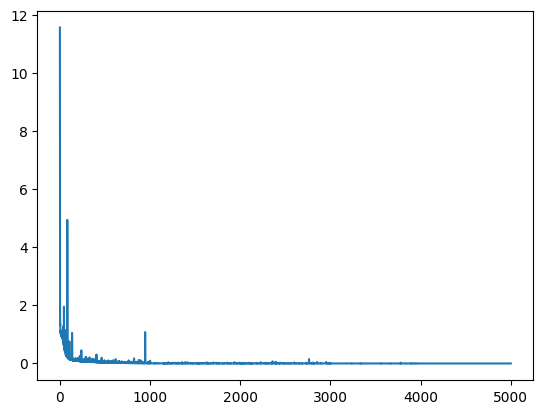

In [12]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [13]:
import joblib
joblib.dump(model.state_dict(), 'model_green.joblib')

['model_green.joblib']